# Data Preporcessing

In [96]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_auc_score
import optuna
import catboost as cb
import warnings

warnings.filterwarnings("ignore")
from tqdm.auto import tqdm


class Boosting:
    def __init__(self, X_train, X_val, y_train, y_val, cat_features, params=None):
        print("Init...")
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.cat_features = cat_features
        self.params = params
        self.model = None
        self.best_params = None
        self.top_features = None
        self.train_pool = cb.Pool(
            data=X_train, label=y_train, cat_features=cat_features
        )
        self.val_pool = cb.Pool(data=X_val, label=y_val, cat_features=cat_features)
        print("Init Finished!")

    def train(self):
        if self.params is None:
            model = cb.CatBoostClassifier(
                learning_rate=0.303,
                depth=6,
                l2_leaf_reg=2.437,
                random_seed=42,
                min_data_in_leaf=30,
                one_hot_max_size=40,
                colsample_bylevel=0.079,
                loss_function="Logloss",
                task_type="CPU",
                # iterations = 1000,
                use_best_model=True,
                verbose=100,
                thread_count=-1,
                early_stopping_rounds=100,
                eval_metric="AUC",
                class_weights=[0.1, 0.9],
                boosting_type="Plain",
                bootstrap_type="MVS",
            )
        else:
            self.params["verbose"] = 100
            self.params["iterations"] = 1000
            model = cb.CatBoostClassifier(**self.params)

        model.fit(self.train_pool, eval_set=self.val_pool)
        self.model = model
        y_train_pred = model.predict_proba(self.X_train)[:, 1]
        y_val_pred = model.predict_proba(self.X_val)[:, 1]

        roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

        print("ROC AUC на обучающей выборке:", roc_auc_tr)
        print("ROC AUC на валидационной выборке:", roc_auc_val)

    def optimize_hyperparams(self):
        def objective(trial):
            params = {
                "objective": trial.suggest_categorical("objective", ["MultiClass"]),
                "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
                "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 3e0),
                "colsample_bylevel": trial.suggest_float(
                    "colsample_bylevel", 0.01, 0.1, log=True
                ),
                "depth": trial.suggest_int("depth", 2, 8),
                "boosting_type": trial.suggest_categorical(
                    "boosting_type", ["Ordered", "Plain"]
                ),
                "bootstrap_type": trial.suggest_categorical(
                    "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
                ),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 50),
                "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 50),
                "iterations": trial.suggest_int("iterations", 500, 3500),
                "eval_metric": "AUC",
            }

            if params["bootstrap_type"] == "Bayesian":
                params["bagging_temperature"] = trial.suggest_float(
                    "bagging_temperature", 0, 10
                )
            elif params["bootstrap_type"] == "Bernoulli":
                params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

            model = cb.CatBoostClassifier(
                loss_function="Logloss",
                random_seed=42,
                task_type="CPU",
                use_best_model=True,
                verbose=False,
                **params
            )

            model.fit(self.train_pool, eval_set=self.val_pool)

            y_pred = model.predict_proba(self.X_val)[:, 1]

            roc_auc = roc_auc_score(self.y_val, y_pred)

            return roc_auc

        study = optuna.create_study(
            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
        )
        study.optimize(objective, n_trials=10, timeout=60)

        self.best_params = study.best_params

        print("Best params:", self.best_params)

    def load_model(self, file_path):
        with open(file_path, "rb") as f:
            self.model = pickle.load(f)

    def save_model(self, file_path):
        with open(file_path, "wb") as f:
            pickle.dump(self.model, f)

    def show_feats_imp(self):
        if self.model is None:
            raise ValueError("Model not found!")

        feature_importance = self.model.feature_importances_
        sorted_idx = np.argsort(feature_importance)

        plt.figure(figsize=(15, 10))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
        plt.yticks(
            range(len(sorted_idx)), np.array(self.model.feature_names_)[sorted_idx]
        )
        plt.title("Feature Importance")
        plt.show()

        self.top_features = np.flip(np.array(self.model.feature_names_)[sorted_idx])
        print(self.top_features)

        # Create DataFrame with feature importances
        importance_df = pd.DataFrame({
            'Feature': np.array(self.model.feature_names_)[sorted_idx],
            'Importance': feature_importance[sorted_idx]
        })
        
        # Save to Excel
        importance_df.to_excel('feature_importance.xlsx', index=False)

    def top_feats_selection(self):

        top = []
        roc_tr = []
        roc_val = []

        for col in tqdm(self.top_features):
            try:

                top.append(col)
                top_cat = list(set(self.cat_features) & set(top))

                train_pool = cb.Pool(
                    data=self.X_train[top], label=self.y_train, cat_features=top_cat
                )
                val_pool = cb.Pool(
                    data=self.X_val[top], label=self.y_val, cat_features=top_cat
                )

                if self.params is None:
                    model = cb.CatBoostClassifier(
                        learning_rate=0.303,
                        depth=6,
                        l2_leaf_reg=2.437,
                        random_seed=42,
                        min_data_in_leaf=30,
                        one_hot_max_size=40,
                        colsample_bylevel=0.079,
                        loss_function="Logloss",
                        task_type="CPU",
                        iterations=1000,
                        use_best_model=True,
                        verbose=100,
                        thread_count=-1,
                        early_stopping_rounds=100,
                        eval_metric="AUC",
                        class_weights=[0.1, 0.9],
                        boosting_type="Plain",
                        bootstrap_type="MVS",
                    )
                    path = "no_optuna_top_features.xlsx"
                else:
                    self.params["verbose"] = 0
                    self.params["iterations"] = 500
                    path = "optuna_top_features.xlsx"
                    model = cb.CatBoostClassifier(**self.params)

                model.fit(train_pool, eval_set=val_pool)

                y_train_pred = model.predict_proba(self.X_train[top])[:, 1]
                y_val_pred = model.predict_proba(self.X_val[top])[:, 1]

                roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
                roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

                roc_tr.append(roc_auc_tr)
                roc_val.append(roc_auc_val)
            except Exception as e:
                print(f"Problem with feature {col}: {str(e)}")
                stats = pd.DataFrame({"TRAIN": roc_tr, "VALID": roc_val})
                stats.to_excel(path, index=False)
                continue

        plt.figure(figsize=(15, 10))
        plt.plot(range(len(self.top_features)), roc_tr, marker="o", label="Train")
        plt.plot(range(len(self.top_features)), roc_val, marker="o", label="Valid")
        plt.xlabel("Number of Top Features")
        plt.ylabel("ROC AUC")
        plt.title("ROC AUC on Top-K Features")
        plt.legend()
        plt.show()

        stats = pd.DataFrame({"TRAIN": roc_tr, "VALID": roc_val})

        stats.to_excel(path, index=False)

    def one_factor_roc(self):
        story = pd.DataFrame(columns=["features", "train", "valid"])

        for feature in tqdm(self.X_train.columns):
            try:
                if self.params is None:
                    model = cb.CatBoostClassifier(
                        learning_rate=0.303,
                        depth=6,
                        l2_leaf_reg=2.437,
                        random_seed=42,
                        min_data_in_leaf=30,
                        one_hot_max_size=40,
                        colsample_bylevel=0.079,
                        loss_function="Logloss",
                        task_type="CPU",
                        iterations=1000,
                        use_best_model=True,
                        verbose=100,
                        thread_count=-1,
                        early_stopping_rounds=100,
                        eval_metric="AUC",
                        class_weights=[0.1, 0.9],
                        boosting_type="Plain",
                        bootstrap_type="MVS",
                    )
                    path = "no_optuna_one_factor_roc.xlsx"
                else:
                    self.params["verbose"] = False
                    self.params["iterations"] = 500
                    path = "optuna_one_factor_roc.xlsx"
                    model = cb.CatBoostClassifier(**self.params)

                if feature in self.cat_features:
                    train_pool = cb.Pool(
                        data=self.X_train[[feature]],
                        label=self.y_train,
                        cat_features=[feature],
                    )
                    val_pool = cb.Pool(
                        data=self.X_val[[feature]], label=self.y_val, cat_features=[feature]
                    )
                else:
                    train_pool = cb.Pool(data=self.X_train[[feature]], label=self.y_train)
                    val_pool = cb.Pool(data=self.X_val[[feature]], label=self.y_val)

                model.fit(train_pool, eval_set=val_pool)

                y_train_pred = model.predict_proba(self.X_train[[feature]])[:, 1]
                y_val_pred = model.predict_proba(self.X_val[[feature]])[:, 1]

                roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
                roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

                story = pd.concat([story, pd.DataFrame({
                    "features": [feature],
                    "train": [roc_auc_tr], 
                    "valid": [roc_auc_val]
                })], ignore_index=True)
            except Exception as e:
                print(f"Problem with feature {feature}: {str(e)}")
                story.to_excel(path, index=False)
                continue

        plt.figure(figsize=(10, 7))
        plt.bar(
            range(len(story["features"])), story["train"], align="center", label="Train"
        )
        plt.bar(
            range(len(story["features"])), story["valid"], align="edge", label="Valid"
        )
        plt.xlabel("Features")
        plt.ylabel("ROC-AUC")
        plt.title("One-Factor ROC-AUC")
        plt.xticks(range(len(story["features"])), story["features"], rotation=45)
        plt.legend()
        plt.tight_layout()
        story.to_excel(path, index=False)


In [45]:
data = pd.read_csv('train_preproc.csv')
data.sample(5)

,s6_sensor0_millimeter_step1,s8_sensor0_millimeter_step1,s8_sensor1_millimeter_step1,s7_sensor0_newton_step1,s9_sensor0_kilonewton_step1,s7_sensor1_mikrometer_step1,s0_sensor0_kilonewton_step3,s2_sensor0_millimeter_step1,s9_sensor1_sekunden (zeit)_step1,s8_sensor2_millimeter_step1,...,s0_sensor57_millimeter_step4,s2_sensor23_millimeter_step1,s2_sensor24_millimeter_step1,s8_sensor120_ml_step1,s7_sensor50_mikrometer_step1,s2_sensor25_millimeter_step1,s8_sensor121_binaer_step1,s8_sensor122_millimeter_step1,s3_sensor3_newtonmeter_step1,target
213,4606.469076,20.908130,382.939981,8863.186460,36.836991,33512.628003,-53.537243,16.340452,1056.249745,7.793388,...,25845.838372,0.556207,187.826265,160.164095,36561.296913,223.478867,0.070978,716.214782,23.834538,1
40071,4606.469076,19.057945,351.641869,8885.585212,36.836737,26200.781893,-53.537243,17.833934,1056.249745,8.017990,...,25845.838372,0.556207,149.584974,155.207101,33538.512522,220.806918,0.000000,821.585556,23.339133,1
2158,4606.469076,20.170135,364.464444,8856.466834,36.836737,33918.841676,-53.537243,18.369831,1056.249745,7.042663,...,25845.838372,0.556207,201.051091,157.362755,33898.367807,231.346273,0.000000,760.326024,24.489051,1
42305,5886.043819,25.798647,348.250092,8885.585212,36.836737,32971.009772,-53.537243,18.782735,1056.249745,6.728835,...,25843.001210,0.556207,249.740259,152.512533,33250.628295,229.490753,0.000000,704.867722,24.816343,1
44069,5886.043819,19.556871,349.546137,8874.385836,36.836737,30195.216342,-53.537243,19.916024,1056.249745,7.411872,...,25843.001210,0.556207,199.755182,149.817966,32171.062441,224.072634,0.000000,720.702527,25.111728,1


In [46]:
data = data.loc[:, data.nunique() > 1]

In [112]:
y = data['target']
X = data.drop(columns='target')

# Training

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Base

In [82]:
boosting = Boosting(X_train, X_val, y_train, y_val, cat_features = [])

Init...
Init Finished!


In [ ]:
boosting.one_factor_roc()

NameError: name 'path' is not defined

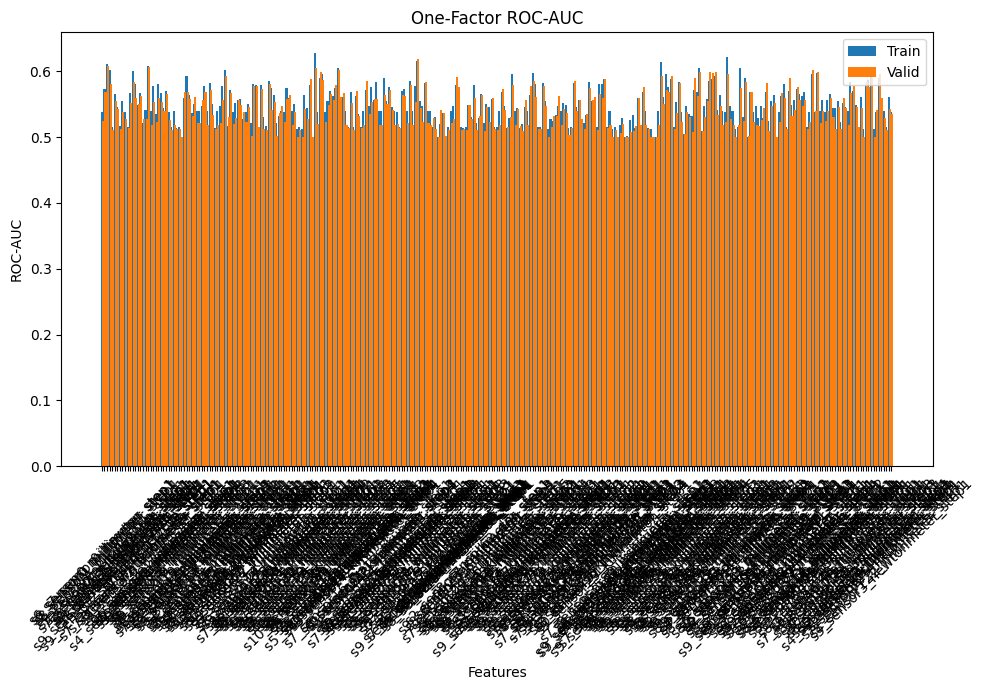

In [55]:
story = pd.read_excel("no_optuna_one_factor_roc.xlsx")

plt.figure(figsize=(10, 7))
plt.bar(
    range(len(story["features"])), story["train"], align="center", label="Train"
)
plt.bar(
    range(len(story["features"])), story["valid"], align="edge", label="Valid"
)
plt.xlabel("Features")
plt.ylabel("ROC-AUC")
plt.title("One-Factor ROC-AUC")
plt.xticks(range(len(story["features"])), story["features"], rotation=45)
plt.legend()
plt.tight_layout()
story.to_excel(path, index=False)

In [60]:
boosting.train()

0:	test: 0.5130126	best: 0.5130126 (0)	total: 50.5ms	remaining: 50.5s
100:	test: 0.7155777	best: 0.7155779 (99)	total: 3.42s	remaining: 30.5s
200:	test: 0.7203461	best: 0.7210058 (189)	total: 6.11s	remaining: 24.3s
300:	test: 0.7202123	best: 0.7213486 (217)	total: 8.92s	remaining: 20.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7213485656
bestIteration = 217

Shrink model to first 218 iterations.
ROC AUC на обучающей выборке: 0.7928262251136393
ROC AUC на валидационной выборке: 0.7213485656428423


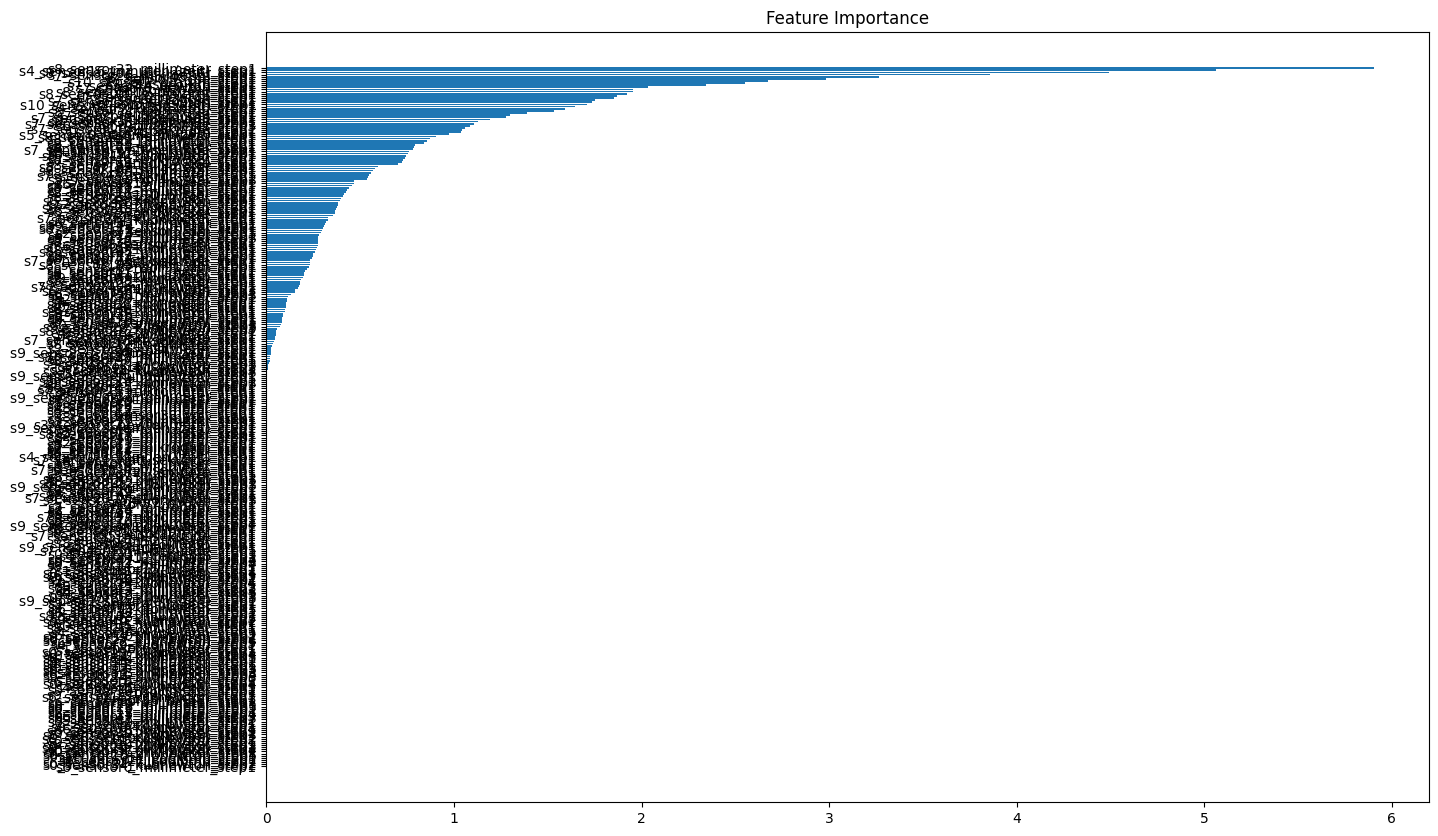

['s8_sensor32_millimeter_step1' 's4_sensor16_minuten (zeit)_step1'
 's8_sensor101_millimeter_step1' 's7_sensor26_mikroohm_step1'
 's8_sensor48_ml_step1' 's7_sensor7_cse_step1' 's10_sensor2_gramm_step1'
 's3_sensor0_km_step1' 's7_sensor44_newton_step1'
 's7_sensor0_newton_step1' 's7_sensor42_cse_step1'
 's8_sensor116_prozent_step1' 's8_sensor100_millimeter_step1'
 's7_sensor6_newton_step1' 's7_sensor32_cse_step1'
 's7_sensor37_mikroohm_step1' 's7_sensor33_newton_step1'
 's10_sensor0_minuten (zeit)_step1' 's2_sensor13_azdmp_step1'
 's4_sensor7_kilonewton_step1' 's8_sensor34_millimeter_step1'
 's7_sensor23_cse_step1' 's7_sensor2_mikroohm_step1'
 's7_sensor21_millisekunde_step1' 's1_sensor3_kilonewton_step1'
 's8_sensor33_millimeter_step1' 's7_sensor30_watt/sekunde_step1'
 's6_sensor9_millimeter_step3' 's7_sensor31_millisekunde_step1'
 's8_sensor62_dm_step1' 's7_sensor41_ampere_step1'
 's5_sensor0_sekunden (zeit)_step1' 's8_sensor119_millimeter_step1'
 's8_sensor95_millimeter_step1' 's7_se

In [61]:
boosting.show_feats_imp()

  0%|          | 0/328 [00:00<?, ?it/s]

0:	test: 0.5000000	best: 0.5000000 (0)	total: 4.04ms	remaining: 4.04s
100:	test: 0.5982219	best: 0.5982219 (88)	total: 238ms	remaining: 2.12s
200:	test: 0.6016022	best: 0.6016022 (169)	total: 468ms	remaining: 1.86s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.601602182
bestIteration = 169

Shrink model to first 170 iterations.


  0%|          | 1/328 [00:00<03:47,  1.44it/s]

0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.09ms	remaining: 3.09s
100:	test: 0.6090596	best: 0.6090596 (96)	total: 240ms	remaining: 2.13s
200:	test: 0.6113124	best: 0.6113124 (177)	total: 474ms	remaining: 1.89s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6113123919
bestIteration = 177

Shrink model to first 178 iterations.


  1%|          | 2/328 [00:01<04:01,  1.35it/s]

0:	test: 0.5000000	best: 0.5000000 (0)	total: 8.86ms	remaining: 8.85s
100:	test: 0.6245693	best: 0.6245693 (92)	total: 268ms	remaining: 2.38s
200:	test: 0.6255705	best: 0.6255705 (199)	total: 510ms	remaining: 2.03s
300:	test: 0.6330674	best: 0.6330674 (300)	total: 763ms	remaining: 1.77s
400:	test: 0.6331553	best: 0.6331701 (397)	total: 998ms	remaining: 1.49s
500:	test: 0.6333428	best: 0.6333428 (497)	total: 1.24s	remaining: 1.23s
600:	test: 0.6371215	best: 0.6371379 (565)	total: 1.48s	remaining: 980ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6371379238
bestIteration = 565

Shrink model to first 566 iterations.


  1%|          | 3/328 [00:03<06:32,  1.21s/it]

0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.08ms	remaining: 3.07s
100:	test: 0.6444588	best: 0.6449926 (60)	total: 254ms	remaining: 2.26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6449925677
bestIteration = 60

Shrink model to first 61 iterations.


  1%|          | 4/328 [00:03<05:03,  1.07it/s]

0:	test: 0.5000000	best: 0.5000000 (0)	total: 5.8ms	remaining: 5.8s
100:	test: 0.6584638	best: 0.6586703 (50)	total: 296ms	remaining: 2.63s
200:	test: 0.6630690	best: 0.6630690 (197)	total: 628ms	remaining: 2.5s
300:	test: 0.6633561	best: 0.6633956 (242)	total: 879ms	remaining: 2.04s
400:	test: 0.6690988	best: 0.6691193 (357)	total: 1.16s	remaining: 1.74s
500:	test: 0.6737280	best: 0.6737293 (487)	total: 1.49s	remaining: 1.48s
600:	test: 0.6751289	best: 0.6751289 (598)	total: 1.75s	remaining: 1.16s
700:	test: 0.6764907	best: 0.6764907 (700)	total: 2.01s	remaining: 856ms


  2%|▏         | 5/328 [00:06<07:53,  1.46s/it]

800:	test: 0.6764445	best: 0.6764907 (700)	total: 2.26s	remaining: 561ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.676490697
bestIteration = 700

Shrink model to first 701 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.42ms	remaining: 2.41s
100:	test: 0.6701699	best: 0.6701699 (97)	total: 263ms	remaining: 2.34s
200:	test: 0.6794016	best: 0.6797691 (180)	total: 521ms	remaining: 2.07s
300:	test: 0.6796025	best: 0.6798569 (260)	total: 778ms	remaining: 1.8s
400:	test: 0.6873604	best: 0.6873604 (400)	total: 1.03s	remaining: 1.54s
500:	test: 0.6876373	best: 0.6876373 (498)	total: 1.3s	remaining: 1.29s
600:	test: 0.6886202	best: 0.6886290 (564)	total: 1.55s	remaining: 1.03s
700:	test: 0.6885711	best: 0.6886378 (641)	total: 1.81s	remaining: 774ms
800:	test: 0.6903203	best: 0.6903203 (798)	total: 2.07s	remaining: 515ms
900:	test: 0.6936270	best: 0.6937536 (873)	total: 2.33s	remaining: 256ms


  2%|▏         | 6/328 [00:08<10:11,  1.90s/it]

999:	test: 0.6954604	best: 0.6954619 (965)	total: 2.59s	remaining: 0us

bestTest = 0.6954619479
bestIteration = 965

Shrink model to first 966 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.21ms	remaining: 3.2s
100:	test: 0.6848783	best: 0.6848783 (98)	total: 269ms	remaining: 2.4s
200:	test: 0.6914094	best: 0.6914094 (198)	total: 531ms	remaining: 2.11s
300:	test: 0.6942675	best: 0.6942748 (287)	total: 815ms	remaining: 1.89s


  2%|▏         | 7/328 [00:10<09:01,  1.69s/it]

400:	test: 0.6953734	best: 0.6955143 (334)	total: 1.07s	remaining: 1.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6955142519
bestIteration = 334

Shrink model to first 335 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.19ms	remaining: 3.18s
100:	test: 0.6833317	best: 0.6835133 (90)	total: 274ms	remaining: 2.44s
200:	test: 0.6861777	best: 0.6862207 (187)	total: 528ms	remaining: 2.1s
300:	test: 0.6918411	best: 0.6918497 (266)	total: 790ms	remaining: 1.83s
400:	test: 0.6949308	best: 0.6949445 (384)	total: 1.05s	remaining: 1.58s


  2%|▏         | 8/328 [00:11<08:32,  1.60s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6949444609
bestIteration = 384

Shrink model to first 385 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 7.83ms	remaining: 7.83s
100:	test: 0.6990726	best: 0.6990816 (93)	total: 298ms	remaining: 2.65s
200:	test: 0.7062293	best: 0.7062293 (200)	total: 562ms	remaining: 2.23s
300:	test: 0.7070290	best: 0.7070290 (300)	total: 821ms	remaining: 1.91s


  3%|▎         | 9/328 [00:12<07:49,  1.47s/it]

400:	test: 0.7069719	best: 0.7070295 (301)	total: 1.08s	remaining: 1.61s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7070295318
bestIteration = 301

Shrink model to first 302 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.52ms	remaining: 2.51s
100:	test: 0.6946906	best: 0.6946921 (99)	total: 288ms	remaining: 2.56s
200:	test: 0.7017188	best: 0.7017552 (180)	total: 633ms	remaining: 2.52s
300:	test: 0.7042875	best: 0.7054870 (271)	total: 894ms	remaining: 2.08s
400:	test: 0.7076190	best: 0.7078599 (378)	total: 1.16s	remaining: 1.73s
500:	test: 0.7117360	best: 0.7118212 (479)	total: 1.45s	remaining: 1.44s
600:	test: 0.7129683	best: 0.7129683 (598)	total: 1.71s	remaining: 1.13s


  3%|▎         | 10/328 [00:14<08:55,  1.68s/it]

700:	test: 0.7127508	best: 0.7129701 (602)	total: 1.97s	remaining: 841ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7129701066
bestIteration = 602

Shrink model to first 603 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.79ms	remaining: 2.79s
100:	test: 0.6988423	best: 0.6988441 (97)	total: 297ms	remaining: 2.65s
200:	test: 0.7035559	best: 0.7035611 (197)	total: 563ms	remaining: 2.24s
300:	test: 0.7073718	best: 0.7073738 (299)	total: 838ms	remaining: 1.95s
400:	test: 0.7125763	best: 0.7125766 (395)	total: 1.1s	remaining: 1.65s
500:	test: 0.7135145	best: 0.7135364 (443)	total: 1.37s	remaining: 1.37s
600:	test: 0.7136152	best: 0.7143255 (566)	total: 1.65s	remaining: 1.09s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7143254912
bestIteration = 566

Shrink model to first 567 iterations.


  3%|▎         | 11/328 [00:16<09:19,  1.77s/it]

0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.9ms	remaining: 2.9s
100:	test: 0.7041904	best: 0.7041917 (91)	total: 299ms	remaining: 2.66s
200:	test: 0.7073191	best: 0.7085116 (191)	total: 580ms	remaining: 2.3s
300:	test: 0.7080828	best: 0.7086291 (239)	total: 858ms	remaining: 1.99s
400:	test: 0.7121889	best: 0.7124335 (377)	total: 1.15s	remaining: 1.72s
500:	test: 0.7159341	best: 0.7159476 (486)	total: 1.44s	remaining: 1.44s


  4%|▎         | 12/328 [00:18<09:33,  1.82s/it]

600:	test: 0.7165008	best: 0.7165706 (524)	total: 1.74s	remaining: 1.16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7165705607
bestIteration = 524

Shrink model to first 525 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.24ms	remaining: 3.24s
100:	test: 0.7054058	best: 0.7054058 (98)	total: 324ms	remaining: 2.88s
200:	test: 0.7087060	best: 0.7087069 (198)	total: 625ms	remaining: 2.48s
300:	test: 0.7129909	best: 0.7130002 (295)	total: 907ms	remaining: 2.1s


  4%|▍         | 13/328 [00:20<08:48,  1.68s/it]

400:	test: 0.7117795	best: 0.7130250 (324)	total: 1.19s	remaining: 1.78s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7130249936
bestIteration = 324

Shrink model to first 325 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.18ms	remaining: 3.18s
100:	test: 0.7024689	best: 0.7024709 (98)	total: 309ms	remaining: 2.75s
200:	test: 0.7114532	best: 0.7114542 (196)	total: 603ms	remaining: 2.4s
300:	test: 0.7120115	best: 0.7120115 (300)	total: 882ms	remaining: 2.05s
400:	test: 0.7164809	best: 0.7164809 (400)	total: 1.17s	remaining: 1.74s
500:	test: 0.7161547	best: 0.7165331 (466)	total: 1.46s	remaining: 1.45s
600:	test: 0.7169544	best: 0.7169544 (598)	total: 1.75s	remaining: 1.16s
700:	test: 0.7212418	best: 0.7212418 (699)	total: 2.05s	remaining: 873ms
800:	test: 0.7235380	best: 0.7235426 (795)	total: 2.36s	remaining: 586ms
900:	test: 0.7252373	best: 0.7252378 (896)	total: 2.65s	remaining: 291ms


  4%|▍         | 14/328 [00:23<11:05,  2.12s/it]

999:	test: 0.7255472	best: 0.7265719 (957)	total: 2.98s	remaining: 0us

bestTest = 0.7265718651
bestIteration = 957

Shrink model to first 958 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.27ms	remaining: 3.27s
100:	test: 0.7225619	best: 0.7231381 (98)	total: 337ms	remaining: 3s
200:	test: 0.7264798	best: 0.7264798 (199)	total: 668ms	remaining: 2.66s
300:	test: 0.7302573	best: 0.7302638 (295)	total: 979ms	remaining: 2.27s
400:	test: 0.7308445	best: 0.7312335 (386)	total: 1.27s	remaining: 1.9s
500:	test: 0.7321442	best: 0.7321938 (467)	total: 1.57s	remaining: 1.56s
600:	test: 0.7339373	best: 0.7340608 (589)	total: 1.87s	remaining: 1.24s
700:	test: 0.7358510	best: 0.7358510 (698)	total: 2.29s	remaining: 975ms


  5%|▍         | 15/328 [00:26<12:12,  2.34s/it]

800:	test: 0.7343769	best: 0.7358569 (715)	total: 2.59s	remaining: 643ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7358569272
bestIteration = 715

Shrink model to first 716 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 8.09ms	remaining: 8.08s
100:	test: 0.7036210	best: 0.7036210 (99)	total: 384ms	remaining: 3.42s
200:	test: 0.7111556	best: 0.7112947 (190)	total: 692ms	remaining: 2.75s
300:	test: 0.7152265	best: 0.7152575 (275)	total: 1.01s	remaining: 2.35s


  5%|▍         | 16/328 [00:27<10:43,  2.06s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.715257536
bestIteration = 275

Shrink model to first 276 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 4.03ms	remaining: 4.03s
100:	test: 0.7055956	best: 0.7064330 (84)	total: 401ms	remaining: 3.57s
200:	test: 0.7141582	best: 0.7148048 (193)	total: 814ms	remaining: 3.23s


  5%|▌         | 17/328 [00:28<09:36,  1.85s/it]

300:	test: 0.7177569	best: 0.7181197 (218)	total: 1.15s	remaining: 2.67s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7181196639
bestIteration = 218

Shrink model to first 219 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.68ms	remaining: 2.68s
100:	test: 0.7164644	best: 0.7168061 (83)	total: 344ms	remaining: 3.06s
200:	test: 0.7224898	best: 0.7224916 (197)	total: 651ms	remaining: 2.59s
300:	test: 0.7227636	best: 0.7227639 (296)	total: 956ms	remaining: 2.22s
400:	test: 0.7254721	best: 0.7262939 (367)	total: 1.27s	remaining: 1.9s


  5%|▌         | 18/328 [00:30<09:16,  1.79s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7262939435
bestIteration = 367

Shrink model to first 368 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.13ms	remaining: 3.13s
100:	test: 0.7157032	best: 0.7161656 (94)	total: 353ms	remaining: 3.14s


  6%|▌         | 19/328 [00:31<07:55,  1.54s/it]

200:	test: 0.7167586	best: 0.7180250 (137)	total: 682ms	remaining: 2.71s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.718025
bestIteration = 137

Shrink model to first 138 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.61ms	remaining: 2.6s
100:	test: 0.7170577	best: 0.7170623 (97)	total: 372ms	remaining: 3.31s
200:	test: 0.7222752	best: 0.7227479 (162)	total: 721ms	remaining: 2.87s


  6%|▌         | 20/328 [00:32<07:09,  1.39s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7227478597
bestIteration = 162

Shrink model to first 163 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.96ms	remaining: 3.96s
100:	test: 0.7163247	best: 0.7167508 (61)	total: 354ms	remaining: 3.15s
200:	test: 0.7182639	best: 0.7184690 (179)	total: 672ms	remaining: 2.67s
300:	test: 0.7192377	best: 0.7195417 (253)	total: 986ms	remaining: 2.29s
400:	test: 0.7205369	best: 0.7205648 (375)	total: 1.31s	remaining: 1.96s


  6%|▋         | 21/328 [00:34<07:43,  1.51s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7205647801
bestIteration = 375

Shrink model to first 376 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 6.94ms	remaining: 6.93s
100:	test: 0.7223759	best: 0.7223759 (99)	total: 405ms	remaining: 3.6s
200:	test: 0.7242599	best: 0.7258959 (180)	total: 725ms	remaining: 2.88s
300:	test: 0.7277334	best: 0.7277334 (300)	total: 1.04s	remaining: 2.42s


  7%|▋         | 22/328 [00:35<07:43,  1.51s/it]

400:	test: 0.7272349	best: 0.7277334 (300)	total: 1.36s	remaining: 2.03s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7277334019
bestIteration = 300

Shrink model to first 301 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.99ms	remaining: 2.99s
100:	test: 0.7160584	best: 0.7160697 (93)	total: 354ms	remaining: 3.15s
200:	test: 0.7188151	best: 0.7190409 (195)	total: 684ms	remaining: 2.72s
300:	test: 0.7198862	best: 0.7215310 (247)	total: 1s	remaining: 2.32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7215310486
bestIteration = 247

Shrink model to first 248 iterations.


  7%|▋         | 23/328 [00:37<07:23,  1.45s/it]

0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.99ms	remaining: 2.98s
100:	test: 0.7143278	best: 0.7143278 (100)	total: 363ms	remaining: 3.23s
200:	test: 0.7198488	best: 0.7207004 (173)	total: 687ms	remaining: 2.73s
300:	test: 0.7207489	best: 0.7209044 (240)	total: 1.08s	remaining: 2.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7209044334
bestIteration = 240

Shrink model to first 241 iterations.


  7%|▋         | 24/328 [00:38<07:15,  1.43s/it]

0:	test: 0.5000000	best: 0.5000000 (0)	total: 4.35ms	remaining: 4.35s
100:	test: 0.7139721	best: 0.7139727 (96)	total: 558ms	remaining: 4.97s
200:	test: 0.7159752	best: 0.7163668 (198)	total: 960ms	remaining: 3.82s
300:	test: 0.7169081	best: 0.7169120 (287)	total: 1.37s	remaining: 3.17s
400:	test: 0.7203775	best: 0.7203775 (399)	total: 1.75s	remaining: 2.61s
500:	test: 0.7236645	best: 0.7241816 (472)	total: 2.13s	remaining: 2.13s


  8%|▊         | 25/328 [00:41<09:05,  1.80s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7241816357
bestIteration = 472

Shrink model to first 473 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.01ms	remaining: 3s
100:	test: 0.7183504	best: 0.7183504 (98)	total: 456ms	remaining: 4.06s
200:	test: 0.7270585	best: 0.7270624 (186)	total: 863ms	remaining: 3.43s
300:	test: 0.7303731	best: 0.7303768 (298)	total: 1.26s	remaining: 2.92s


  8%|▊         | 26/328 [00:43<09:18,  1.85s/it]

400:	test: 0.7302776	best: 0.7310204 (333)	total: 1.7s	remaining: 2.54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7310204192
bestIteration = 333

Shrink model to first 334 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.03ms	remaining: 3.02s
100:	test: 0.7205297	best: 0.7205297 (99)	total: 412ms	remaining: 3.67s
200:	test: 0.7220608	best: 0.7229426 (172)	total: 803ms	remaining: 3.19s
300:	test: 0.7240517	best: 0.7240618 (299)	total: 1.17s	remaining: 2.72s
400:	test: 0.7244701	best: 0.7244712 (399)	total: 1.55s	remaining: 2.32s


  8%|▊         | 27/328 [00:45<09:47,  1.95s/it]

500:	test: 0.7242134	best: 0.7245006 (410)	total: 1.94s	remaining: 1.93s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7245006257
bestIteration = 410

Shrink model to first 411 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.34ms	remaining: 3.34s
100:	test: 0.7103398	best: 0.7103398 (99)	total: 402ms	remaining: 3.58s
200:	test: 0.7192330	best: 0.7192330 (200)	total: 776ms	remaining: 3.08s
300:	test: 0.7220409	best: 0.7220409 (298)	total: 1.16s	remaining: 2.69s
400:	test: 0.7263063	best: 0.7263100 (396)	total: 1.54s	remaining: 2.3s
500:	test: 0.7261299	best: 0.7263322 (476)	total: 1.91s	remaining: 1.91s


  9%|▊         | 28/328 [00:47<10:24,  2.08s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7263321706
bestIteration = 476

Shrink model to first 477 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.62ms	remaining: 2.62s
100:	test: 0.7167149	best: 0.7167155 (98)	total: 417ms	remaining: 3.71s
200:	test: 0.7240287	best: 0.7243051 (191)	total: 804ms	remaining: 3.2s
300:	test: 0.7256601	best: 0.7277993 (269)	total: 1.19s	remaining: 2.76s


  9%|▉         | 29/328 [00:49<09:36,  1.93s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7277992662
bestIteration = 269

Shrink model to first 270 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 3.11ms	remaining: 3.11s
100:	test: 0.7279736	best: 0.7279736 (100)	total: 425ms	remaining: 3.78s
200:	test: 0.7299661	best: 0.7308298 (191)	total: 813ms	remaining: 3.23s
300:	test: 0.7306361	best: 0.7312196 (238)	total: 1.21s	remaining: 2.8s
400:	test: 0.7328558	best: 0.7328584 (392)	total: 1.6s	remaining: 2.4s
500:	test: 0.7332433	best: 0.7333187 (485)	total: 2.06s	remaining: 2.05s
600:	test: 0.7345350	best: 0.7345350 (600)	total: 2.54s	remaining: 1.69s


  9%|▉         | 30/328 [00:52<11:29,  2.31s/it]

700:	test: 0.7334414	best: 0.7345368 (603)	total: 3.03s	remaining: 1.29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7345367994
bestIteration = 603

Shrink model to first 604 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 9.87ms	remaining: 9.86s
100:	test: 0.7162942	best: 0.7172537 (84)	total: 543ms	remaining: 4.83s
200:	test: 0.7239066	best: 0.7239419 (178)	total: 1.05s	remaining: 4.16s
300:	test: 0.7250815	best: 0.7258998 (269)	total: 1.45s	remaining: 3.36s
400:	test: 0.7270293	best: 0.7270430 (386)	total: 1.83s	remaining: 2.73s
500:	test: 0.7289512	best: 0.7289512 (500)	total: 2.3s	remaining: 2.29s
600:	test: 0.7292284	best: 0.7292284 (599)	total: 2.76s	remaining: 1.83s
700:	test: 0.7281224	best: 0.7295670 (675)	total: 3.2s	remaining: 1.36s


  9%|▉         | 31/328 [00:56<13:29,  2.72s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7295670131
bestIteration = 675

Shrink model to first 676 iterations.
0:	test: 0.5849474	best: 0.5849474 (0)	total: 5.53ms	remaining: 5.53s
100:	test: 0.7263554	best: 0.7274769 (57)	total: 432ms	remaining: 3.84s
200:	test: 0.7303197	best: 0.7303437 (193)	total: 824ms	remaining: 3.27s
300:	test: 0.7327951	best: 0.7327951 (300)	total: 1.22s	remaining: 2.82s


 10%|▉         | 32/328 [00:58<12:10,  2.47s/it]

400:	test: 0.7321701	best: 0.7347995 (325)	total: 1.61s	remaining: 2.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7347994819
bestIteration = 325

Shrink model to first 326 iterations.
0:	test: 0.5765355	best: 0.5765355 (0)	total: 8.88ms	remaining: 8.87s
100:	test: 0.7273064	best: 0.7273083 (94)	total: 435ms	remaining: 3.88s
200:	test: 0.7291904	best: 0.7311728 (185)	total: 831ms	remaining: 3.3s


 10%|█         | 33/328 [00:59<10:26,  2.12s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7311728112
bestIteration = 185

Shrink model to first 186 iterations.
0:	test: 0.5588114	best: 0.5588114 (0)	total: 5.71ms	remaining: 5.71s
100:	test: 0.7248460	best: 0.7250544 (92)	total: 451ms	remaining: 4.01s
200:	test: 0.7246843	best: 0.7258231 (160)	total: 842ms	remaining: 3.35s
300:	test: 0.7266791	best: 0.7266811 (296)	total: 1.25s	remaining: 2.9s
400:	test: 0.7288459	best: 0.7290078 (391)	total: 1.65s	remaining: 2.47s
500:	test: 0.7311630	best: 0.7313007 (472)	total: 2.06s	remaining: 2.06s


 10%|█         | 34/328 [01:01<10:58,  2.24s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7313006655
bestIteration = 472

Shrink model to first 473 iterations.
0:	test: 0.6146065	best: 0.6146065 (0)	total: 5.53ms	remaining: 5.53s
100:	test: 0.7222189	best: 0.7222321 (98)	total: 553ms	remaining: 4.93s
200:	test: 0.7267728	best: 0.7267728 (193)	total: 958ms	remaining: 3.81s
300:	test: 0.7281960	best: 0.7281973 (298)	total: 1.35s	remaining: 3.14s
400:	test: 0.7288673	best: 0.7288983 (388)	total: 1.75s	remaining: 2.61s
500:	test: 0.7302422	best: 0.7302422 (500)	total: 2.15s	remaining: 2.15s
600:	test: 0.7316274	best: 0.7316274 (600)	total: 2.56s	remaining: 1.7s
700:	test: 0.7328370	best: 0.7333502 (679)	total: 2.96s	remaining: 1.26s


 11%|█         | 35/328 [01:05<12:45,  2.61s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7333502084
bestIteration = 679

Shrink model to first 680 iterations.
0:	test: 0.6061479	best: 0.6061479 (0)	total: 6.69ms	remaining: 6.68s
100:	test: 0.7225552	best: 0.7229863 (84)	total: 464ms	remaining: 4.13s
200:	test: 0.7252543	best: 0.7257032 (176)	total: 871ms	remaining: 3.46s


 11%|█         | 36/328 [01:06<10:55,  2.25s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7257032308
bestIteration = 176

Shrink model to first 177 iterations.
0:	test: 0.5863024	best: 0.5863024 (0)	total: 5.24ms	remaining: 5.23s
100:	test: 0.7225074	best: 0.7225107 (97)	total: 434ms	remaining: 3.87s
200:	test: 0.7254646	best: 0.7255142 (179)	total: 825ms	remaining: 3.28s
300:	test: 0.7274033	best: 0.7276086 (268)	total: 1.24s	remaining: 2.88s
400:	test: 0.7299578	best: 0.7299676 (395)	total: 1.65s	remaining: 2.47s
500:	test: 0.7304070	best: 0.7304070 (500)	total: 2.05s	remaining: 2.04s
600:	test: 0.7305131	best: 0.7305702 (571)	total: 2.46s	remaining: 1.63s
700:	test: 0.7311583	best: 0.7331487 (670)	total: 2.87s	remaining: 1.22s


 11%|█▏        | 37/328 [01:10<12:40,  2.61s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.733148741
bestIteration = 670

Shrink model to first 671 iterations.
0:	test: 0.5352077	best: 0.5352077 (0)	total: 3.61ms	remaining: 3.6s
100:	test: 0.7196775	best: 0.7196786 (99)	total: 454ms	remaining: 4.04s
200:	test: 0.7215853	best: 0.7215923 (199)	total: 859ms	remaining: 3.41s
300:	test: 0.7225776	best: 0.7225836 (239)	total: 1.28s	remaining: 2.98s
400:	test: 0.7230149	best: 0.7241034 (391)	total: 1.7s	remaining: 2.54s


 12%|█▏        | 38/328 [01:12<12:11,  2.52s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7241033734
bestIteration = 391

Shrink model to first 392 iterations.
0:	test: 0.5336902	best: 0.5336902 (0)	total: 4.64ms	remaining: 4.64s
100:	test: 0.7219967	best: 0.7225960 (86)	total: 453ms	remaining: 4.03s
200:	test: 0.7243896	best: 0.7243896 (200)	total: 936ms	remaining: 3.72s
300:	test: 0.7250606	best: 0.7250663 (299)	total: 1.35s	remaining: 3.14s
400:	test: 0.7248607	best: 0.7256862 (333)	total: 1.77s	remaining: 2.64s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7256861836
bestIteration = 333

Shrink model to first 334 iterations.


 12%|█▏        | 39/328 [01:14<11:34,  2.40s/it]

0:	test: 0.5917358	best: 0.5917358 (0)	total: 4.8ms	remaining: 4.8s
100:	test: 0.7214394	best: 0.7214394 (98)	total: 441ms	remaining: 3.92s
200:	test: 0.7263539	best: 0.7263539 (200)	total: 844ms	remaining: 3.35s
300:	test: 0.7297034	best: 0.7297140 (293)	total: 1.25s	remaining: 2.9s
400:	test: 0.7309174	best: 0.7311568 (340)	total: 1.66s	remaining: 2.48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7311567971
bestIteration = 340

Shrink model to first 341 iterations.


 12%|█▏        | 40/328 [01:16<11:02,  2.30s/it]

0:	test: 0.5917117	best: 0.5917117 (0)	total: 5.11ms	remaining: 5.1s
100:	test: 0.7268818	best: 0.7268818 (99)	total: 442ms	remaining: 3.94s
200:	test: 0.7338355	best: 0.7338355 (200)	total: 859ms	remaining: 3.41s
300:	test: 0.7383510	best: 0.7389414 (280)	total: 1.29s	remaining: 3s
400:	test: 0.7393452	best: 0.7393459 (398)	total: 1.72s	remaining: 2.57s
500:	test: 0.7417220	best: 0.7417289 (486)	total: 2.14s	remaining: 2.13s


 12%|█▎        | 41/328 [01:19<11:48,  2.47s/it]

600:	test: 0.7421249	best: 0.7421861 (532)	total: 2.56s	remaining: 1.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7421861016
bestIteration = 532

Shrink model to first 533 iterations.
0:	test: 0.6343566	best: 0.6343566 (0)	total: 5.41ms	remaining: 5.4s
100:	test: 0.7166816	best: 0.7169304 (74)	total: 466ms	remaining: 4.15s
200:	test: 0.7250792	best: 0.7252127 (168)	total: 898ms	remaining: 3.57s
300:	test: 0.7268121	best: 0.7269064 (291)	total: 1.33s	remaining: 3.08s
400:	test: 0.7296202	best: 0.7296282 (392)	total: 1.78s	remaining: 2.65s
500:	test: 0.7310258	best: 0.7315210 (481)	total: 2.22s	remaining: 2.21s
600:	test: 0.7309920	best: 0.7316222 (591)	total: 2.66s	remaining: 1.77s


 13%|█▎        | 42/328 [01:22<12:56,  2.71s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7316222384
bestIteration = 591

Shrink model to first 592 iterations.
0:	test: 0.5598682	best: 0.5598682 (0)	total: 5.7ms	remaining: 5.7s
100:	test: 0.7178649	best: 0.7188386 (74)	total: 454ms	remaining: 4.04s
200:	test: 0.7277541	best: 0.7277541 (200)	total: 877ms	remaining: 3.49s
300:	test: 0.7314215	best: 0.7314215 (300)	total: 1.3s	remaining: 3.03s
400:	test: 0.7328199	best: 0.7328344 (392)	total: 1.73s	remaining: 2.58s
500:	test: 0.7360630	best: 0.7360915 (462)	total: 2.16s	remaining: 2.15s


 13%|█▎        | 43/328 [01:25<13:01,  2.74s/it]

600:	test: 0.7343333	best: 0.7364897 (507)	total: 2.58s	remaining: 1.71s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7364897413
bestIteration = 507

Shrink model to first 508 iterations.
0:	test: 0.5574954	best: 0.5574954 (0)	total: 4.99ms	remaining: 4.99s
100:	test: 0.7199134	best: 0.7199167 (92)	total: 489ms	remaining: 4.35s
200:	test: 0.7212472	best: 0.7212536 (196)	total: 933ms	remaining: 3.71s
300:	test: 0.7208838	best: 0.7225456 (224)	total: 1.4s	remaining: 3.25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7225456175
bestIteration = 224

Shrink model to first 225 iterations.


 13%|█▎        | 44/328 [01:27<11:31,  2.43s/it]

0:	test: 0.5749013	best: 0.5749013 (0)	total: 5.61ms	remaining: 5.61s
100:	test: 0.7152326	best: 0.7152388 (91)	total: 552ms	remaining: 4.92s
200:	test: 0.7177737	best: 0.7185018 (139)	total: 996ms	remaining: 3.96s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7185018061
bestIteration = 139

Shrink model to first 140 iterations.


 14%|█▎        | 45/328 [01:28<09:54,  2.10s/it]

0:	test: 0.5285189	best: 0.5285189 (0)	total: 5.01ms	remaining: 5.01s
100:	test: 0.7295022	best: 0.7295290 (64)	total: 477ms	remaining: 4.25s
200:	test: 0.7299250	best: 0.7299250 (200)	total: 914ms	remaining: 3.63s
300:	test: 0.7330175	best: 0.7330320 (288)	total: 1.35s	remaining: 3.15s
400:	test: 0.7342157	best: 0.7352758 (359)	total: 1.78s	remaining: 2.67s


 14%|█▍        | 46/328 [01:31<10:03,  2.14s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7352757714
bestIteration = 359

Shrink model to first 360 iterations.
0:	test: 0.5867481	best: 0.5867481 (0)	total: 5.36ms	remaining: 5.36s
100:	test: 0.7261382	best: 0.7261382 (100)	total: 517ms	remaining: 4.6s
200:	test: 0.7271727	best: 0.7273875 (136)	total: 981ms	remaining: 3.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7273875496
bestIteration = 136

Shrink model to first 137 iterations.


 14%|█▍        | 47/328 [01:32<08:55,  1.90s/it]

0:	test: 0.6203322	best: 0.6203322 (0)	total: 17.7ms	remaining: 17.7s
100:	test: 0.7277755	best: 0.7277843 (96)	total: 472ms	remaining: 4.2s
200:	test: 0.7273452	best: 0.7281270 (167)	total: 874ms	remaining: 3.47s
300:	test: 0.7285605	best: 0.7290672 (290)	total: 1.31s	remaining: 3.04s


 15%|█▍        | 48/328 [01:34<08:52,  1.90s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7290672191
bestIteration = 290

Shrink model to first 291 iterations.
0:	test: 0.6001072	best: 0.6001072 (0)	total: 14.9ms	remaining: 14.9s
100:	test: 0.7346104	best: 0.7346192 (96)	total: 480ms	remaining: 4.27s
200:	test: 0.7373225	best: 0.7373225 (200)	total: 933ms	remaining: 3.71s
300:	test: 0.7385612	best: 0.7385649 (297)	total: 1.37s	remaining: 3.19s
400:	test: 0.7413653	best: 0.7413653 (400)	total: 1.79s	remaining: 2.67s
500:	test: 0.7450361	best: 0.7450451 (496)	total: 2.26s	remaining: 2.25s


 15%|█▍        | 49/328 [01:37<10:15,  2.21s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.74504513
bestIteration = 496

Shrink model to first 497 iterations.
0:	test: 0.5404554	best: 0.5404554 (0)	total: 6.24ms	remaining: 6.24s
100:	test: 0.7199134	best: 0.7199170 (98)	total: 462ms	remaining: 4.12s
200:	test: 0.7246951	best: 0.7246972 (189)	total: 908ms	remaining: 3.61s
300:	test: 0.7254914	best: 0.7254976 (296)	total: 1.35s	remaining: 3.13s
400:	test: 0.7249519	best: 0.7263750 (384)	total: 1.79s	remaining: 2.67s


 15%|█▌        | 50/328 [01:39<10:22,  2.24s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.726375047
bestIteration = 384

Shrink model to first 385 iterations.
0:	test: 0.5766060	best: 0.5766060 (0)	total: 5.46ms	remaining: 5.45s
100:	test: 0.7258623	best: 0.7271538 (73)	total: 480ms	remaining: 4.27s
200:	test: 0.7346249	best: 0.7346282 (180)	total: 911ms	remaining: 3.62s


 16%|█▌        | 51/328 [01:40<09:16,  2.01s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7346282346
bestIteration = 180

Shrink model to first 181 iterations.
0:	test: 0.5802074	best: 0.5802074 (0)	total: 4.59ms	remaining: 4.59s
100:	test: 0.7231901	best: 0.7231944 (99)	total: 462ms	remaining: 4.11s
200:	test: 0.7290207	best: 0.7290334 (171)	total: 904ms	remaining: 3.59s
300:	test: 0.7323568	best: 0.7324617 (275)	total: 1.33s	remaining: 3.08s
400:	test: 0.7346980	best: 0.7347217 (391)	total: 1.75s	remaining: 2.61s


 16%|█▌        | 52/328 [01:43<09:38,  2.10s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7347217361
bestIteration = 391

Shrink model to first 392 iterations.
0:	test: 0.5961459	best: 0.5961459 (0)	total: 4.99ms	remaining: 4.99s
100:	test: 0.7298961	best: 0.7312759 (56)	total: 565ms	remaining: 5.03s


 16%|█▌        | 53/328 [01:44<08:04,  1.76s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7312758695
bestIteration = 56

Shrink model to first 57 iterations.
0:	test: 0.5755322	best: 0.5755322 (0)	total: 18.6ms	remaining: 18.5s
100:	test: 0.7231224	best: 0.7231250 (98)	total: 480ms	remaining: 4.27s
200:	test: 0.7291346	best: 0.7298537 (195)	total: 907ms	remaining: 3.6s
300:	test: 0.7335754	best: 0.7335873 (298)	total: 1.33s	remaining: 3.1s


 16%|█▋        | 54/328 [01:46<08:15,  1.81s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.73358732
bestIteration = 298

Shrink model to first 299 iterations.
0:	test: 0.5923073	best: 0.5923073 (0)	total: 5.37ms	remaining: 5.36s
100:	test: 0.7290112	best: 0.7290112 (100)	total: 465ms	remaining: 4.13s
200:	test: 0.7308510	best: 0.7309006 (197)	total: 906ms	remaining: 3.6s
300:	test: 0.7350805	best: 0.7350805 (299)	total: 1.34s	remaining: 3.12s
400:	test: 0.7371414	best: 0.7371414 (400)	total: 1.82s	remaining: 2.72s
500:	test: 0.7407678	best: 0.7409158 (475)	total: 2.27s	remaining: 2.26s


 17%|█▋        | 55/328 [01:48<09:34,  2.10s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7409158241
bestIteration = 475

Shrink model to first 476 iterations.
0:	test: 0.5254442	best: 0.5254442 (0)	total: 6.4ms	remaining: 6.4s
100:	test: 0.7343937	best: 0.7343940 (99)	total: 521ms	remaining: 4.64s
200:	test: 0.7356885	best: 0.7364487 (184)	total: 1.01s	remaining: 4.02s
300:	test: 0.7391904	best: 0.7399808 (281)	total: 1.45s	remaining: 3.37s
400:	test: 0.7403830	best: 0.7403830 (400)	total: 1.99s	remaining: 2.97s
500:	test: 0.7426404	best: 0.7426404 (500)	total: 2.46s	remaining: 2.45s


 17%|█▋        | 56/328 [01:52<10:56,  2.41s/it]

600:	test: 0.7393131	best: 0.7426451 (504)	total: 2.89s	remaining: 1.92s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7426450856
bestIteration = 504

Shrink model to first 505 iterations.
0:	test: 0.5934235	best: 0.5934235 (0)	total: 6.14ms	remaining: 6.14s
100:	test: 0.7177238	best: 0.7178362 (90)	total: 553ms	remaining: 4.92s
200:	test: 0.7244993	best: 0.7250712 (172)	total: 1.08s	remaining: 4.31s


 17%|█▋        | 57/328 [01:53<09:48,  2.17s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7250711916
bestIteration = 172

Shrink model to first 173 iterations.
0:	test: 0.5865900	best: 0.5865900 (0)	total: 4.83ms	remaining: 4.82s
100:	test: 0.7284623	best: 0.7284623 (100)	total: 517ms	remaining: 4.6s


 18%|█▊        | 58/328 [01:55<08:38,  1.92s/it]

200:	test: 0.7279344	best: 0.7288590 (120)	total: 1.04s	remaining: 4.12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7288590361
bestIteration = 120

Shrink model to first 121 iterations.
0:	test: 0.5907676	best: 0.5907676 (0)	total: 5.91ms	remaining: 5.9s
100:	test: 0.7151869	best: 0.7158647 (96)	total: 636ms	remaining: 5.66s
200:	test: 0.7186095	best: 0.7186095 (200)	total: 1.29s	remaining: 5.15s
300:	test: 0.7223064	best: 0.7223072 (298)	total: 1.87s	remaining: 4.35s
400:	test: 0.7262208	best: 0.7262221 (384)	total: 2.33s	remaining: 3.48s
500:	test: 0.7261263	best: 0.7267452 (432)	total: 2.81s	remaining: 2.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7267451787
bestIteration = 432

Shrink model to first 433 iterations.


 18%|█▊        | 59/328 [01:58<10:19,  2.30s/it]

0:	test: 0.6066240	best: 0.6066240 (0)	total: 5.88ms	remaining: 5.87s
100:	test: 0.7173054	best: 0.7173054 (100)	total: 562ms	remaining: 5s
200:	test: 0.7213425	best: 0.7214853 (198)	total: 1.03s	remaining: 4.09s


 18%|█▊        | 60/328 [02:00<09:36,  2.15s/it]

300:	test: 0.7236242	best: 0.7239833 (218)	total: 1.53s	remaining: 3.55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7239832679
bestIteration = 218

Shrink model to first 219 iterations.
0:	test: 0.5354944	best: 0.5354944 (0)	total: 7.4ms	remaining: 7.39s
100:	test: 0.7171156	best: 0.7176192 (93)	total: 555ms	remaining: 4.94s
200:	test: 0.7255294	best: 0.7255302 (197)	total: 1.07s	remaining: 4.24s
300:	test: 0.7302822	best: 0.7302889 (297)	total: 1.57s	remaining: 3.66s
400:	test: 0.7304413	best: 0.7310638 (356)	total: 2.06s	remaining: 3.08s
500:	test: 0.7309331	best: 0.7317266 (431)	total: 2.54s	remaining: 2.53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7317265881
bestIteration = 431

Shrink model to first 432 iterations.


 19%|█▊        | 61/328 [02:02<10:31,  2.37s/it]

0:	test: 0.5809546	best: 0.5809546 (0)	total: 6.1ms	remaining: 6.09s
100:	test: 0.7255521	best: 0.7257753 (80)	total: 542ms	remaining: 4.83s
200:	test: 0.7291951	best: 0.7304943 (190)	total: 1.03s	remaining: 4.08s
300:	test: 0.7315117	best: 0.7315150 (285)	total: 1.54s	remaining: 3.59s
400:	test: 0.7313854	best: 0.7317754 (350)	total: 2.03s	remaining: 3.03s
500:	test: 0.7318524	best: 0.7319288 (429)	total: 2.52s	remaining: 2.51s
600:	test: 0.7316659	best: 0.7325619 (556)	total: 3.02s	remaining: 2s
700:	test: 0.7320262	best: 0.7332686 (628)	total: 3.49s	remaining: 1.49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7332685883
bestIteration = 628

Shrink model to first 629 iterations.


 19%|█▉        | 62/328 [02:06<12:31,  2.83s/it]

0:	test: 0.6118766	best: 0.6118766 (0)	total: 5.25ms	remaining: 5.24s
100:	test: 0.7305475	best: 0.7305508 (96)	total: 502ms	remaining: 4.47s
200:	test: 0.7336917	best: 0.7340491 (135)	total: 979ms	remaining: 3.89s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7340491451
bestIteration = 135

Shrink model to first 136 iterations.


 19%|█▉        | 63/328 [02:08<10:34,  2.39s/it]

0:	test: 0.5957498	best: 0.5957498 (0)	total: 5.77ms	remaining: 5.77s
100:	test: 0.7277233	best: 0.7277758 (93)	total: 630ms	remaining: 5.61s
200:	test: 0.7279690	best: 0.7286245 (149)	total: 1.16s	remaining: 4.62s
300:	test: 0.7307056	best: 0.7307087 (297)	total: 1.65s	remaining: 3.84s
400:	test: 0.7324867	best: 0.7324929 (397)	total: 2.13s	remaining: 3.18s
500:	test: 0.7321001	best: 0.7334220 (416)	total: 2.63s	remaining: 2.62s
600:	test: 0.7340264	best: 0.7351567 (573)	total: 3.12s	remaining: 2.07s
700:	test: 0.7353894	best: 0.7353948 (696)	total: 3.62s	remaining: 1.55s
800:	test: 0.7381017	best: 0.7381221 (788)	total: 4.11s	remaining: 1.02s
900:	test: 0.7382629	best: 0.7382658 (897)	total: 4.71s	remaining: 517ms


 20%|█▉        | 64/328 [02:13<14:46,  3.36s/it]

999:	test: 0.7383221	best: 0.7383231 (906)	total: 5.37s	remaining: 0us

bestTest = 0.7383230942
bestIteration = 906

Shrink model to first 907 iterations.
0:	test: 0.5996601	best: 0.5996601 (0)	total: 5.83ms	remaining: 5.83s
100:	test: 0.7277218	best: 0.7281152 (91)	total: 658ms	remaining: 5.86s
200:	test: 0.7319415	best: 0.7320714 (190)	total: 1.18s	remaining: 4.7s
300:	test: 0.7341494	best: 0.7341522 (295)	total: 1.88s	remaining: 4.37s
400:	test: 0.7344004	best: 0.7344004 (400)	total: 2.43s	remaining: 3.63s
500:	test: 0.7371517	best: 0.7371517 (499)	total: 2.97s	remaining: 2.96s


 20%|█▉        | 65/328 [02:17<15:14,  3.48s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7371517424
bestIteration = 499

Shrink model to first 500 iterations.
0:	test: 0.5598299	best: 0.5598299 (0)	total: 5.86ms	remaining: 5.85s
100:	test: 0.7135886	best: 0.7141705 (77)	total: 613ms	remaining: 5.46s
200:	test: 0.7181547	best: 0.7181549 (199)	total: 1.29s	remaining: 5.12s
300:	test: 0.7181348	best: 0.7183182 (263)	total: 1.84s	remaining: 4.28s
400:	test: 0.7188306	best: 0.7188766 (371)	total: 2.43s	remaining: 3.62s
500:	test: 0.7201799	best: 0.7203806 (468)	total: 2.94s	remaining: 2.93s
600:	test: 0.7216191	best: 0.7217622 (584)	total: 3.43s	remaining: 2.28s
700:	test: 0.7214745	best: 0.7221835 (695)	total: 3.93s	remaining: 1.68s
800:	test: 0.7220156	best: 0.7231115 (747)	total: 4.43s	remaining: 1.1s


 20%|██        | 66/328 [02:22<17:05,  3.91s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7231115341
bestIteration = 747

Shrink model to first 748 iterations.
0:	test: 0.5525449	best: 0.5525449 (0)	total: 6.62ms	remaining: 6.61s
100:	test: 0.7143319	best: 0.7151148 (97)	total: 580ms	remaining: 5.17s
200:	test: 0.7160976	best: 0.7160976 (200)	total: 1.09s	remaining: 4.32s
300:	test: 0.7160669	best: 0.7162170 (265)	total: 1.57s	remaining: 3.66s
400:	test: 0.7191731	best: 0.7193642 (392)	total: 2.13s	remaining: 3.18s
500:	test: 0.7209830	best: 0.7209873 (497)	total: 2.66s	remaining: 2.65s
600:	test: 0.7213895	best: 0.7222455 (562)	total: 3.19s	remaining: 2.12s


 20%|██        | 67/328 [02:26<16:46,  3.86s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7222454828
bestIteration = 562

Shrink model to first 563 iterations.
0:	test: 0.6076218	best: 0.6076218 (0)	total: 6.89ms	remaining: 6.88s
100:	test: 0.7224149	best: 0.7230348 (71)	total: 641ms	remaining: 5.7s
200:	test: 0.7251528	best: 0.7255984 (177)	total: 1.22s	remaining: 4.84s
300:	test: 0.7286397	best: 0.7286397 (300)	total: 1.72s	remaining: 4s
400:	test: 0.7305676	best: 0.7307474 (388)	total: 2.22s	remaining: 3.32s
500:	test: 0.7299904	best: 0.7309484 (483)	total: 2.73s	remaining: 2.72s


 21%|██        | 68/328 [02:29<16:08,  3.73s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7309483559
bestIteration = 483

Shrink model to first 484 iterations.
0:	test: 0.5510282	best: 0.5510282 (0)	total: 6.89ms	remaining: 6.88s
100:	test: 0.7269792	best: 0.7270983 (95)	total: 563ms	remaining: 5.01s
200:	test: 0.7318477	best: 0.7318503 (195)	total: 1.08s	remaining: 4.31s
300:	test: 0.7320425	best: 0.7326528 (266)	total: 1.63s	remaining: 3.78s


 21%|██        | 69/328 [02:31<14:15,  3.30s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7326528214
bestIteration = 266

Shrink model to first 267 iterations.
0:	test: 0.5714250	best: 0.5714250 (0)	total: 5.38ms	remaining: 5.37s
100:	test: 0.7354284	best: 0.7354284 (100)	total: 547ms	remaining: 4.87s
200:	test: 0.7361423	best: 0.7386563 (167)	total: 1.08s	remaining: 4.3s


 21%|██▏       | 70/328 [02:33<12:08,  2.82s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7386562902
bestIteration = 167

Shrink model to first 168 iterations.
0:	test: 0.5368705	best: 0.5368705 (0)	total: 6.07ms	remaining: 6.06s
100:	test: 0.7183319	best: 0.7183319 (100)	total: 619ms	remaining: 5.51s
200:	test: 0.7251161	best: 0.7251195 (189)	total: 1.13s	remaining: 4.5s
300:	test: 0.7245006	best: 0.7272008 (238)	total: 1.67s	remaining: 3.87s


 22%|██▏       | 71/328 [02:35<11:08,  2.60s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7272008048
bestIteration = 238

Shrink model to first 239 iterations.
0:	test: 0.5577768	best: 0.5577768 (0)	total: 6.28ms	remaining: 6.28s
100:	test: 0.7266904	best: 0.7270665 (98)	total: 587ms	remaining: 5.22s
200:	test: 0.7307727	best: 0.7307727 (200)	total: 1.13s	remaining: 4.49s


 22%|██▏       | 72/328 [02:37<10:12,  2.39s/it]

300:	test: 0.7303081	best: 0.7307727 (200)	total: 1.69s	remaining: 3.92s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7307727177
bestIteration = 200

Shrink model to first 201 iterations.
0:	test: 0.5569983	best: 0.5569983 (0)	total: 15.9ms	remaining: 15.9s
100:	test: 0.7186459	best: 0.7186459 (100)	total: 585ms	remaining: 5.21s
200:	test: 0.7216971	best: 0.7233205 (180)	total: 1.1s	remaining: 4.39s
300:	test: 0.7242015	best: 0.7253587 (259)	total: 1.63s	remaining: 3.77s


 22%|██▏       | 73/328 [02:39<09:59,  2.35s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.72535867
bestIteration = 259

Shrink model to first 260 iterations.
0:	test: 0.5510646	best: 0.5510646 (0)	total: 5.29ms	remaining: 5.29s
100:	test: 0.7180284	best: 0.7203194 (72)	total: 568ms	remaining: 5.06s


 23%|██▎       | 74/328 [02:40<08:20,  1.97s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7203194032
bestIteration = 72

Shrink model to first 73 iterations.
0:	test: 0.5520173	best: 0.5520173 (0)	total: 5.47ms	remaining: 5.47s
100:	test: 0.7186031	best: 0.7186178 (90)	total: 574ms	remaining: 5.11s
200:	test: 0.7268986	best: 0.7269076 (185)	total: 1.11s	remaining: 4.42s
300:	test: 0.7278954	best: 0.7278961 (296)	total: 1.65s	remaining: 3.83s
400:	test: 0.7310822	best: 0.7310822 (400)	total: 2.19s	remaining: 3.27s


 23%|██▎       | 75/328 [02:43<09:29,  2.25s/it]

500:	test: 0.7307030	best: 0.7310822 (400)	total: 2.71s	remaining: 2.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7310821509
bestIteration = 400

Shrink model to first 401 iterations.
0:	test: 0.5818376	best: 0.5818376 (0)	total: 5.2ms	remaining: 5.2s
100:	test: 0.7149697	best: 0.7164365 (79)	total: 574ms	remaining: 5.11s
200:	test: 0.7161539	best: 0.7167361 (149)	total: 1.12s	remaining: 4.46s


 23%|██▎       | 76/328 [02:45<08:38,  2.06s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7167361256
bestIteration = 149

Shrink model to first 150 iterations.
0:	test: 0.6108590	best: 0.6108590 (0)	total: 6.46ms	remaining: 6.45s
100:	test: 0.7156663	best: 0.7156676 (98)	total: 554ms	remaining: 4.93s
200:	test: 0.7205388	best: 0.7206761 (166)	total: 1.07s	remaining: 4.26s
300:	test: 0.7242975	best: 0.7243019 (298)	total: 1.6s	remaining: 3.71s
400:	test: 0.7245312	best: 0.7247735 (321)	total: 2.12s	remaining: 3.17s
500:	test: 0.7261554	best: 0.7262796 (498)	total: 2.65s	remaining: 2.64s
600:	test: 0.7266993	best: 0.7267228 (588)	total: 3.18s	remaining: 2.11s
700:	test: 0.7296670	best: 0.7296791 (680)	total: 3.7s	remaining: 1.58s


 23%|██▎       | 77/328 [02:49<11:30,  2.75s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7296791116
bestIteration = 680

Shrink model to first 681 iterations.
0:	test: 0.5861188	best: 0.5861188 (0)	total: 5.63ms	remaining: 5.62s
100:	test: 0.7317881	best: 0.7317881 (100)	total: 570ms	remaining: 5.07s
200:	test: 0.7344128	best: 0.7349415 (181)	total: 1.1s	remaining: 4.37s
300:	test: 0.7363795	best: 0.7363807 (276)	total: 1.61s	remaining: 3.74s
400:	test: 0.7404297	best: 0.7404349 (397)	total: 2.13s	remaining: 3.19s
500:	test: 0.7425038	best: 0.7425126 (493)	total: 2.67s	remaining: 2.66s
600:	test: 0.7431633	best: 0.7431985 (578)	total: 3.19s	remaining: 2.12s
700:	test: 0.7448523	best: 0.7449580 (648)	total: 3.71s	remaining: 1.58s


 24%|██▍       | 78/328 [02:54<13:14,  3.18s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7449579566
bestIteration = 648

Shrink model to first 649 iterations.
0:	test: 0.5545583	best: 0.5545583 (0)	total: 7.67ms	remaining: 7.67s
100:	test: 0.7205986	best: 0.7206704 (72)	total: 693ms	remaining: 6.17s
200:	test: 0.7302337	best: 0.7302344 (198)	total: 1.36s	remaining: 5.41s
300:	test: 0.7339802	best: 0.7349077 (281)	total: 2.04s	remaining: 4.75s
400:	test: 0.7340201	best: 0.7353703 (330)	total: 2.7s	remaining: 4.04s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.735370306
bestIteration = 330

Shrink model to first 331 iterations.


 24%|██▍       | 79/328 [02:57<13:04,  3.15s/it]

0:	test: 0.5501146	best: 0.5501146 (0)	total: 6.62ms	remaining: 6.61s
100:	test: 0.7135408	best: 0.7144353 (95)	total: 601ms	remaining: 5.35s
200:	test: 0.7168486	best: 0.7169686 (179)	total: 1.25s	remaining: 4.97s
300:	test: 0.7174064	best: 0.7185447 (233)	total: 1.86s	remaining: 4.31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7185446825
bestIteration = 233

Shrink model to first 234 iterations.


 24%|██▍       | 80/328 [02:59<11:56,  2.89s/it]

0:	test: 0.5538716	best: 0.5538716 (0)	total: 5.71ms	remaining: 5.71s
100:	test: 0.7268774	best: 0.7268774 (100)	total: 581ms	remaining: 5.17s
200:	test: 0.7353101	best: 0.7357156 (185)	total: 1.12s	remaining: 4.47s
300:	test: 0.7378279	best: 0.7378608 (298)	total: 1.68s	remaining: 3.9s
400:	test: 0.7403276	best: 0.7403299 (396)	total: 2.22s	remaining: 3.32s
500:	test: 0.7404364	best: 0.7407246 (471)	total: 2.76s	remaining: 2.75s


 25%|██▍       | 81/328 [03:02<12:46,  3.10s/it]

600:	test: 0.7405997	best: 0.7416473 (506)	total: 3.28s	remaining: 2.18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7416473056
bestIteration = 506

Shrink model to first 507 iterations.
0:	test: 0.5572566	best: 0.5572566 (0)	total: 7.41ms	remaining: 7.4s
100:	test: 0.7229535	best: 0.7229568 (95)	total: 601ms	remaining: 5.35s
200:	test: 0.7304488	best: 0.7304548 (191)	total: 1.16s	remaining: 4.62s


 25%|██▌       | 82/328 [03:04<11:14,  2.74s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7304547609
bestIteration = 191

Shrink model to first 192 iterations.
0:	test: 0.5599027	best: 0.5599027 (0)	total: 5.93ms	remaining: 5.93s
100:	test: 0.7257598	best: 0.7257598 (100)	total: 586ms	remaining: 5.22s
200:	test: 0.7297489	best: 0.7303680 (193)	total: 1.26s	remaining: 5s
300:	test: 0.7298457	best: 0.7304697 (285)	total: 1.79s	remaining: 4.16s
400:	test: 0.7309163	best: 0.7309179 (399)	total: 2.34s	remaining: 3.49s
500:	test: 0.7362903	best: 0.7362903 (500)	total: 2.87s	remaining: 2.86s
600:	test: 0.7356190	best: 0.7367726 (540)	total: 3.42s	remaining: 2.27s


 25%|██▌       | 83/328 [03:08<12:40,  3.10s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7367725705
bestIteration = 540

Shrink model to first 541 iterations.
0:	test: 0.5671519	best: 0.5671519 (0)	total: 6.15ms	remaining: 6.14s
100:	test: 0.7182203	best: 0.7186935 (83)	total: 592ms	remaining: 5.27s
200:	test: 0.7220448	best: 0.7220500 (195)	total: 1.15s	remaining: 4.57s
300:	test: 0.7265938	best: 0.7265938 (295)	total: 1.71s	remaining: 3.97s


 26%|██▌       | 84/328 [03:11<11:51,  2.92s/it]

400:	test: 0.7269157	best: 0.7269859 (305)	total: 2.24s	remaining: 3.35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7269859063
bestIteration = 305

Shrink model to first 306 iterations.
0:	test: 0.5892872	best: 0.5892872 (0)	total: 6.32ms	remaining: 6.32s
100:	test: 0.7196037	best: 0.7202076 (87)	total: 599ms	remaining: 5.33s
200:	test: 0.7275456	best: 0.7275456 (200)	total: 1.17s	remaining: 4.66s
300:	test: 0.7286666	best: 0.7286932 (273)	total: 1.82s	remaining: 4.22s
400:	test: 0.7338074	best: 0.7338089 (397)	total: 2.36s	remaining: 3.52s
500:	test: 0.7338562	best: 0.7338590 (490)	total: 2.9s	remaining: 2.89s
600:	test: 0.7347946	best: 0.7351109 (584)	total: 3.47s	remaining: 2.3s


 26%|██▌       | 85/328 [03:15<13:21,  3.30s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7351108522
bestIteration = 584

Shrink model to first 585 iterations.
0:	test: 0.5871364	best: 0.5871364 (0)	total: 8.17ms	remaining: 8.16s
100:	test: 0.7208453	best: 0.7208461 (95)	total: 623ms	remaining: 5.55s
200:	test: 0.7233582	best: 0.7243723 (157)	total: 1.19s	remaining: 4.72s
300:	test: 0.7281544	best: 0.7289350 (232)	total: 1.76s	remaining: 4.08s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7289349738
bestIteration = 232

Shrink model to first 233 iterations.


 26%|██▌       | 86/328 [03:17<12:02,  2.98s/it]

0:	test: 0.5670800	best: 0.5670800 (0)	total: 5.51ms	remaining: 5.5s
100:	test: 0.7176518	best: 0.7182435 (73)	total: 581ms	remaining: 5.17s
200:	test: 0.7220662	best: 0.7222029 (171)	total: 1.15s	remaining: 4.57s


 27%|██▋       | 87/328 [03:19<10:29,  2.61s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7222028647
bestIteration = 171

Shrink model to first 172 iterations.
0:	test: 0.6097097	best: 0.6097097 (0)	total: 6.8ms	remaining: 6.79s
100:	test: 0.7254395	best: 0.7254395 (100)	total: 622ms	remaining: 5.54s
200:	test: 0.7252365	best: 0.7260517 (159)	total: 1.18s	remaining: 4.69s
300:	test: 0.7257309	best: 0.7263854 (251)	total: 1.75s	remaining: 4.06s
400:	test: 0.7291597	best: 0.7291612 (394)	total: 2.31s	remaining: 3.45s
500:	test: 0.7301407	best: 0.7301489 (483)	total: 2.88s	remaining: 2.87s
600:	test: 0.7308510	best: 0.7308525 (592)	total: 3.46s	remaining: 2.29s
700:	test: 0.7309410	best: 0.7309441 (679)	total: 4.04s	remaining: 1.72s
800:	test: 0.7326346	best: 0.7326382 (787)	total: 4.61s	remaining: 1.15s
900:	test: 0.7333999	best: 0.7341733 (847)	total: 5.2s	remaining: 571ms


 27%|██▋       | 88/328 [03:25<14:12,  3.55s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7341732542
bestIteration = 847

Shrink model to first 848 iterations.
0:	test: 0.5579455	best: 0.5579455 (0)	total: 6.05ms	remaining: 6.04s
100:	test: 0.7217480	best: 0.7217480 (100)	total: 661ms	remaining: 5.88s
200:	test: 0.7291013	best: 0.7291013 (200)	total: 1.25s	remaining: 4.97s
300:	test: 0.7307614	best: 0.7307766 (283)	total: 1.83s	remaining: 4.26s
400:	test: 0.7370797	best: 0.7370797 (399)	total: 2.41s	remaining: 3.6s
500:	test: 0.7378662	best: 0.7378693 (497)	total: 2.99s	remaining: 2.97s
600:	test: 0.7386330	best: 0.7386330 (600)	total: 3.55s	remaining: 2.36s
700:	test: 0.7372424	best: 0.7386741 (675)	total: 4.12s	remaining: 1.76s


 27%|██▋       | 89/328 [03:30<15:43,  3.95s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7386741123
bestIteration = 675

Shrink model to first 676 iterations.
0:	test: 0.5791174	best: 0.5791174 (0)	total: 7.64ms	remaining: 7.64s
100:	test: 0.7308799	best: 0.7311754 (94)	total: 662ms	remaining: 5.89s
200:	test: 0.7306653	best: 0.7316705 (196)	total: 1.27s	remaining: 5.07s
300:	test: 0.7320686	best: 0.7323356 (232)	total: 1.89s	remaining: 4.38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7323356394
bestIteration = 232

Shrink model to first 233 iterations.


 27%|██▋       | 90/328 [03:32<13:39,  3.44s/it]

0:	test: 0.5806283	best: 0.5806283 (0)	total: 6.38ms	remaining: 6.37s
100:	test: 0.7135181	best: 0.7135478 (93)	total: 635ms	remaining: 5.66s
200:	test: 0.7178016	best: 0.7182296 (193)	total: 1.23s	remaining: 4.89s
300:	test: 0.7208856	best: 0.7211077 (256)	total: 1.84s	remaining: 4.28s


 28%|██▊       | 91/328 [03:34<12:24,  3.14s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7211077088
bestIteration = 256

Shrink model to first 257 iterations.
0:	test: 0.5756203	best: 0.5756203 (0)	total: 14.2ms	remaining: 14.2s
100:	test: 0.7169332	best: 0.7176985 (75)	total: 1.11s	remaining: 9.93s


 28%|██▊       | 92/328 [03:37<11:15,  2.86s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7176985196
bestIteration = 75

Shrink model to first 76 iterations.
0:	test: 0.5745468	best: 0.5745468 (0)	total: 16.5ms	remaining: 16.5s
100:	test: 0.7144748	best: 0.7153228 (50)	total: 1.14s	remaining: 10.1s


 28%|██▊       | 93/328 [03:38<10:06,  2.58s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7153227546
bestIteration = 50

Shrink model to first 51 iterations.
0:	test: 0.5791218	best: 0.5791218 (0)	total: 27.2ms	remaining: 27.2s
100:	test: 0.7233670	best: 0.7233680 (96)	total: 1.15s	remaining: 10.3s
200:	test: 0.7254034	best: 0.7254046 (199)	total: 2.35s	remaining: 9.33s
300:	test: 0.7288720	best: 0.7288735 (298)	total: 3.41s	remaining: 7.92s
400:	test: 0.7291641	best: 0.7300539 (342)	total: 4.57s	remaining: 6.83s


 29%|██▊       | 94/328 [03:44<13:12,  3.39s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7300538925
bestIteration = 342

Shrink model to first 343 iterations.
0:	test: 0.5671248	best: 0.5671248 (0)	total: 16.6ms	remaining: 16.6s
100:	test: 0.7295861	best: 0.7295861 (99)	total: 1.17s	remaining: 10.4s
200:	test: 0.7307740	best: 0.7315677 (112)	total: 2.3s	remaining: 9.15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7315677389
bestIteration = 112

Shrink model to first 113 iterations.


 29%|██▉       | 95/328 [03:46<12:15,  3.16s/it]

0:	test: 0.5916370	best: 0.5916370 (0)	total: 18.8ms	remaining: 18.8s
100:	test: 0.7180237	best: 0.7191798 (79)	total: 1.25s	remaining: 11.1s
200:	test: 0.7230798	best: 0.7230798 (200)	total: 2.46s	remaining: 9.76s
300:	test: 0.7268857	best: 0.7268867 (296)	total: 3.55s	remaining: 8.25s
400:	test: 0.7268612	best: 0.7282373 (312)	total: 4.63s	remaining: 6.91s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7282373285
bestIteration = 312

Shrink model to first 313 iterations.


 29%|██▉       | 96/328 [03:51<14:22,  3.72s/it]

0:	test: 0.5854910	best: 0.5854910 (0)	total: 16.6ms	remaining: 16.6s
100:	test: 0.7171161	best: 0.7175766 (92)	total: 1.17s	remaining: 10.5s
200:	test: 0.7249940	best: 0.7255534 (161)	total: 2.3s	remaining: 9.13s


 30%|██▉       | 97/328 [03:55<13:43,  3.56s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7255534218
bestIteration = 161

Shrink model to first 162 iterations.
0:	test: 0.6033491	best: 0.6033491 (0)	total: 17ms	remaining: 16.9s
100:	test: 0.7267966	best: 0.7280937 (85)	total: 1.32s	remaining: 11.8s
200:	test: 0.7325188	best: 0.7337405 (176)	total: 2.63s	remaining: 10.5s
300:	test: 0.7359757	best: 0.7359757 (300)	total: 3.93s	remaining: 9.13s
400:	test: 0.7387488	best: 0.7393216 (378)	total: 5.08s	remaining: 7.59s


 30%|██▉       | 98/328 [04:01<17:01,  4.44s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7393216491
bestIteration = 378

Shrink model to first 379 iterations.
0:	test: 0.5620908	best: 0.5620908 (0)	total: 16.8ms	remaining: 16.8s
100:	test: 0.7236423	best: 0.7236423 (98)	total: 1.21s	remaining: 10.8s
200:	test: 0.7286924	best: 0.7294704 (167)	total: 2.45s	remaining: 9.76s


 30%|███       | 99/328 [04:04<15:48,  4.14s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7294704121
bestIteration = 167

Shrink model to first 168 iterations.
0:	test: 0.5967555	best: 0.5967555 (0)	total: 18.9ms	remaining: 18.9s
100:	test: 0.7316512	best: 0.7316540 (89)	total: 1.33s	remaining: 11.9s
200:	test: 0.7387423	best: 0.7392845 (157)	total: 2.5s	remaining: 9.95s
300:	test: 0.7395660	best: 0.7402520 (280)	total: 3.65s	remaining: 8.48s


 30%|███       | 100/328 [04:09<16:34,  4.36s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.740252015
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.5469507	best: 0.5469507 (0)	total: 15.6ms	remaining: 15.6s
100:	test: 0.7135943	best: 0.7136209 (98)	total: 1.52s	remaining: 13.5s
200:	test: 0.7190987	best: 0.7191517 (176)	total: 2.8s	remaining: 11.1s
300:	test: 0.7226673	best: 0.7226701 (299)	total: 4.25s	remaining: 9.86s
400:	test: 0.7238273	best: 0.7238273 (399)	total: 5.42s	remaining: 8.1s
500:	test: 0.7250962	best: 0.7256428 (472)	total: 6.62s	remaining: 6.6s


 31%|███       | 101/328 [04:17<20:25,  5.40s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7256427906
bestIteration = 472

Shrink model to first 473 iterations.
0:	test: 0.5581063	best: 0.5581063 (0)	total: 16.3ms	remaining: 16.2s
100:	test: 0.7129581	best: 0.7138916 (84)	total: 1.42s	remaining: 12.7s
200:	test: 0.7173798	best: 0.7176967 (145)	total: 2.69s	remaining: 10.7s
300:	test: 0.7197461	best: 0.7199631 (284)	total: 4.07s	remaining: 9.45s
400:	test: 0.7222229	best: 0.7222278 (391)	total: 5.37s	remaining: 8.02s
500:	test: 0.7231979	best: 0.7232212 (451)	total: 6.69s	remaining: 6.66s
600:	test: 0.7259968	best: 0.7263083 (572)	total: 8.03s	remaining: 5.33s


 31%|███       | 102/328 [04:26<24:43,  6.56s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7263082786
bestIteration = 572

Shrink model to first 573 iterations.
0:	test: 0.5999793	best: 0.5999793 (0)	total: 19.7ms	remaining: 19.7s
100:	test: 0.7198199	best: 0.7198201 (99)	total: 1.38s	remaining: 12.3s
200:	test: 0.7198638	best: 0.7204238 (114)	total: 2.65s	remaining: 10.5s
300:	test: 0.7235558	best: 0.7257322 (273)	total: 4.08s	remaining: 9.46s
400:	test: 0.7268232	best: 0.7268299 (396)	total: 5.32s	remaining: 7.95s
500:	test: 0.7274348	best: 0.7274364 (499)	total: 6.67s	remaining: 6.65s
600:	test: 0.7282872	best: 0.7282872 (599)	total: 8.01s	remaining: 5.32s
700:	test: 0.7279883	best: 0.7283058 (614)	total: 9.32s	remaining: 3.98s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7283057758
bestIteration = 614

Shrink model to first 615 iterations.


 31%|███▏      | 103/328 [04:36<28:15,  7.53s/it]

0:	test: 0.5805269	best: 0.5805269 (0)	total: 14.6ms	remaining: 14.6s
100:	test: 0.7164957	best: 0.7165024 (98)	total: 1.4s	remaining: 12.5s
200:	test: 0.7174123	best: 0.7174302 (189)	total: 2.75s	remaining: 10.9s
300:	test: 0.7227055	best: 0.7227055 (299)	total: 4.05s	remaining: 9.4s
400:	test: 0.7238554	best: 0.7242746 (375)	total: 5.36s	remaining: 8.01s
500:	test: 0.7229059	best: 0.7245647 (438)	total: 6.74s	remaining: 6.71s


 32%|███▏      | 104/328 [04:44<28:03,  7.52s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.724564682
bestIteration = 438

Shrink model to first 439 iterations.
0:	test: 0.5090975	best: 0.5090975 (0)	total: 16.3ms	remaining: 16.3s
100:	test: 0.7295559	best: 0.7296308 (86)	total: 1.43s	remaining: 12.8s
200:	test: 0.7328073	best: 0.7331872 (149)	total: 2.78s	remaining: 11.1s


 32%|███▏      | 105/328 [04:47<23:39,  6.37s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7331872265
bestIteration = 149

Shrink model to first 150 iterations.
0:	test: 0.5757330	best: 0.5757330 (0)	total: 20.1ms	remaining: 20.1s
100:	test: 0.7181448	best: 0.7181448 (100)	total: 1.48s	remaining: 13.2s
200:	test: 0.7209388	best: 0.7232957 (191)	total: 2.87s	remaining: 11.4s


 32%|███▏      | 106/328 [04:52<21:17,  5.75s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.723295696
bestIteration = 191

Shrink model to first 192 iterations.
0:	test: 0.5460219	best: 0.5460219 (0)	total: 9.93ms	remaining: 9.92s
100:	test: 0.7107345	best: 0.7108104 (93)	total: 1.55s	remaining: 13.8s
200:	test: 0.7154950	best: 0.7154999 (191)	total: 2.88s	remaining: 11.4s
300:	test: 0.7180760	best: 0.7180843 (287)	total: 4.15s	remaining: 9.64s
400:	test: 0.7168057	best: 0.7185988 (318)	total: 5.62s	remaining: 8.39s


 33%|███▎      | 107/328 [04:58<21:38,  5.88s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7185987946
bestIteration = 318

Shrink model to first 319 iterations.
0:	test: 0.5847576	best: 0.5847576 (0)	total: 18ms	remaining: 17.9s
100:	test: 0.7258259	best: 0.7258590 (86)	total: 1.68s	remaining: 15s
200:	test: 0.7298824	best: 0.7298834 (197)	total: 3.14s	remaining: 12.5s
300:	test: 0.7327127	best: 0.7327127 (299)	total: 4.64s	remaining: 10.8s
400:	test: 0.7348279	best: 0.7348289 (393)	total: 6.06s	remaining: 9.06s
500:	test: 0.7342823	best: 0.7351054 (491)	total: 7.39s	remaining: 7.37s


 33%|███▎      | 108/328 [05:07<24:53,  6.79s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7351054281
bestIteration = 491

Shrink model to first 492 iterations.
0:	test: 0.5700437	best: 0.5700437 (0)	total: 30.3ms	remaining: 30.2s
100:	test: 0.7169363	best: 0.7196357 (88)	total: 1.43s	remaining: 12.7s


 33%|███▎      | 109/328 [05:10<20:34,  5.64s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7196357057
bestIteration = 88

Shrink model to first 89 iterations.
0:	test: 0.5963586	best: 0.5963586 (0)	total: 19.7ms	remaining: 19.6s
100:	test: 0.7130728	best: 0.7130728 (100)	total: 1.44s	remaining: 12.8s
200:	test: 0.7195376	best: 0.7195376 (200)	total: 2.87s	remaining: 11.4s
300:	test: 0.7239262	best: 0.7239262 (300)	total: 4.3s	remaining: 9.98s
400:	test: 0.7235344	best: 0.7246055 (314)	total: 5.68s	remaining: 8.48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7246054921
bestIteration = 314

Shrink model to first 315 iterations.


 34%|███▎      | 110/328 [05:16<21:09,  5.82s/it]

0:	test: 0.5480562	best: 0.5480562 (0)	total: 25.6ms	remaining: 25.6s
100:	test: 0.7141803	best: 0.7146613 (85)	total: 1.53s	remaining: 13.7s
200:	test: 0.7186932	best: 0.7186978 (197)	total: 2.94s	remaining: 11.7s
300:	test: 0.7228654	best: 0.7228685 (296)	total: 4.3s	remaining: 10s
400:	test: 0.7242558	best: 0.7242715 (388)	total: 5.72s	remaining: 8.54s
500:	test: 0.7244397	best: 0.7250133 (491)	total: 7.11s	remaining: 7.08s
600:	test: 0.7279142	best: 0.7279152 (598)	total: 8.54s	remaining: 5.67s
700:	test: 0.7291078	best: 0.7291475 (689)	total: 10s	remaining: 4.28s
800:	test: 0.7320711	best: 0.7320711 (800)	total: 11.4s	remaining: 2.83s
900:	test: 0.7337214	best: 0.7340228 (896)	total: 12.8s	remaining: 1.4s


 34%|███▍      | 111/328 [05:30<30:21,  8.40s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7340227994
bestIteration = 896

Shrink model to first 897 iterations.
0:	test: 0.6038819	best: 0.6038819 (0)	total: 18.3ms	remaining: 18.2s
100:	test: 0.7130932	best: 0.7133714 (91)	total: 1.47s	remaining: 13.1s
200:	test: 0.7176071	best: 0.7176071 (200)	total: 2.95s	remaining: 11.7s
300:	test: 0.7194614	best: 0.7194655 (296)	total: 4.35s	remaining: 10.1s
400:	test: 0.7211620	best: 0.7217400 (358)	total: 5.69s	remaining: 8.5s


 34%|███▍      | 112/328 [05:37<28:29,  7.91s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7217400064
bestIteration = 358

Shrink model to first 359 iterations.
0:	test: 0.5926030	best: 0.5926030 (0)	total: 46.6ms	remaining: 46.6s
100:	test: 0.7184930	best: 0.7184930 (100)	total: 1.58s	remaining: 14s


 34%|███▍      | 113/328 [05:40<23:18,  6.51s/it]

200:	test: 0.7142723	best: 0.7185034 (103)	total: 2.96s	remaining: 11.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7185033559
bestIteration = 103

Shrink model to first 104 iterations.
0:	test: 0.5599507	best: 0.5599507 (0)	total: 39.7ms	remaining: 39.6s
100:	test: 0.7130205	best: 0.7130205 (100)	total: 1.62s	remaining: 14.4s
200:	test: 0.7181778	best: 0.7181786 (197)	total: 3.02s	remaining: 12s
300:	test: 0.7187383	best: 0.7187440 (288)	total: 4.49s	remaining: 10.4s
400:	test: 0.7232005	best: 0.7232010 (399)	total: 5.91s	remaining: 8.83s


 35%|███▍      | 114/328 [05:48<24:22,  6.83s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7232010321
bestIteration = 399

Shrink model to first 400 iterations.
0:	test: 0.5437811	best: 0.5437811 (0)	total: 36.7ms	remaining: 36.7s
100:	test: 0.7193844	best: 0.7199991 (91)	total: 1.57s	remaining: 14s
200:	test: 0.7267168	best: 0.7274152 (185)	total: 2.99s	remaining: 11.9s
300:	test: 0.7280036	best: 0.7281916 (253)	total: 4.43s	remaining: 10.3s


 35%|███▌      | 115/328 [05:53<22:45,  6.41s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.728191611
bestIteration = 253

Shrink model to first 254 iterations.
0:	test: 0.5809792	best: 0.5809792 (0)	total: 19.7ms	remaining: 19.7s
100:	test: 0.7131110	best: 0.7137206 (85)	total: 1.59s	remaining: 14.2s
200:	test: 0.7209987	best: 0.7210659 (193)	total: 3.09s	remaining: 12.3s


 35%|███▌      | 116/328 [05:58<20:50,  5.90s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7210658656
bestIteration = 193

Shrink model to first 194 iterations.
0:	test: 0.5475373	best: 0.5475373 (0)	total: 17.2ms	remaining: 17.2s
100:	test: 0.7104865	best: 0.7104865 (100)	total: 1.6s	remaining: 14.2s
200:	test: 0.7132611	best: 0.7139176 (167)	total: 3.12s	remaining: 12.4s


 36%|███▌      | 117/328 [06:03<19:10,  5.45s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7139176489
bestIteration = 167

Shrink model to first 168 iterations.
0:	test: 0.5414974	best: 0.5414974 (0)	total: 19.1ms	remaining: 19.1s
100:	test: 0.7178318	best: 0.7178318 (100)	total: 1.59s	remaining: 14.2s
200:	test: 0.7245068	best: 0.7245068 (200)	total: 3.06s	remaining: 12.2s


 36%|███▌      | 118/328 [06:07<18:22,  5.25s/it]

300:	test: 0.7233303	best: 0.7245068 (200)	total: 4.51s	remaining: 10.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7245068247
bestIteration = 200

Shrink model to first 201 iterations.
0:	test: 0.5730376	best: 0.5730376 (0)	total: 19ms	remaining: 19s
100:	test: 0.7268469	best: 0.7268469 (100)	total: 1.57s	remaining: 14s
200:	test: 0.7263279	best: 0.7268488 (108)	total: 3.32s	remaining: 13.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7268487535
bestIteration = 108

Shrink model to first 109 iterations.


 36%|███▋      | 119/328 [06:11<16:40,  4.79s/it]

0:	test: 0.5964353	best: 0.5964353 (0)	total: 18.6ms	remaining: 18.6s
100:	test: 0.7265427	best: 0.7265427 (100)	total: 1.8s	remaining: 16s
200:	test: 0.7279772	best: 0.7305811 (155)	total: 3.44s	remaining: 13.7s


 37%|███▋      | 120/328 [06:16<16:20,  4.71s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7305810654
bestIteration = 155

Shrink model to first 156 iterations.
0:	test: 0.6123213	best: 0.6123213 (0)	total: 18.8ms	remaining: 18.8s
100:	test: 0.7199761	best: 0.7208254 (71)	total: 1.56s	remaining: 13.9s
200:	test: 0.7284992	best: 0.7288743 (194)	total: 3.19s	remaining: 12.7s
300:	test: 0.7301391	best: 0.7301427 (299)	total: 4.63s	remaining: 10.8s
400:	test: 0.7296218	best: 0.7301890 (339)	total: 6.08s	remaining: 9.08s


 37%|███▋      | 121/328 [06:23<18:36,  5.39s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.730188979
bestIteration = 339

Shrink model to first 340 iterations.
0:	test: 0.5884827	best: 0.5884827 (0)	total: 20.6ms	remaining: 20.6s
100:	test: 0.7252894	best: 0.7269381 (60)	total: 1.66s	remaining: 14.8s


 37%|███▋      | 122/328 [06:25<15:49,  4.61s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7269381224
bestIteration = 60

Shrink model to first 61 iterations.
0:	test: 0.5773793	best: 0.5773793 (0)	total: 32.6ms	remaining: 32.5s
100:	test: 0.7096644	best: 0.7096685 (94)	total: 1.59s	remaining: 14.2s
200:	test: 0.7183375	best: 0.7195494 (171)	total: 3.2s	remaining: 12.7s
300:	test: 0.7231616	best: 0.7231616 (300)	total: 4.68s	remaining: 10.9s


 38%|███▊      | 123/328 [06:32<17:42,  5.18s/it]

400:	test: 0.7224250	best: 0.7231712 (303)	total: 6.17s	remaining: 9.22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7231711995
bestIteration = 303

Shrink model to first 304 iterations.
0:	test: 0.5440999	best: 0.5440999 (0)	total: 46ms	remaining: 46s
100:	test: 0.7114396	best: 0.7114404 (99)	total: 1.66s	remaining: 14.8s
200:	test: 0.7196199	best: 0.7198571 (190)	total: 3.19s	remaining: 12.7s


 38%|███▊      | 124/328 [06:37<17:14,  5.07s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7198570615
bestIteration = 190

Shrink model to first 191 iterations.
0:	test: 0.5751384	best: 0.5751384 (0)	total: 18.1ms	remaining: 18.1s
100:	test: 0.7137410	best: 0.7137412 (98)	total: 1.68s	remaining: 14.9s
200:	test: 0.7255787	best: 0.7255787 (200)	total: 3.27s	remaining: 13s
300:	test: 0.7268438	best: 0.7268475 (297)	total: 4.77s	remaining: 11.1s
400:	test: 0.7316536	best: 0.7316559 (385)	total: 6.37s	remaining: 9.52s
500:	test: 0.7321823	best: 0.7321823 (500)	total: 7.96s	remaining: 7.93s
600:	test: 0.7332261	best: 0.7333955 (524)	total: 9.5s	remaining: 6.31s
700:	test: 0.7338300	best: 0.7338460 (664)	total: 11s	remaining: 4.69s
800:	test: 0.7332369	best: 0.7338550 (709)	total: 12.6s	remaining: 3.12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7338550391
bestIteration = 709

Shrink model to first 710 iterations.


 38%|███▊      | 125/328 [06:50<25:12,  7.45s/it]

0:	test: 0.5588846	best: 0.5588846 (0)	total: 21.7ms	remaining: 21.7s
100:	test: 0.7220055	best: 0.7232590 (92)	total: 1.63s	remaining: 14.5s
200:	test: 0.7272483	best: 0.7279212 (185)	total: 3.34s	remaining: 13.3s


 38%|███▊      | 126/328 [06:55<22:32,  6.70s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7279211798
bestIteration = 185

Shrink model to first 186 iterations.
0:	test: 0.5815242	best: 0.5815242 (0)	total: 20.1ms	remaining: 20s
100:	test: 0.7299413	best: 0.7329008 (89)	total: 1.68s	remaining: 15s


 39%|███▊      | 127/328 [06:58<19:02,  5.68s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7329007812
bestIteration = 89

Shrink model to first 90 iterations.
0:	test: 0.6040087	best: 0.6040087 (0)	total: 13.7ms	remaining: 13.7s
100:	test: 0.7016992	best: 0.7042681 (56)	total: 1.66s	remaining: 14.8s
200:	test: 0.7058791	best: 0.7059927 (126)	total: 3.25s	remaining: 12.9s


 39%|███▉      | 128/328 [07:02<17:08,  5.14s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7059927498
bestIteration = 126

Shrink model to first 127 iterations.
0:	test: 0.5560462	best: 0.5560462 (0)	total: 21.3ms	remaining: 21.2s
100:	test: 0.7141705	best: 0.7141759 (95)	total: 1.71s	remaining: 15.3s
200:	test: 0.7168836	best: 0.7168893 (199)	total: 3.31s	remaining: 13.2s
300:	test: 0.7207154	best: 0.7207154 (300)	total: 4.96s	remaining: 11.5s
400:	test: 0.7224960	best: 0.7225004 (398)	total: 6.53s	remaining: 9.75s
500:	test: 0.7218818	best: 0.7243575 (486)	total: 8.21s	remaining: 8.18s


 39%|███▉      | 129/328 [07:12<22:00,  6.64s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7243575322
bestIteration = 486

Shrink model to first 487 iterations.
0:	test: 0.5760592	best: 0.5760592 (0)	total: 26.4ms	remaining: 26.4s
100:	test: 0.7187216	best: 0.7195097 (66)	total: 1.89s	remaining: 16.8s
200:	test: 0.7219735	best: 0.7223633 (158)	total: 3.68s	remaining: 14.6s
300:	test: 0.7230064	best: 0.7230064 (300)	total: 5.22s	remaining: 12.1s
400:	test: 0.7217609	best: 0.7232789 (321)	total: 6.89s	remaining: 10.3s


 40%|███▉      | 130/328 [07:19<22:43,  6.89s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.723278907
bestIteration = 321

Shrink model to first 322 iterations.
0:	test: 0.5242652	best: 0.5242652 (0)	total: 39.3ms	remaining: 39.3s
100:	test: 0.7194373	best: 0.7194993 (89)	total: 1.7s	remaining: 15.1s
200:	test: 0.7245032	best: 0.7253202 (174)	total: 3.36s	remaining: 13.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7253201846
bestIteration = 174

Shrink model to first 175 iterations.


 40%|███▉      | 131/328 [07:24<20:47,  6.33s/it]

0:	test: 0.5876552	best: 0.5876552 (0)	total: 15.2ms	remaining: 15.2s
100:	test: 0.7057815	best: 0.7057853 (94)	total: 1.71s	remaining: 15.3s
200:	test: 0.7098090	best: 0.7122548 (143)	total: 3.33s	remaining: 13.2s


 40%|████      | 132/328 [07:29<18:41,  5.72s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7122547684
bestIteration = 143

Shrink model to first 144 iterations.
0:	test: 0.5659002	best: 0.5659002 (0)	total: 22.6ms	remaining: 22.6s
100:	test: 0.7118033	best: 0.7126068 (85)	total: 1.74s	remaining: 15.5s
200:	test: 0.7214840	best: 0.7228062 (162)	total: 3.39s	remaining: 13.5s


 41%|████      | 133/328 [07:33<17:35,  5.41s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7228062336
bestIteration = 162

Shrink model to first 163 iterations.
0:	test: 0.5461506	best: 0.5461506 (0)	total: 18.8ms	remaining: 18.8s
100:	test: 0.7206273	best: 0.7211400 (67)	total: 1.69s	remaining: 15s
200:	test: 0.7235579	best: 0.7235610 (196)	total: 3.35s	remaining: 13.3s
300:	test: 0.7303644	best: 0.7303667 (289)	total: 4.92s	remaining: 11.4s
400:	test: 0.7304318	best: 0.7307794 (365)	total: 6.58s	remaining: 9.83s


 41%|████      | 134/328 [07:41<19:55,  6.16s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7307794333
bestIteration = 365

Shrink model to first 366 iterations.
0:	test: 0.5621488	best: 0.5621488 (0)	total: 25.6ms	remaining: 25.5s
100:	test: 0.7221729	best: 0.7221876 (91)	total: 1.78s	remaining: 15.9s
200:	test: 0.7238993	best: 0.7242098 (132)	total: 3.47s	remaining: 13.8s
300:	test: 0.7268986	best: 0.7271900 (289)	total: 5.11s	remaining: 11.9s


 41%|████      | 135/328 [07:48<20:27,  6.36s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7271899566
bestIteration = 289

Shrink model to first 290 iterations.
0:	test: 0.5425092	best: 0.5425092 (0)	total: 31.9ms	remaining: 31.9s
100:	test: 0.7081208	best: 0.7082988 (95)	total: 1.75s	remaining: 15.5s
200:	test: 0.7140920	best: 0.7157391 (171)	total: 3.47s	remaining: 13.8s


 41%|████▏     | 136/328 [07:53<18:56,  5.92s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7157391204
bestIteration = 171

Shrink model to first 172 iterations.
0:	test: 0.5581617	best: 0.5581617 (0)	total: 25.9ms	remaining: 25.8s
100:	test: 0.7124384	best: 0.7127645 (55)	total: 1.79s	remaining: 15.9s
200:	test: 0.7164672	best: 0.7164672 (199)	total: 3.51s	remaining: 13.9s


 42%|████▏     | 137/328 [07:59<18:23,  5.78s/it]

300:	test: 0.7123705	best: 0.7164703 (202)	total: 5.17s	remaining: 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7164703436
bestIteration = 202

Shrink model to first 203 iterations.
0:	test: 0.5338757	best: 0.5338757 (0)	total: 22.9ms	remaining: 22.9s
100:	test: 0.7089249	best: 0.7126252 (37)	total: 1.78s	remaining: 15.9s


 42%|████▏     | 138/328 [08:01<15:18,  4.83s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7126251584
bestIteration = 37

Shrink model to first 38 iterations.
0:	test: 0.5729506	best: 0.5729506 (0)	total: 20.6ms	remaining: 20.6s
100:	test: 0.7174880	best: 0.7174880 (100)	total: 1.82s	remaining: 16.2s
200:	test: 0.7215517	best: 0.7215525 (186)	total: 3.52s	remaining: 14s
300:	test: 0.7248204	best: 0.7248374 (285)	total: 5.18s	remaining: 12s
400:	test: 0.7239585	best: 0.7256074 (391)	total: 6.89s	remaining: 10.3s


 42%|████▏     | 139/328 [08:10<18:53,  6.00s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7256074047
bestIteration = 391

Shrink model to first 392 iterations.
0:	test: 0.6009605	best: 0.6009605 (0)	total: 23.6ms	remaining: 23.6s
100:	test: 0.7232415	best: 0.7232415 (99)	total: 1.82s	remaining: 16.2s
200:	test: 0.7262547	best: 0.7262557 (199)	total: 3.63s	remaining: 14.4s
300:	test: 0.7264802	best: 0.7267072 (292)	total: 5.17s	remaining: 12s
400:	test: 0.7278760	best: 0.7282071 (353)	total: 6.93s	remaining: 10.4s
500:	test: 0.7301412	best: 0.7301443 (494)	total: 8.65s	remaining: 8.62s


 43%|████▎     | 140/328 [08:21<23:10,  7.40s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7301442945
bestIteration = 494

Shrink model to first 495 iterations.
0:	test: 0.5635121	best: 0.5635121 (0)	total: 20.2ms	remaining: 20.2s
100:	test: 0.7151915	best: 0.7153470 (86)	total: 1.81s	remaining: 16.1s
200:	test: 0.7159933	best: 0.7179470 (130)	total: 3.77s	remaining: 15s


 43%|████▎     | 141/328 [08:25<20:28,  6.57s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.717946996
bestIteration = 130

Shrink model to first 131 iterations.
0:	test: 0.5431229	best: 0.5431229 (0)	total: 21.9ms	remaining: 21.9s
100:	test: 0.7162100	best: 0.7163133 (96)	total: 2.1s	remaining: 18.7s


 43%|████▎     | 142/328 [08:29<18:05,  5.84s/it]

200:	test: 0.7143783	best: 0.7164130 (101)	total: 3.87s	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7164130029
bestIteration = 101

Shrink model to first 102 iterations.
0:	test: 0.5341426	best: 0.5341426 (0)	total: 23.6ms	remaining: 23.6s
100:	test: 0.7177274	best: 0.7178891 (67)	total: 2.09s	remaining: 18.6s
200:	test: 0.7227499	best: 0.7227628 (188)	total: 3.72s	remaining: 14.8s
300:	test: 0.7250658	best: 0.7262260 (299)	total: 5.22s	remaining: 12.1s


 44%|████▎     | 143/328 [08:36<19:03,  6.18s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7262260128
bestIteration = 299

Shrink model to first 300 iterations.
0:	test: 0.5915843	best: 0.5915843 (0)	total: 23.8ms	remaining: 23.8s
100:	test: 0.7175469	best: 0.7181885 (92)	total: 1.64s	remaining: 14.6s
200:	test: 0.7191548	best: 0.7191633 (195)	total: 3.15s	remaining: 12.5s
300:	test: 0.7224767	best: 0.7224785 (298)	total: 4.73s	remaining: 11s
400:	test: 0.7223839	best: 0.7230020 (384)	total: 6.33s	remaining: 9.45s
500:	test: 0.7221683	best: 0.7233419 (482)	total: 7.89s	remaining: 7.86s


 44%|████▍     | 144/328 [08:46<21:56,  7.15s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7233419301
bestIteration = 482

Shrink model to first 483 iterations.
0:	test: 0.6078278	best: 0.6078278 (0)	total: 66.4ms	remaining: 1m 6s
100:	test: 0.7181482	best: 0.7194750 (74)	total: 1.69s	remaining: 15.1s
200:	test: 0.7236038	best: 0.7236038 (199)	total: 3.23s	remaining: 12.9s
300:	test: 0.7236762	best: 0.7236762 (299)	total: 4.82s	remaining: 11.2s
400:	test: 0.7259060	best: 0.7259060 (400)	total: 6.33s	remaining: 9.46s


 44%|████▍     | 145/328 [08:54<22:48,  7.48s/it]

500:	test: 0.7253044	best: 0.7259060 (400)	total: 7.87s	remaining: 7.84s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7259059897
bestIteration = 400

Shrink model to first 401 iterations.
0:	test: 0.5583262	best: 0.5583262 (0)	total: 49.4ms	remaining: 49.4s
100:	test: 0.7232900	best: 0.7234026 (91)	total: 1.68s	remaining: 15s
200:	test: 0.7291155	best: 0.7292436 (198)	total: 3.25s	remaining: 12.9s
300:	test: 0.7330095	best: 0.7330738 (292)	total: 4.85s	remaining: 11.3s


 45%|████▍     | 146/328 [09:00<21:48,  7.19s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7330738365
bestIteration = 292

Shrink model to first 293 iterations.
0:	test: 0.6031417	best: 0.6031417 (0)	total: 25.5ms	remaining: 25.5s
100:	test: 0.7207972	best: 0.7207972 (100)	total: 1.75s	remaining: 15.6s
200:	test: 0.7269787	best: 0.7269875 (195)	total: 3.32s	remaining: 13.2s
300:	test: 0.7277463	best: 0.7277479 (292)	total: 4.9s	remaining: 11.4s


 45%|████▍     | 147/328 [09:07<21:10,  7.02s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7277478662
bestIteration = 292

Shrink model to first 293 iterations.
0:	test: 0.5686323	best: 0.5686323 (0)	total: 21.3ms	remaining: 21.3s
100:	test: 0.7251931	best: 0.7251934 (99)	total: 1.68s	remaining: 15s


 45%|████▌     | 148/328 [09:11<17:59,  6.00s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7251933635
bestIteration = 99

Shrink model to first 100 iterations.
0:	test: 0.5555315	best: 0.5555315 (0)	total: 23.1ms	remaining: 23.1s
100:	test: 0.7259070	best: 0.7259073 (99)	total: 1.64s	remaining: 14.6s
200:	test: 0.7282619	best: 0.7282619 (199)	total: 3.39s	remaining: 13.5s
300:	test: 0.7282753	best: 0.7299359 (235)	total: 4.94s	remaining: 11.5s


 45%|████▌     | 149/328 [09:17<17:45,  5.95s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7299358533
bestIteration = 235

Shrink model to first 236 iterations.
0:	test: 0.5543090	best: 0.5543090 (0)	total: 21.1ms	remaining: 21.1s
100:	test: 0.7215732	best: 0.7215732 (99)	total: 1.69s	remaining: 15.1s
200:	test: 0.7207030	best: 0.7224617 (131)	total: 3.33s	remaining: 13.2s


 46%|████▌     | 150/328 [09:21<15:59,  5.39s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7224616728
bestIteration = 131

Shrink model to first 132 iterations.
0:	test: 0.5949077	best: 0.5949077 (0)	total: 26.8ms	remaining: 26.8s
100:	test: 0.7168095	best: 0.7168095 (99)	total: 1.8s	remaining: 16.1s
200:	test: 0.7218896	best: 0.7218914 (198)	total: 3.41s	remaining: 13.6s
300:	test: 0.7216716	best: 0.7230728 (222)	total: 5.05s	remaining: 11.7s


 46%|████▌     | 151/328 [09:26<16:09,  5.48s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7230727904
bestIteration = 222

Shrink model to first 223 iterations.
0:	test: 0.5705672	best: 0.5705672 (0)	total: 29.5ms	remaining: 29.5s
100:	test: 0.7273323	best: 0.7273323 (99)	total: 1.75s	remaining: 15.5s
200:	test: 0.7302763	best: 0.7319224 (122)	total: 3.35s	remaining: 13.3s


 46%|████▋     | 152/328 [09:30<14:51,  5.06s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7319223731
bestIteration = 122

Shrink model to first 123 iterations.
0:	test: 0.5576079	best: 0.5576079 (0)	total: 25.5ms	remaining: 25.4s
100:	test: 0.7175110	best: 0.7175135 (96)	total: 1.75s	remaining: 15.6s
200:	test: 0.7224147	best: 0.7225350 (171)	total: 3.46s	remaining: 13.8s
300:	test: 0.7229855	best: 0.7229857 (297)	total: 5.06s	remaining: 11.7s
400:	test: 0.7219032	best: 0.7231237 (340)	total: 6.62s	remaining: 9.89s


 47%|████▋     | 153/328 [09:38<16:57,  5.81s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7231236738
bestIteration = 340

Shrink model to first 341 iterations.
0:	test: 0.5742711	best: 0.5742711 (0)	total: 23.2ms	remaining: 23.2s
100:	test: 0.7117069	best: 0.7117069 (100)	total: 1.7s	remaining: 15.1s
200:	test: 0.7141366	best: 0.7144666 (173)	total: 3.33s	remaining: 13.2s
300:	test: 0.7161095	best: 0.7161126 (296)	total: 5s	remaining: 11.6s
400:	test: 0.7212338	best: 0.7215969 (381)	total: 6.63s	remaining: 9.91s


 47%|████▋     | 154/328 [09:46<19:00,  6.55s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7215969129
bestIteration = 381

Shrink model to first 382 iterations.
0:	test: 0.5920816	best: 0.5920816 (0)	total: 42.4ms	remaining: 42.3s
100:	test: 0.7115375	best: 0.7118976 (94)	total: 1.8s	remaining: 16s
200:	test: 0.7092359	best: 0.7124131 (158)	total: 3.53s	remaining: 14s


 47%|████▋     | 155/328 [09:51<17:22,  6.03s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7124131011
bestIteration = 158

Shrink model to first 159 iterations.
0:	test: 0.5785303	best: 0.5785303 (0)	total: 27.5ms	remaining: 27.5s
100:	test: 0.7237759	best: 0.7237914 (97)	total: 1.81s	remaining: 16.1s
200:	test: 0.7244026	best: 0.7250667 (177)	total: 3.52s	remaining: 14s


 48%|████▊     | 156/328 [09:56<16:25,  5.73s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7250666715
bestIteration = 177

Shrink model to first 178 iterations.
0:	test: 0.5807723	best: 0.5807723 (0)	total: 22.2ms	remaining: 22.2s
100:	test: 0.7071756	best: 0.7075443 (72)	total: 1.76s	remaining: 15.7s
200:	test: 0.7164024	best: 0.7165928 (173)	total: 3.4s	remaining: 13.5s
300:	test: 0.7184396	best: 0.7187890 (283)	total: 5.03s	remaining: 11.7s
400:	test: 0.7216200	best: 0.7238637 (354)	total: 6.82s	remaining: 10.2s


 48%|████▊     | 157/328 [10:04<18:15,  6.41s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7238636789
bestIteration = 354

Shrink model to first 355 iterations.
0:	test: 0.5814456	best: 0.5814456 (0)	total: 19.5ms	remaining: 19.5s
100:	test: 0.7127246	best: 0.7127246 (99)	total: 1.87s	remaining: 16.6s
200:	test: 0.7161767	best: 0.7161888 (193)	total: 3.56s	remaining: 14.1s
300:	test: 0.7199697	best: 0.7202016 (274)	total: 5.32s	remaining: 12.4s
400:	test: 0.7206460	best: 0.7208747 (311)	total: 6.98s	remaining: 10.4s
500:	test: 0.7211468	best: 0.7212385 (473)	total: 8.8s	remaining: 8.77s
600:	test: 0.7208142	best: 0.7212419 (534)	total: 10.5s	remaining: 6.94s


 48%|████▊     | 158/328 [10:15<22:23,  7.90s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7212418913
bestIteration = 534

Shrink model to first 535 iterations.
0:	test: 0.5353640	best: 0.5353640 (0)	total: 18.8ms	remaining: 18.8s
100:	test: 0.7108497	best: 0.7124420 (57)	total: 1.83s	remaining: 16.3s
200:	test: 0.7218942	best: 0.7218942 (200)	total: 3.51s	remaining: 14s
300:	test: 0.7224519	best: 0.7226815 (286)	total: 5.24s	remaining: 12.2s


 48%|████▊     | 159/328 [10:22<21:23,  7.60s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7226814788
bestIteration = 286

Shrink model to first 287 iterations.
0:	test: 0.5449578	best: 0.5449578 (0)	total: 28.4ms	remaining: 28.4s
100:	test: 0.7098401	best: 0.7098412 (97)	total: 1.89s	remaining: 16.8s
200:	test: 0.7134871	best: 0.7147552 (167)	total: 3.55s	remaining: 14.1s
300:	test: 0.7153866	best: 0.7172367 (265)	total: 5.21s	remaining: 12.1s


 49%|████▉     | 160/328 [10:29<20:28,  7.31s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7172366944
bestIteration = 265

Shrink model to first 266 iterations.
0:	test: 0.6017316	best: 0.6017316 (0)	total: 20.9ms	remaining: 20.9s
100:	test: 0.7182777	best: 0.7182777 (100)	total: 1.85s	remaining: 16.5s
200:	test: 0.7244610	best: 0.7246325 (175)	total: 3.58s	remaining: 14.2s


 49%|████▉     | 161/328 [10:34<18:32,  6.66s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7246324835
bestIteration = 175

Shrink model to first 176 iterations.
0:	test: 0.5371215	best: 0.5371215 (0)	total: 26.4ms	remaining: 26.4s
100:	test: 0.7224531	best: 0.7224531 (98)	total: 1.82s	remaining: 16.2s
200:	test: 0.7267930	best: 0.7268028 (192)	total: 3.6s	remaining: 14.3s
300:	test: 0.7230706	best: 0.7268776 (233)	total: 5.32s	remaining: 12.3s


 49%|████▉     | 162/328 [10:40<18:04,  6.53s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.726877553
bestIteration = 233

Shrink model to first 234 iterations.
0:	test: 0.6044567	best: 0.6044567 (0)	total: 26.9ms	remaining: 26.9s
100:	test: 0.7196468	best: 0.7196468 (100)	total: 1.89s	remaining: 16.8s
200:	test: 0.7221732	best: 0.7225929 (189)	total: 3.61s	remaining: 14.4s
300:	test: 0.7239146	best: 0.7251502 (240)	total: 5.26s	remaining: 12.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7251502288
bestIteration = 240

Shrink model to first 241 iterations.


 50%|████▉     | 163/328 [10:47<17:48,  6.48s/it]

0:	test: 0.5615928	best: 0.5615928 (0)	total: 22.4ms	remaining: 22.4s
100:	test: 0.7166726	best: 0.7167175 (89)	total: 1.82s	remaining: 16.2s
200:	test: 0.7195236	best: 0.7195352 (180)	total: 3.61s	remaining: 14.4s
300:	test: 0.7206663	best: 0.7229398 (249)	total: 5.33s	remaining: 12.4s


 50%|█████     | 164/328 [10:53<17:47,  6.51s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7229397703
bestIteration = 249

Shrink model to first 250 iterations.
0:	test: 0.5341079	best: 0.5341079 (0)	total: 24.6ms	remaining: 24.6s
100:	test: 0.7156539	best: 0.7158197 (74)	total: 2.1s	remaining: 18.7s
200:	test: 0.7199144	best: 0.7203166 (157)	total: 4.11s	remaining: 16.3s
300:	test: 0.7224937	best: 0.7235307 (281)	total: 6.18s	remaining: 14.4s
400:	test: 0.7224422	best: 0.7248713 (333)	total: 8.16s	remaining: 12.2s


 50%|█████     | 165/328 [11:02<19:52,  7.31s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.724871274
bestIteration = 333

Shrink model to first 334 iterations.
0:	test: 0.6209863	best: 0.6209863 (0)	total: 25.5ms	remaining: 25.5s
100:	test: 0.7121172	best: 0.7125256 (89)	total: 2.19s	remaining: 19.5s


 51%|█████     | 166/328 [11:07<17:27,  6.47s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.712525587
bestIteration = 89

Shrink model to first 90 iterations.
0:	test: 0.5648997	best: 0.5648997 (0)	total: 23.4ms	remaining: 23.4s
100:	test: 0.7120543	best: 0.7120543 (100)	total: 2.32s	remaining: 20.7s
200:	test: 0.7100916	best: 0.7125880 (179)	total: 4.55s	remaining: 18.1s
300:	test: 0.7135832	best: 0.7142131 (276)	total: 6.78s	remaining: 15.8s
400:	test: 0.7158987	best: 0.7159264 (364)	total: 8.79s	remaining: 13.1s


 51%|█████     | 167/328 [11:17<20:25,  7.61s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7159263818
bestIteration = 364

Shrink model to first 365 iterations.
0:	test: 0.5763834	best: 0.5763834 (0)	total: 33.9ms	remaining: 33.9s
100:	test: 0.7090775	best: 0.7090775 (100)	total: 1.94s	remaining: 17.3s
200:	test: 0.7192493	best: 0.7192496 (198)	total: 3.81s	remaining: 15.2s
300:	test: 0.7207347	best: 0.7207347 (291)	total: 5.78s	remaining: 13.4s
400:	test: 0.7236326	best: 0.7236412 (396)	total: 7.63s	remaining: 11.4s


 51%|█████     | 168/328 [11:27<21:55,  8.22s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7236411608
bestIteration = 396

Shrink model to first 397 iterations.
0:	test: 0.5443009	best: 0.5443009 (0)	total: 21.2ms	remaining: 21.2s
100:	test: 0.7043541	best: 0.7046535 (84)	total: 1.94s	remaining: 17.3s
200:	test: 0.7047421	best: 0.7068368 (124)	total: 3.76s	remaining: 14.9s


 52%|█████▏    | 169/328 [11:31<18:48,  7.10s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7068368463
bestIteration = 124

Shrink model to first 125 iterations.
0:	test: 0.5553946	best: 0.5553946 (0)	total: 26.1ms	remaining: 26.1s
100:	test: 0.7121509	best: 0.7121509 (100)	total: 1.98s	remaining: 17.6s
200:	test: 0.7177383	best: 0.7177486 (192)	total: 3.79s	remaining: 15.1s
300:	test: 0.7200123	best: 0.7200149 (298)	total: 5.6s	remaining: 13s
400:	test: 0.7211129	best: 0.7211258 (389)	total: 7.47s	remaining: 11.2s
500:	test: 0.7222958	best: 0.7228411 (482)	total: 9.25s	remaining: 9.22s
600:	test: 0.7207838	best: 0.7228778 (506)	total: 11s	remaining: 7.33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7228777803
bestIteration = 506

Shrink model to first 507 iterations.


 52%|█████▏    | 170/328 [11:43<22:08,  8.41s/it]

0:	test: 0.5778972	best: 0.5778972 (0)	total: 23.5ms	remaining: 23.5s
100:	test: 0.7137229	best: 0.7147628 (43)	total: 1.88s	remaining: 16.8s


 52%|█████▏    | 171/328 [11:46<17:41,  6.76s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7147627786
bestIteration = 43

Shrink model to first 44 iterations.
0:	test: 0.6013655	best: 0.6013655 (0)	total: 31.5ms	remaining: 31.5s
100:	test: 0.7096174	best: 0.7117658 (96)	total: 2s	remaining: 17.8s
200:	test: 0.7139533	best: 0.7139740 (191)	total: 3.78s	remaining: 15s
300:	test: 0.7159569	best: 0.7159569 (300)	total: 5.63s	remaining: 13.1s
400:	test: 0.7160823	best: 0.7180340 (322)	total: 7.57s	remaining: 11.3s


 52%|█████▏    | 172/328 [11:54<18:46,  7.22s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7180340402
bestIteration = 322

Shrink model to first 323 iterations.
0:	test: 0.5348161	best: 0.5348161 (0)	total: 21.6ms	remaining: 21.6s
100:	test: 0.7211470	best: 0.7211470 (100)	total: 1.93s	remaining: 17.2s
200:	test: 0.7229493	best: 0.7232786 (176)	total: 3.88s	remaining: 15.4s
300:	test: 0.7257546	best: 0.7258703 (262)	total: 5.72s	remaining: 13.3s
400:	test: 0.7286199	best: 0.7286565 (396)	total: 7.62s	remaining: 11.4s
500:	test: 0.7295120	best: 0.7304336 (455)	total: 9.54s	remaining: 9.51s


 53%|█████▎    | 173/328 [12:05<21:31,  8.33s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.730433581
bestIteration = 455

Shrink model to first 456 iterations.
0:	test: 0.5555608	best: 0.5555608 (0)	total: 33.4ms	remaining: 33.3s
100:	test: 0.7114729	best: 0.7118490 (80)	total: 2.01s	remaining: 17.9s
200:	test: 0.7160779	best: 0.7160779 (200)	total: 3.89s	remaining: 15.5s
300:	test: 0.7163802	best: 0.7184057 (247)	total: 5.74s	remaining: 13.3s


 53%|█████▎    | 174/328 [12:12<20:17,  7.91s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7184057217
bestIteration = 247

Shrink model to first 248 iterations.
0:	test: 0.5684644	best: 0.5684644 (0)	total: 23.7ms	remaining: 23.7s
100:	test: 0.7173917	best: 0.7173924 (95)	total: 2.11s	remaining: 18.8s
200:	test: 0.7200299	best: 0.7204514 (183)	total: 4.02s	remaining: 16s
300:	test: 0.7224919	best: 0.7224940 (299)	total: 5.88s	remaining: 13.7s
400:	test: 0.7220324	best: 0.7228520 (382)	total: 7.76s	remaining: 11.6s


 53%|█████▎    | 175/328 [12:22<21:34,  8.46s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7228519512
bestIteration = 382

Shrink model to first 383 iterations.
0:	test: 0.5580838	best: 0.5580838 (0)	total: 24.3ms	remaining: 24.3s
100:	test: 0.7109971	best: 0.7109982 (99)	total: 2s	remaining: 17.8s
200:	test: 0.7156960	best: 0.7157513 (192)	total: 3.86s	remaining: 15.4s
300:	test: 0.7196974	best: 0.7197031 (296)	total: 5.73s	remaining: 13.3s
400:	test: 0.7208127	best: 0.7208127 (399)	total: 7.68s	remaining: 11.5s
500:	test: 0.7196528	best: 0.7208192 (427)	total: 9.61s	remaining: 9.57s
600:	test: 0.7208530	best: 0.7212826 (525)	total: 11.9s	remaining: 7.89s
700:	test: 0.7218735	best: 0.7223914 (635)	total: 13.9s	remaining: 5.94s
800:	test: 0.7230622	best: 0.7230756 (792)	total: 16.1s	remaining: 4s
900:	test: 0.7237667	best: 0.7237721 (895)	total: 18.2s	remaining: 2s


 54%|█████▎    | 176/328 [12:42<30:37, 12.09s/it]

999:	test: 0.7239088	best: 0.7239860 (911)	total: 20.2s	remaining: 0us

bestTest = 0.7239859799
bestIteration = 911

Shrink model to first 912 iterations.
0:	test: 0.5434262	best: 0.5434262 (0)	total: 26.6ms	remaining: 26.5s
100:	test: 0.6966054	best: 0.6981942 (85)	total: 2.39s	remaining: 21.2s
200:	test: 0.7063119	best: 0.7064117 (168)	total: 4.75s	remaining: 18.9s


 54%|█████▍    | 177/328 [12:50<26:57, 10.71s/it]

300:	test: 0.7047433	best: 0.7064149 (204)	total: 7.05s	remaining: 16.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7064149272
bestIteration = 204

Shrink model to first 205 iterations.
0:	test: 0.5602384	best: 0.5602384 (0)	total: 23.3ms	remaining: 23.2s
100:	test: 0.7211157	best: 0.7217379 (94)	total: 1.95s	remaining: 17.3s
200:	test: 0.7238397	best: 0.7247127 (167)	total: 3.84s	remaining: 15.3s


 54%|█████▍    | 178/328 [12:55<22:46,  9.11s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.724712683
bestIteration = 167

Shrink model to first 168 iterations.
0:	test: 0.5686314	best: 0.5686314 (0)	total: 29.2ms	remaining: 29.2s
100:	test: 0.7161643	best: 0.7163422 (74)	total: 1.94s	remaining: 17.3s
200:	test: 0.7184845	best: 0.7184889 (141)	total: 3.8s	remaining: 15.1s
300:	test: 0.7234881	best: 0.7234886 (299)	total: 5.68s	remaining: 13.2s
400:	test: 0.7261599	best: 0.7261599 (397)	total: 7.56s	remaining: 11.3s
500:	test: 0.7263404	best: 0.7267664 (442)	total: 9.46s	remaining: 9.43s


 55%|█████▍    | 179/328 [13:06<23:45,  9.56s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7267663586
bestIteration = 442

Shrink model to first 443 iterations.
0:	test: 0.5936393	best: 0.5936393 (0)	total: 24ms	remaining: 23.9s
100:	test: 0.7206992	best: 0.7207021 (99)	total: 1.98s	remaining: 17.7s
200:	test: 0.7227025	best: 0.7243605 (132)	total: 3.96s	remaining: 15.7s


 55%|█████▍    | 180/328 [13:11<20:09,  8.17s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7243605026
bestIteration = 132

Shrink model to first 133 iterations.
0:	test: 0.6014064	best: 0.6014064 (0)	total: 26.7ms	remaining: 26.6s
100:	test: 0.7096923	best: 0.7096933 (99)	total: 2.07s	remaining: 18.4s
200:	test: 0.7121310	best: 0.7135540 (136)	total: 3.97s	remaining: 15.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7135539745
bestIteration = 136

Shrink model to first 137 iterations.


 55%|█████▌    | 181/328 [13:16<17:45,  7.25s/it]

0:	test: 0.5859710	best: 0.5859710 (0)	total: 24.7ms	remaining: 24.7s
100:	test: 0.7238502	best: 0.7247597 (55)	total: 2.03s	remaining: 18.1s
200:	test: 0.7272804	best: 0.7275784 (177)	total: 4s	remaining: 15.9s
300:	test: 0.7273584	best: 0.7294229 (261)	total: 5.86s	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7294228864
bestIteration = 261

Shrink model to first 262 iterations.


 55%|█████▌    | 182/328 [13:23<17:50,  7.33s/it]

0:	test: 0.5574821	best: 0.5574821 (0)	total: 25.4ms	remaining: 25.4s
100:	test: 0.7204421	best: 0.7204431 (99)	total: 2s	remaining: 17.9s
200:	test: 0.7243945	best: 0.7244080 (195)	total: 3.88s	remaining: 15.4s
300:	test: 0.7230411	best: 0.7244796 (294)	total: 5.92s	remaining: 13.8s


 56%|█████▌    | 183/328 [13:31<18:22,  7.60s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.724479575
bestIteration = 294

Shrink model to first 295 iterations.
0:	test: 0.5794138	best: 0.5794138 (0)	total: 26.9ms	remaining: 26.8s
100:	test: 0.7189840	best: 0.7189840 (100)	total: 2.06s	remaining: 18.3s
200:	test: 0.7227417	best: 0.7227479 (198)	total: 4s	remaining: 15.9s
300:	test: 0.7260726	best: 0.7260731 (299)	total: 5.9s	remaining: 13.7s
400:	test: 0.7263632	best: 0.7265161 (342)	total: 7.95s	remaining: 11.9s
500:	test: 0.7305906	best: 0.7305937 (495)	total: 9.91s	remaining: 9.87s
600:	test: 0.7303579	best: 0.7306536 (578)	total: 11.9s	remaining: 7.89s
700:	test: 0.7318030	best: 0.7318030 (700)	total: 13.7s	remaining: 5.85s
800:	test: 0.7320714	best: 0.7320779 (780)	total: 15.6s	remaining: 3.88s
900:	test: 0.7333422	best: 0.7333422 (900)	total: 17.6s	remaining: 1.93s


 56%|█████▌    | 184/328 [13:51<27:05, 11.29s/it]

999:	test: 0.7333279	best: 0.7333763 (956)	total: 19.5s	remaining: 0us

bestTest = 0.7333762958
bestIteration = 956

Shrink model to first 957 iterations.
0:	test: 0.5848225	best: 0.5848225 (0)	total: 53.6ms	remaining: 53.6s
100:	test: 0.7212472	best: 0.7212508 (95)	total: 2.07s	remaining: 18.5s


 56%|█████▋    | 185/328 [13:56<21:55,  9.20s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7212508023
bestIteration = 95

Shrink model to first 96 iterations.
0:	test: 0.5197610	best: 0.5197610 (0)	total: 20.7ms	remaining: 20.7s
100:	test: 0.7140161	best: 0.7140171 (99)	total: 2s	remaining: 17.8s
200:	test: 0.7169638	best: 0.7208821 (157)	total: 4.04s	remaining: 16.1s


 57%|█████▋    | 186/328 [14:01<19:12,  8.12s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7208820912
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.6127500	best: 0.6127500 (0)	total: 26.7ms	remaining: 26.6s
100:	test: 0.7160785	best: 0.7160814 (99)	total: 2.13s	remaining: 19s
200:	test: 0.7194872	best: 0.7194885 (196)	total: 4.11s	remaining: 16.3s
300:	test: 0.7186387	best: 0.7205916 (258)	total: 6.19s	remaining: 14.4s


 57%|█████▋    | 187/328 [14:09<18:47,  7.99s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7205916425
bestIteration = 258

Shrink model to first 259 iterations.
0:	test: 0.5098924	best: 0.5098924 (0)	total: 21.5ms	remaining: 21.5s
100:	test: 0.7186594	best: 0.7186754 (98)	total: 2.18s	remaining: 19.4s
200:	test: 0.7224635	best: 0.7224635 (200)	total: 4.25s	remaining: 16.9s
300:	test: 0.7272158	best: 0.7272158 (300)	total: 6.25s	remaining: 14.5s
400:	test: 0.7291354	best: 0.7292826 (382)	total: 8.24s	remaining: 12.3s
500:	test: 0.7319221	best: 0.7319262 (488)	total: 10.4s	remaining: 10.3s
600:	test: 0.7333400	best: 0.7333525 (588)	total: 12.7s	remaining: 8.4s
700:	test: 0.7351448	best: 0.7351495 (691)	total: 15s	remaining: 6.4s
800:	test: 0.7356299	best: 0.7356500 (788)	total: 17.3s	remaining: 4.31s


 57%|█████▋    | 188/328 [14:29<26:53, 11.53s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7356500357
bestIteration = 788

Shrink model to first 789 iterations.
0:	test: 0.5725049	best: 0.5725049 (0)	total: 18.1ms	remaining: 18.1s
100:	test: 0.7141920	best: 0.7142217 (91)	total: 2.71s	remaining: 24.1s
200:	test: 0.7190282	best: 0.7190375 (189)	total: 4.72s	remaining: 18.8s
300:	test: 0.7252894	best: 0.7252894 (299)	total: 6.7s	remaining: 15.6s
400:	test: 0.7274780	best: 0.7275570 (352)	total: 8.81s	remaining: 13.2s
500:	test: 0.7281046	best: 0.7282329 (421)	total: 10.8s	remaining: 10.8s


 58%|█████▊    | 189/328 [14:40<26:44, 11.54s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7282329376
bestIteration = 421

Shrink model to first 422 iterations.
0:	test: 0.5322939	best: 0.5322939 (0)	total: 24.5ms	remaining: 24.5s
100:	test: 0.7128771	best: 0.7158092 (94)	total: 2.25s	remaining: 20s
200:	test: 0.7165300	best: 0.7170492 (130)	total: 4.29s	remaining: 17s
300:	test: 0.7180577	best: 0.7187929 (257)	total: 6.33s	remaining: 14.7s


 58%|█████▊    | 190/328 [14:48<24:01, 10.45s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7187929006
bestIteration = 257

Shrink model to first 258 iterations.
0:	test: 0.5231229	best: 0.5231229 (0)	total: 25ms	remaining: 25s
100:	test: 0.7225975	best: 0.7226138 (98)	total: 2.27s	remaining: 20.2s
200:	test: 0.7260666	best: 0.7260666 (200)	total: 4.35s	remaining: 17.3s
300:	test: 0.7293862	best: 0.7293898 (296)	total: 6.41s	remaining: 14.9s
400:	test: 0.7283908	best: 0.7293991 (312)	total: 8.54s	remaining: 12.8s


 58%|█████▊    | 191/328 [14:57<22:58, 10.06s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7293991236
bestIteration = 312

Shrink model to first 313 iterations.
0:	test: 0.5371685	best: 0.5371685 (0)	total: 20.7ms	remaining: 20.7s
100:	test: 0.7179671	best: 0.7179700 (97)	total: 2.3s	remaining: 20.5s
200:	test: 0.7207191	best: 0.7207191 (200)	total: 4.44s	remaining: 17.6s
300:	test: 0.7220948	best: 0.7221870 (293)	total: 6.6s	remaining: 15.3s
400:	test: 0.7212344	best: 0.7226540 (323)	total: 8.77s	remaining: 13.1s


 59%|█████▊    | 192/328 [15:07<22:28,  9.92s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7226539708
bestIteration = 323

Shrink model to first 324 iterations.
0:	test: 0.6018167	best: 0.6018167 (0)	total: 30.1ms	remaining: 30.1s
100:	test: 0.6993543	best: 0.7000070 (99)	total: 2.28s	remaining: 20.3s
200:	test: 0.7154000	best: 0.7154013 (197)	total: 4.41s	remaining: 17.5s
300:	test: 0.7182549	best: 0.7182678 (287)	total: 6.68s	remaining: 15.5s
400:	test: 0.7191993	best: 0.7192040 (398)	total: 8.92s	remaining: 13.3s
500:	test: 0.7198218	best: 0.7198463 (474)	total: 11s	remaining: 11s
600:	test: 0.7206137	best: 0.7206140 (599)	total: 13.2s	remaining: 8.75s
700:	test: 0.7207034	best: 0.7212060 (636)	total: 15.3s	remaining: 6.51s


 59%|█████▉    | 193/328 [15:23<26:43, 11.88s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7212059887
bestIteration = 636

Shrink model to first 637 iterations.
0:	test: 0.5777001	best: 0.5777001 (0)	total: 29.8ms	remaining: 29.8s
100:	test: 0.7122602	best: 0.7147109 (92)	total: 2.3s	remaining: 20.5s
200:	test: 0.7166904	best: 0.7182722 (157)	total: 4.43s	remaining: 17.6s


 59%|█████▉    | 194/328 [15:29<22:33, 10.10s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.718272185
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.5819744	best: 0.5819744 (0)	total: 28.5ms	remaining: 28.5s
100:	test: 0.7110418	best: 0.7110418 (100)	total: 2.35s	remaining: 20.9s
200:	test: 0.7204865	best: 0.7204865 (200)	total: 4.52s	remaining: 18s
300:	test: 0.7205769	best: 0.7208833 (228)	total: 6.72s	remaining: 15.6s


 59%|█████▉    | 195/328 [15:37<20:45,  9.36s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7208832535
bestIteration = 228

Shrink model to first 229 iterations.
0:	test: 0.5517483	best: 0.5517483 (0)	total: 22.3ms	remaining: 22.3s
100:	test: 0.7073397	best: 0.7085852 (74)	total: 2.23s	remaining: 19.8s
200:	test: 0.7065357	best: 0.7097860 (140)	total: 4.43s	remaining: 17.6s
300:	test: 0.7119304	best: 0.7119304 (300)	total: 6.61s	remaining: 15.4s
400:	test: 0.7135088	best: 0.7138141 (345)	total: 8.91s	remaining: 13.3s
500:	test: 0.7168115	best: 0.7168136 (496)	total: 11.3s	remaining: 11.3s
600:	test: 0.7172181	best: 0.7175931 (545)	total: 13.8s	remaining: 9.18s
700:	test: 0.7179513	best: 0.7179757 (639)	total: 16.2s	remaining: 6.9s
800:	test: 0.7186186	best: 0.7186328 (778)	total: 18.6s	remaining: 4.62s
900:	test: 0.7172091	best: 0.7186924 (886)	total: 21s	remaining: 2.31s


 60%|█████▉    | 196/328 [16:00<29:51, 13.57s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7186924252
bestIteration = 886

Shrink model to first 887 iterations.
0:	test: 0.5734554	best: 0.5734554 (0)	total: 31.9ms	remaining: 31.8s
100:	test: 0.7130079	best: 0.7130079 (100)	total: 2.85s	remaining: 25.3s
200:	test: 0.7193480	best: 0.7193593 (191)	total: 5.32s	remaining: 21.2s
300:	test: 0.7192552	best: 0.7200559 (213)	total: 7.39s	remaining: 17.2s
400:	test: 0.7197772	best: 0.7201363 (323)	total: 9.63s	remaining: 14.4s


 60%|██████    | 197/328 [16:11<27:38, 12.66s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7201362746
bestIteration = 323

Shrink model to first 324 iterations.
0:	test: 0.5189160	best: 0.5189160 (0)	total: 31.9ms	remaining: 31.9s
100:	test: 0.7085227	best: 0.7085230 (95)	total: 2.53s	remaining: 22.5s
200:	test: 0.7136831	best: 0.7136911 (181)	total: 4.63s	remaining: 18.4s
300:	test: 0.7164703	best: 0.7165458 (289)	total: 6.89s	remaining: 16s
400:	test: 0.7172124	best: 0.7172860 (345)	total: 9.28s	remaining: 13.9s


 60%|██████    | 198/328 [16:21<26:04, 12.03s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7172860281
bestIteration = 345

Shrink model to first 346 iterations.
0:	test: 0.5644987	best: 0.5644987 (0)	total: 30.7ms	remaining: 30.7s
100:	test: 0.7113714	best: 0.7115220 (73)	total: 2.32s	remaining: 20.7s
200:	test: 0.7202171	best: 0.7202171 (200)	total: 4.83s	remaining: 19.2s
300:	test: 0.7266878	best: 0.7266896 (299)	total: 7.37s	remaining: 17.1s
400:	test: 0.7272401	best: 0.7276895 (396)	total: 9.93s	remaining: 14.8s


 61%|██████    | 199/328 [16:34<26:18, 12.24s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7276894923
bestIteration = 396

Shrink model to first 397 iterations.
0:	test: 0.5945107	best: 0.5945107 (0)	total: 20.9ms	remaining: 20.9s
100:	test: 0.7147217	best: 0.7147225 (98)	total: 2.02s	remaining: 17.9s
200:	test: 0.7206053	best: 0.7206053 (200)	total: 4.03s	remaining: 16s
300:	test: 0.7221287	best: 0.7221362 (294)	total: 6.1s	remaining: 14.2s
400:	test: 0.7227466	best: 0.7242640 (371)	total: 8.12s	remaining: 12.1s


 61%|██████    | 200/328 [16:44<24:36, 11.53s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7242640307
bestIteration = 371

Shrink model to first 372 iterations.
0:	test: 0.5525225	best: 0.5525225 (0)	total: 19.6ms	remaining: 19.5s
100:	test: 0.7133639	best: 0.7133670 (97)	total: 2.3s	remaining: 20.5s
200:	test: 0.7213257	best: 0.7213257 (199)	total: 4.47s	remaining: 17.8s
300:	test: 0.7240021	best: 0.7243343 (263)	total: 6.66s	remaining: 15.5s
400:	test: 0.7251156	best: 0.7251161 (399)	total: 8.8s	remaining: 13.1s
500:	test: 0.7255609	best: 0.7256671 (482)	total: 10.9s	remaining: 10.9s
600:	test: 0.7263328	best: 0.7263939 (548)	total: 13.2s	remaining: 8.76s
700:	test: 0.7266776	best: 0.7268448 (668)	total: 15.2s	remaining: 6.48s


 61%|██████▏   | 201/328 [17:01<27:46, 13.12s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.72684475
bestIteration = 668

Shrink model to first 669 iterations.
0:	test: 0.5595182	best: 0.5595182 (0)	total: 25.9ms	remaining: 25.9s
100:	test: 0.7038368	best: 0.7038476 (96)	total: 2.04s	remaining: 18.1s
200:	test: 0.7094811	best: 0.7106003 (183)	total: 4.27s	remaining: 17s
300:	test: 0.7136848	best: 0.7140629 (277)	total: 6.58s	remaining: 15.3s
400:	test: 0.7172242	best: 0.7174259 (364)	total: 8.22s	remaining: 12.3s


 62%|██████▏   | 202/328 [17:10<25:19, 12.06s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7174258929
bestIteration = 364

Shrink model to first 365 iterations.
0:	test: 0.5560950	best: 0.5560950 (0)	total: 21.4ms	remaining: 21.4s
100:	test: 0.7072718	best: 0.7072723 (99)	total: 2.09s	remaining: 18.6s
200:	test: 0.7147749	best: 0.7147749 (200)	total: 4.03s	remaining: 16s
300:	test: 0.7187441	best: 0.7187456 (299)	total: 6s	remaining: 13.9s
400:	test: 0.7187511	best: 0.7187738 (372)	total: 7.99s	remaining: 11.9s
500:	test: 0.7182363	best: 0.7188598 (443)	total: 10s	remaining: 9.98s
600:	test: 0.7193482	best: 0.7193482 (600)	total: 11.9s	remaining: 7.92s
700:	test: 0.7201146	best: 0.7201660 (694)	total: 13.8s	remaining: 5.9s
800:	test: 0.7207508	best: 0.7207678 (789)	total: 15.8s	remaining: 3.92s
900:	test: 0.7219864	best: 0.7219991 (867)	total: 17.8s	remaining: 1.95s


 62%|██████▏   | 203/328 [17:31<30:09, 14.48s/it]

999:	test: 0.7220388	best: 0.7220422 (997)	total: 19.7s	remaining: 0us

bestTest = 0.7220422074
bestIteration = 997

Shrink model to first 998 iterations.
0:	test: 0.5306620	best: 0.5306620 (0)	total: 32.4ms	remaining: 32.3s
100:	test: 0.7088957	best: 0.7095962 (59)	total: 2.15s	remaining: 19.1s
200:	test: 0.7146569	best: 0.7146569 (200)	total: 4.08s	remaining: 16.2s


 62%|██████▏   | 204/328 [17:37<24:55, 12.06s/it]

300:	test: 0.7128060	best: 0.7146618 (203)	total: 6.02s	remaining: 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7146617867
bestIteration = 203

Shrink model to first 204 iterations.
0:	test: 0.5343606	best: 0.5343606 (0)	total: 19.7ms	remaining: 19.7s
100:	test: 0.7077277	best: 0.7080511 (92)	total: 2.29s	remaining: 20.4s
200:	test: 0.7119869	best: 0.7119895 (198)	total: 4.62s	remaining: 18.4s
300:	test: 0.7154341	best: 0.7161650 (291)	total: 6.7s	remaining: 15.6s
400:	test: 0.7169521	best: 0.7170324 (389)	total: 9.05s	remaining: 13.5s
500:	test: 0.7210282	best: 0.7210837 (434)	total: 11.1s	remaining: 11.1s


 62%|██████▎   | 205/328 [17:49<24:46, 12.08s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7210836877
bestIteration = 434

Shrink model to first 435 iterations.
0:	test: 0.5764902	best: 0.5764902 (0)	total: 30.8ms	remaining: 30.8s
100:	test: 0.7167157	best: 0.7167168 (98)	total: 2.37s	remaining: 21.1s
200:	test: 0.7204692	best: 0.7207102 (198)	total: 4.53s	remaining: 18s
300:	test: 0.7247313	best: 0.7247313 (300)	total: 6.74s	remaining: 15.7s
400:	test: 0.7241553	best: 0.7247664 (307)	total: 9.02s	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7247664076
bestIteration = 307

Shrink model to first 308 iterations.


 63%|██████▎   | 206/328 [17:59<23:01, 11.32s/it]

0:	test: 0.5376714	best: 0.5376714 (0)	total: 27.1ms	remaining: 27.1s
100:	test: 0.7169931	best: 0.7169931 (99)	total: 2.33s	remaining: 20.7s
200:	test: 0.7201123	best: 0.7204935 (174)	total: 4.76s	remaining: 18.9s
300:	test: 0.7246068	best: 0.7246287 (276)	total: 7.34s	remaining: 17.1s


 63%|██████▎   | 207/328 [18:08<21:50, 10.83s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7246287383
bestIteration = 276

Shrink model to first 277 iterations.
0:	test: 0.5887115	best: 0.5887115 (0)	total: 30.6ms	remaining: 30.5s
100:	test: 0.7102608	best: 0.7102620 (97)	total: 2.59s	remaining: 23.1s
200:	test: 0.7180356	best: 0.7200753 (174)	total: 5.2s	remaining: 20.7s
300:	test: 0.7201642	best: 0.7205103 (266)	total: 7.49s	remaining: 17.4s


 63%|██████▎   | 208/328 [18:18<20:46, 10.38s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7205102806
bestIteration = 266

Shrink model to first 267 iterations.
0:	test: 0.5879959	best: 0.5879959 (0)	total: 28.9ms	remaining: 28.9s
100:	test: 0.7153550	best: 0.7158071 (71)	total: 2.41s	remaining: 21.4s
200:	test: 0.7170550	best: 0.7170576 (197)	total: 4.52s	remaining: 18s
300:	test: 0.7199171	best: 0.7200695 (288)	total: 7.03s	remaining: 16.3s
400:	test: 0.7206243	best: 0.7208410 (362)	total: 9.74s	remaining: 14.6s


 64%|██████▎   | 209/328 [18:30<21:27, 10.82s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7208410229
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.6343095	best: 0.6343095 (0)	total: 23.1ms	remaining: 23.1s
100:	test: 0.7260788	best: 0.7260793 (96)	total: 2.38s	remaining: 21.2s
200:	test: 0.7291804	best: 0.7291925 (190)	total: 4.62s	remaining: 18.4s
300:	test: 0.7302107	best: 0.7322806 (236)	total: 7.21s	remaining: 16.7s


 64%|██████▍   | 210/328 [18:38<19:52, 10.11s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7322806234
bestIteration = 236

Shrink model to first 237 iterations.
0:	test: 0.5689869	best: 0.5689869 (0)	total: 30.1ms	remaining: 30.1s
100:	test: 0.7132474	best: 0.7132474 (99)	total: 2.84s	remaining: 25.3s
200:	test: 0.7221698	best: 0.7221698 (200)	total: 5.25s	remaining: 20.9s
300:	test: 0.7223048	best: 0.7235655 (259)	total: 7.62s	remaining: 17.7s


 64%|██████▍   | 211/328 [18:47<19:15,  9.87s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7235654814
bestIteration = 259

Shrink model to first 260 iterations.
0:	test: 0.5451199	best: 0.5451199 (0)	total: 32ms	remaining: 31.9s
100:	test: 0.7053204	best: 0.7069758 (97)	total: 2.5s	remaining: 22.3s
200:	test: 0.7106319	best: 0.7106319 (200)	total: 4.83s	remaining: 19.2s
300:	test: 0.7103202	best: 0.7116129 (234)	total: 7.21s	remaining: 16.8s


 65%|██████▍   | 212/328 [18:56<18:13,  9.43s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7116129141
bestIteration = 234

Shrink model to first 235 iterations.
0:	test: 0.5424585	best: 0.5424585 (0)	total: 31.1ms	remaining: 31.1s
100:	test: 0.7118299	best: 0.7118312 (99)	total: 2.38s	remaining: 21.2s
200:	test: 0.7157727	best: 0.7159463 (193)	total: 4.71s	remaining: 18.7s
300:	test: 0.7175503	best: 0.7188487 (277)	total: 7.1s	remaining: 16.5s


 65%|██████▍   | 213/328 [19:05<18:00,  9.39s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7188486916
bestIteration = 277

Shrink model to first 278 iterations.
0:	test: 0.6052168	best: 0.6052168 (0)	total: 30.8ms	remaining: 30.8s
100:	test: 0.7190907	best: 0.7190917 (98)	total: 2.48s	remaining: 22.1s
200:	test: 0.7217984	best: 0.7217994 (198)	total: 4.8s	remaining: 19.1s
300:	test: 0.7268591	best: 0.7268591 (300)	total: 7.27s	remaining: 16.9s
400:	test: 0.7274191	best: 0.7274191 (400)	total: 9.64s	remaining: 14.4s
500:	test: 0.7292992	best: 0.7293717 (457)	total: 12s	remaining: 12s


 65%|██████▌   | 214/328 [19:19<20:17, 10.68s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7293717447
bestIteration = 457

Shrink model to first 458 iterations.
0:	test: 0.5693603	best: 0.5693603 (0)	total: 29.6ms	remaining: 29.5s
100:	test: 0.7098444	best: 0.7098444 (99)	total: 2.51s	remaining: 22.4s
200:	test: 0.7207789	best: 0.7207913 (190)	total: 4.82s	remaining: 19.2s
300:	test: 0.7220363	best: 0.7220363 (300)	total: 7.22s	remaining: 16.8s
400:	test: 0.7221791	best: 0.7224648 (323)	total: 9.54s	remaining: 14.3s


 66%|██████▌   | 215/328 [19:29<19:57, 10.59s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7224647723
bestIteration = 323

Shrink model to first 324 iterations.
0:	test: 0.5606897	best: 0.5606897 (0)	total: 34.3ms	remaining: 34.3s
100:	test: 0.7108742	best: 0.7108742 (100)	total: 2.55s	remaining: 22.7s
200:	test: 0.7141329	best: 0.7141368 (182)	total: 4.91s	remaining: 19.5s


 66%|██████▌   | 216/328 [19:36<17:52,  9.57s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7141368092
bestIteration = 182

Shrink model to first 183 iterations.
0:	test: 0.5915203	best: 0.5915203 (0)	total: 31.7ms	remaining: 31.7s
100:	test: 0.7115788	best: 0.7123444 (85)	total: 2.43s	remaining: 21.7s
200:	test: 0.7125012	best: 0.7138402 (182)	total: 4.86s	remaining: 19.3s


 66%|██████▌   | 217/328 [19:43<16:22,  8.85s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7138401615
bestIteration = 182

Shrink model to first 183 iterations.
0:	test: 0.5955756	best: 0.5955756 (0)	total: 28.7ms	remaining: 28.7s
100:	test: 0.7248201	best: 0.7248217 (99)	total: 2.51s	remaining: 22.4s
200:	test: 0.7296127	best: 0.7302024 (180)	total: 4.88s	remaining: 19.4s
300:	test: 0.7306908	best: 0.7306911 (271)	total: 7.36s	remaining: 17.1s
400:	test: 0.7318624	best: 0.7325015 (354)	total: 9.75s	remaining: 14.6s


 66%|██████▋   | 218/328 [19:55<17:38,  9.63s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7325014626
bestIteration = 354

Shrink model to first 355 iterations.
0:	test: 0.5390711	best: 0.5390711 (0)	total: 23.8ms	remaining: 23.8s
100:	test: 0.7259907	best: 0.7271099 (67)	total: 2.49s	remaining: 22.2s


 67%|██████▋   | 219/328 [20:00<14:44,  8.11s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7271098862
bestIteration = 67

Shrink model to first 68 iterations.
0:	test: 0.5340330	best: 0.5340330 (0)	total: 33.6ms	remaining: 33.6s
100:	test: 0.7173695	best: 0.7173695 (100)	total: 2.51s	remaining: 22.3s
200:	test: 0.7228576	best: 0.7228597 (198)	total: 4.91s	remaining: 19.5s
300:	test: 0.7244619	best: 0.7246628 (261)	total: 7.35s	remaining: 17.1s


 67%|██████▋   | 220/328 [20:09<15:15,  8.47s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7246628328
bestIteration = 261

Shrink model to first 262 iterations.
0:	test: 0.5635019	best: 0.5635019 (0)	total: 31.2ms	remaining: 31.2s
100:	test: 0.7084569	best: 0.7084597 (82)	total: 2.52s	remaining: 22.4s
200:	test: 0.7131123	best: 0.7132874 (153)	total: 5.02s	remaining: 20s
300:	test: 0.7150425	best: 0.7151146 (292)	total: 7.48s	remaining: 17.4s
400:	test: 0.7160541	best: 0.7160572 (388)	total: 9.88s	remaining: 14.8s
500:	test: 0.7152666	best: 0.7160724 (417)	total: 12.2s	remaining: 12.2s


 67%|██████▋   | 221/328 [20:22<17:32,  9.84s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7160724456
bestIteration = 417

Shrink model to first 418 iterations.
0:	test: 0.5747942	best: 0.5747942 (0)	total: 29.6ms	remaining: 29.6s
100:	test: 0.7094249	best: 0.7094350 (90)	total: 2.57s	remaining: 22.9s
200:	test: 0.7115762	best: 0.7124722 (197)	total: 4.94s	remaining: 19.6s
300:	test: 0.7130617	best: 0.7130643 (293)	total: 7.42s	remaining: 17.2s
400:	test: 0.7142446	best: 0.7160839 (315)	total: 9.88s	remaining: 14.8s


 68%|██████▊   | 222/328 [20:32<17:47, 10.07s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7160839396
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.5883009	best: 0.5883009 (0)	total: 35.8ms	remaining: 35.8s
100:	test: 0.7171889	best: 0.7171889 (100)	total: 2.5s	remaining: 22.3s
200:	test: 0.7192675	best: 0.7197164 (180)	total: 4.87s	remaining: 19.3s
300:	test: 0.7223143	best: 0.7230479 (241)	total: 7.36s	remaining: 17.1s


 68%|██████▊   | 223/328 [20:41<16:54,  9.66s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7230478653
bestIteration = 241

Shrink model to first 242 iterations.
0:	test: 0.5636424	best: 0.5636424 (0)	total: 30.3ms	remaining: 30.2s
100:	test: 0.7106779	best: 0.7106782 (98)	total: 2.67s	remaining: 23.8s
200:	test: 0.7142082	best: 0.7155513 (177)	total: 5.12s	remaining: 20.4s
300:	test: 0.7184283	best: 0.7184411 (278)	total: 7.38s	remaining: 17.1s
400:	test: 0.7204541	best: 0.7204657 (394)	total: 9.56s	remaining: 14.3s
500:	test: 0.7204622	best: 0.7209898 (456)	total: 11.9s	remaining: 11.9s
600:	test: 0.7248075	best: 0.7248147 (586)	total: 14.3s	remaining: 9.49s
700:	test: 0.7252273	best: 0.7254346 (664)	total: 16.7s	remaining: 7.12s
800:	test: 0.7267877	best: 0.7267913 (797)	total: 19.1s	remaining: 4.75s
900:	test: 0.7270209	best: 0.7270266 (892)	total: 21.5s	remaining: 2.36s


 68%|██████▊   | 224/328 [21:05<24:16, 14.00s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7270265872
bestIteration = 892

Shrink model to first 893 iterations.
0:	test: 0.5766112	best: 0.5766112 (0)	total: 31.4ms	remaining: 31.4s
100:	test: 0.7098165	best: 0.7098165 (99)	total: 2.6s	remaining: 23.2s
200:	test: 0.7120334	best: 0.7126200 (127)	total: 4.97s	remaining: 19.8s


 69%|██████▊   | 225/328 [21:11<19:55, 11.60s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7126199925
bestIteration = 127

Shrink model to first 128 iterations.
0:	test: 0.5338951	best: 0.5338951 (0)	total: 32.3ms	remaining: 32.3s
100:	test: 0.7107345	best: 0.7107345 (100)	total: 2.72s	remaining: 24.2s
200:	test: 0.7134495	best: 0.7134503 (199)	total: 5.13s	remaining: 20.4s
300:	test: 0.7128756	best: 0.7139103 (285)	total: 7.58s	remaining: 17.6s


 69%|██████▉   | 226/328 [21:21<18:52, 11.10s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7139102876
bestIteration = 285

Shrink model to first 286 iterations.
0:	test: 0.5654766	best: 0.5654766 (0)	total: 32.7ms	remaining: 32.7s
100:	test: 0.7104157	best: 0.7104157 (100)	total: 2.64s	remaining: 23.5s
200:	test: 0.7163389	best: 0.7163554 (187)	total: 5.1s	remaining: 20.3s
300:	test: 0.7168764	best: 0.7168787 (294)	total: 7.68s	remaining: 17.8s
400:	test: 0.7181668	best: 0.7181779 (349)	total: 10.1s	remaining: 15.1s


 69%|██████▉   | 227/328 [21:33<18:58, 11.27s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7181779086
bestIteration = 349

Shrink model to first 350 iterations.
0:	test: 0.5566499	best: 0.5566499 (0)	total: 31.9ms	remaining: 31.9s
100:	test: 0.7088191	best: 0.7088271 (93)	total: 2.49s	remaining: 22.2s
200:	test: 0.7167883	best: 0.7171379 (162)	total: 4.95s	remaining: 19.7s
300:	test: 0.7203889	best: 0.7203902 (296)	total: 7.45s	remaining: 17.3s
400:	test: 0.7225965	best: 0.7225975 (398)	total: 9.93s	remaining: 14.8s
500:	test: 0.7267524	best: 0.7267625 (486)	total: 12.3s	remaining: 12.3s


 70%|██████▉   | 228/328 [21:48<20:36, 12.36s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7267624842
bestIteration = 486

Shrink model to first 487 iterations.
0:	test: 0.5445723	best: 0.5445723 (0)	total: 29.8ms	remaining: 29.8s
100:	test: 0.7168110	best: 0.7168121 (99)	total: 2.54s	remaining: 22.6s
200:	test: 0.7216388	best: 0.7216431 (198)	total: 5.14s	remaining: 20.4s
300:	test: 0.7226983	best: 0.7228566 (282)	total: 7.8s	remaining: 18.1s
400:	test: 0.7262583	best: 0.7262614 (395)	total: 10.5s	remaining: 15.7s
500:	test: 0.7271644	best: 0.7271745 (483)	total: 12.2s	remaining: 12.1s
600:	test: 0.7288872	best: 0.7288957 (591)	total: 14.7s	remaining: 9.75s
700:	test: 0.7303827	best: 0.7303827 (700)	total: 17.1s	remaining: 7.3s
800:	test: 0.7300937	best: 0.7304181 (703)	total: 19s	remaining: 4.73s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7304180835
bestIteration = 703

Shrink model to first 704 iterations.


 70%|██████▉   | 229/328 [22:07<23:56, 14.51s/it]

0:	test: 0.5641260	best: 0.5641260 (0)	total: 25.4ms	remaining: 25.4s
100:	test: 0.7166279	best: 0.7166279 (98)	total: 2.52s	remaining: 22.4s
200:	test: 0.7220071	best: 0.7220254 (191)	total: 4.97s	remaining: 19.8s
300:	test: 0.7241509	best: 0.7244309 (281)	total: 7.5s	remaining: 17.4s
400:	test: 0.7249482	best: 0.7251975 (392)	total: 9.92s	remaining: 14.8s


 70%|███████   | 230/328 [22:20<22:42, 13.91s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7251974961
bestIteration = 392

Shrink model to first 393 iterations.
0:	test: 0.6095864	best: 0.6095864 (0)	total: 24.7ms	remaining: 24.6s
100:	test: 0.7201714	best: 0.7202910 (80)	total: 2.44s	remaining: 21.8s
200:	test: 0.7209437	best: 0.7225616 (110)	total: 4.85s	remaining: 19.3s


 70%|███████   | 231/328 [22:25<18:23, 11.37s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7225616316
bestIteration = 110

Shrink model to first 111 iterations.
0:	test: 0.5269567	best: 0.5269567 (0)	total: 32.6ms	remaining: 32.6s
100:	test: 0.7135505	best: 0.7144770 (87)	total: 2.46s	remaining: 21.9s
200:	test: 0.7225791	best: 0.7227157 (177)	total: 4.88s	remaining: 19.4s
300:	test: 0.7229793	best: 0.7246857 (238)	total: 7.4s	remaining: 17.2s


 71%|███████   | 232/328 [22:34<16:50, 10.53s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7246856916
bestIteration = 238

Shrink model to first 239 iterations.
0:	test: 0.6073463	best: 0.6073463 (0)	total: 24.1ms	remaining: 24.1s
100:	test: 0.7175841	best: 0.7176089 (91)	total: 1.92s	remaining: 17.1s
200:	test: 0.7210480	best: 0.7215347 (198)	total: 4.16s	remaining: 16.6s
300:	test: 0.7219035	best: 0.7219118 (299)	total: 6.71s	remaining: 15.6s


 71%|███████   | 233/328 [22:43<16:14, 10.26s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7219117702
bestIteration = 299

Shrink model to first 300 iterations.
0:	test: 0.5886002	best: 0.5886002 (0)	total: 29.2ms	remaining: 29.2s
100:	test: 0.7129341	best: 0.7129341 (100)	total: 2.25s	remaining: 20s
200:	test: 0.7134698	best: 0.7134814 (192)	total: 4.45s	remaining: 17.7s
300:	test: 0.7163187	best: 0.7163531 (263)	total: 6.24s	remaining: 14.5s


 71%|███████▏  | 234/328 [22:51<14:40,  9.37s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7163530793
bestIteration = 263

Shrink model to first 264 iterations.
0:	test: 0.5592155	best: 0.5592155 (0)	total: 26.8ms	remaining: 26.8s
100:	test: 0.7072527	best: 0.7072548 (97)	total: 2.26s	remaining: 20.1s
200:	test: 0.7125727	best: 0.7125862 (191)	total: 4.27s	remaining: 17s
300:	test: 0.7150629	best: 0.7150645 (299)	total: 6.92s	remaining: 16.1s
400:	test: 0.7153594	best: 0.7153641 (394)	total: 9.39s	remaining: 14s
500:	test: 0.7164963	best: 0.7166003 (425)	total: 11.8s	remaining: 11.7s


 72%|███████▏  | 235/328 [23:04<16:10, 10.43s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7166002642
bestIteration = 425

Shrink model to first 426 iterations.
0:	test: 0.5426810	best: 0.5426810 (0)	total: 32.9ms	remaining: 32.9s
100:	test: 0.7143224	best: 0.7143389 (92)	total: 2.69s	remaining: 24s
200:	test: 0.7164282	best: 0.7166793 (194)	total: 5.22s	remaining: 20.8s
300:	test: 0.7162513	best: 0.7175278 (208)	total: 7.77s	remaining: 18s


 72%|███████▏  | 236/328 [23:12<15:02,  9.81s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7175277889
bestIteration = 208

Shrink model to first 209 iterations.
0:	test: 0.5426810	best: 0.5426810 (0)	total: 25.6ms	remaining: 25.6s
100:	test: 0.7143224	best: 0.7143389 (92)	total: 2.65s	remaining: 23.6s
200:	test: 0.7164282	best: 0.7166793 (194)	total: 5.21s	remaining: 20.7s
300:	test: 0.7162513	best: 0.7175278 (208)	total: 7.72s	remaining: 17.9s


 72%|███████▏  | 237/328 [23:20<14:11,  9.36s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7175277889
bestIteration = 208

Shrink model to first 209 iterations.
0:	test: 0.5320000	best: 0.5320000 (0)	total: 36.7ms	remaining: 36.7s
100:	test: 0.7080601	best: 0.7082874 (69)	total: 2.64s	remaining: 23.5s
200:	test: 0.7142413	best: 0.7142862 (164)	total: 5.13s	remaining: 20.4s
300:	test: 0.7151182	best: 0.7151280 (298)	total: 7.69s	remaining: 17.9s


 73%|███████▎  | 238/328 [23:31<14:31,  9.69s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7151280028
bestIteration = 298

Shrink model to first 299 iterations.
0:	test: 0.5320000	best: 0.5320000 (0)	total: 37.5ms	remaining: 37.4s
100:	test: 0.7080601	best: 0.7082874 (69)	total: 2.64s	remaining: 23.5s
200:	test: 0.7142413	best: 0.7142862 (164)	total: 5.2s	remaining: 20.7s
300:	test: 0.7151182	best: 0.7151280 (298)	total: 7.74s	remaining: 18s


 73%|███████▎  | 239/328 [23:41<14:47,  9.98s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7151280028
bestIteration = 298

Shrink model to first 299 iterations.
0:	test: 0.5558510	best: 0.5558510 (0)	total: 40.5ms	remaining: 40.5s
100:	test: 0.7103146	best: 0.7103169 (97)	total: 2.65s	remaining: 23.6s
200:	test: 0.7166793	best: 0.7166961 (189)	total: 5.11s	remaining: 20.3s
300:	test: 0.7193592	best: 0.7199141 (249)	total: 7.61s	remaining: 17.7s


 73%|███████▎  | 240/328 [23:51<14:19,  9.77s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7199141439
bestIteration = 249

Shrink model to first 250 iterations.
0:	test: 0.5856124	best: 0.5856124 (0)	total: 31.7ms	remaining: 31.7s
100:	test: 0.7305798	best: 0.7305808 (97)	total: 2.59s	remaining: 23.1s
200:	test: 0.7349762	best: 0.7353995 (195)	total: 5.27s	remaining: 20.9s
300:	test: 0.7361860	best: 0.7361875 (298)	total: 7.95s	remaining: 18.5s
400:	test: 0.7377479	best: 0.7391003 (388)	total: 10.4s	remaining: 15.5s


 73%|███████▎  | 241/328 [24:04<15:28, 10.67s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7391002933
bestIteration = 388

Shrink model to first 389 iterations.
0:	test: 0.5856124	best: 0.5856124 (0)	total: 28.3ms	remaining: 28.3s
100:	test: 0.7305798	best: 0.7305808 (97)	total: 2.62s	remaining: 23.3s
200:	test: 0.7349762	best: 0.7353995 (195)	total: 5.18s	remaining: 20.6s
300:	test: 0.7361860	best: 0.7361875 (298)	total: 7.66s	remaining: 17.8s
400:	test: 0.7377479	best: 0.7391003 (388)	total: 10.2s	remaining: 15.3s


 74%|███████▍  | 242/328 [24:16<16:14, 11.33s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7391002933
bestIteration = 388

Shrink model to first 389 iterations.
0:	test: 0.5278819	best: 0.5278819 (0)	total: 35.6ms	remaining: 35.6s
100:	test: 0.7109909	best: 0.7109930 (97)	total: 2.56s	remaining: 22.8s
200:	test: 0.7132329	best: 0.7135452 (155)	total: 5.13s	remaining: 20.4s


 74%|███████▍  | 243/328 [24:23<14:09,  9.99s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7135451926
bestIteration = 155

Shrink model to first 156 iterations.
0:	test: 0.5654517	best: 0.5654517 (0)	total: 37.9ms	remaining: 37.9s
100:	test: 0.7165571	best: 0.7176789 (99)	total: 2.6s	remaining: 23.1s
200:	test: 0.7213474	best: 0.7219162 (185)	total: 5.14s	remaining: 20.4s
300:	test: 0.7219831	best: 0.7219874 (293)	total: 7.67s	remaining: 17.8s
400:	test: 0.7224940	best: 0.7225539 (333)	total: 10.3s	remaining: 15.3s


 74%|███████▍  | 244/328 [24:35<14:37, 10.44s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7225538828
bestIteration = 333

Shrink model to first 334 iterations.
0:	test: 0.5501522	best: 0.5501522 (0)	total: 27.7ms	remaining: 27.7s
100:	test: 0.6988432	best: 0.6990494 (97)	total: 2.55s	remaining: 22.7s
200:	test: 0.7072842	best: 0.7072842 (200)	total: 5.13s	remaining: 20.4s
300:	test: 0.7076208	best: 0.7076388 (265)	total: 7.62s	remaining: 17.7s
400:	test: 0.7078656	best: 0.7078656 (400)	total: 10.2s	remaining: 15.3s
500:	test: 0.7093831	best: 0.7093831 (500)	total: 12.7s	remaining: 12.6s
600:	test: 0.7088631	best: 0.7094280 (532)	total: 15.1s	remaining: 10s
700:	test: 0.7095445	best: 0.7096313 (665)	total: 17.5s	remaining: 7.45s
800:	test: 0.7101776	best: 0.7103597 (725)	total: 19.9s	remaining: 4.95s
900:	test: 0.7120168	best: 0.7123119 (830)	total: 22.4s	remaining: 2.46s


 75%|███████▍  | 245/328 [24:58<19:55, 14.40s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7123118508
bestIteration = 830

Shrink model to first 831 iterations.
0:	test: 0.5797527	best: 0.5797527 (0)	total: 35.4ms	remaining: 35.4s
100:	test: 0.7071520	best: 0.7071520 (100)	total: 2.71s	remaining: 24.1s
200:	test: 0.7158964	best: 0.7159819 (139)	total: 5.24s	remaining: 20.8s
300:	test: 0.7164468	best: 0.7172961 (252)	total: 7.81s	remaining: 18.1s


 75%|███████▌  | 246/328 [25:08<17:41, 12.94s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7172961015
bestIteration = 252

Shrink model to first 253 iterations.
0:	test: 0.5775915	best: 0.5775915 (0)	total: 34.8ms	remaining: 34.7s
100:	test: 0.7097331	best: 0.7125536 (88)	total: 2.73s	remaining: 24.3s
200:	test: 0.7126679	best: 0.7126989 (165)	total: 5.65s	remaining: 22.5s
300:	test: 0.7133872	best: 0.7146986 (254)	total: 7.87s	remaining: 18.3s


 75%|███████▌  | 247/328 [25:17<15:54, 11.78s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7146985932
bestIteration = 254

Shrink model to first 255 iterations.
0:	test: 0.5997834	best: 0.5997834 (0)	total: 29ms	remaining: 29s
100:	test: 0.7195368	best: 0.7195368 (100)	total: 2.71s	remaining: 24.1s
200:	test: 0.7226657	best: 0.7237766 (192)	total: 5.22s	remaining: 20.7s
300:	test: 0.7269939	best: 0.7269939 (299)	total: 7.83s	remaining: 18.2s
400:	test: 0.7270689	best: 0.7277716 (305)	total: 10.4s	remaining: 15.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.727771629
bestIteration = 305

Shrink model to first 306 iterations.


 76%|███████▌  | 248/328 [25:28<15:23, 11.54s/it]

0:	test: 0.5997834	best: 0.5997834 (0)	total: 31.1ms	remaining: 31.1s
100:	test: 0.7195368	best: 0.7195368 (100)	total: 2.63s	remaining: 23.4s
200:	test: 0.7226657	best: 0.7237766 (192)	total: 5.24s	remaining: 20.8s
300:	test: 0.7269939	best: 0.7269939 (299)	total: 7.83s	remaining: 18.2s
400:	test: 0.7270689	best: 0.7277716 (305)	total: 10.3s	remaining: 15.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.727771629
bestIteration = 305

Shrink model to first 306 iterations.


 76%|███████▌  | 249/328 [25:39<14:58, 11.37s/it]

0:	test: 0.5401594	best: 0.5401594 (0)	total: 26.3ms	remaining: 26.3s
100:	test: 0.7170621	best: 0.7170652 (96)	total: 2.75s	remaining: 24.5s
200:	test: 0.7212345	best: 0.7212371 (197)	total: 5.37s	remaining: 21.4s
300:	test: 0.7211586	best: 0.7212596 (247)	total: 7.93s	remaining: 18.4s
400:	test: 0.7208022	best: 0.7218382 (373)	total: 10.5s	remaining: 15.7s


 76%|███████▌  | 250/328 [25:52<15:18, 11.78s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7218381571
bestIteration = 373

Shrink model to first 374 iterations.
0:	test: 0.5820530	best: 0.5820530 (0)	total: 43.2ms	remaining: 43.2s
100:	test: 0.7064275	best: 0.7064316 (96)	total: 2.69s	remaining: 24s
200:	test: 0.7106606	best: 0.7106609 (197)	total: 5.24s	remaining: 20.8s
300:	test: 0.7105423	best: 0.7109842 (230)	total: 7.84s	remaining: 18.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7109842326
bestIteration = 230

Shrink model to first 231 iterations.


 77%|███████▋  | 251/328 [26:01<14:03, 10.96s/it]

0:	test: 0.5825164	best: 0.5825164 (0)	total: 24.6ms	remaining: 24.6s
100:	test: 0.7203326	best: 0.7204628 (95)	total: 2.61s	remaining: 23.2s


 77%|███████▋  | 252/328 [26:06<11:43,  9.26s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.720462755
bestIteration = 95

Shrink model to first 96 iterations.
0:	test: 0.5913959	best: 0.5913959 (0)	total: 27.5ms	remaining: 27.5s
100:	test: 0.7194474	best: 0.7194474 (99)	total: 2.74s	remaining: 24.4s
200:	test: 0.7226402	best: 0.7233569 (164)	total: 5.63s	remaining: 22.4s
300:	test: 0.7274064	best: 0.7274095 (292)	total: 8.38s	remaining: 19.5s


 77%|███████▋  | 253/328 [26:17<12:07,  9.70s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7274095044
bestIteration = 292

Shrink model to first 293 iterations.
0:	test: 0.5913959	best: 0.5913959 (0)	total: 31ms	remaining: 31s
100:	test: 0.7194474	best: 0.7194474 (99)	total: 3.19s	remaining: 28.4s
200:	test: 0.7226402	best: 0.7233569 (164)	total: 5.79s	remaining: 23s
300:	test: 0.7274064	best: 0.7274095 (292)	total: 8.21s	remaining: 19.1s


 77%|███████▋  | 254/328 [26:28<12:22, 10.03s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7274095044
bestIteration = 292

Shrink model to first 293 iterations.
0:	test: 0.5461218	best: 0.5461218 (0)	total: 28.4ms	remaining: 28.4s
100:	test: 0.7098738	best: 0.7098738 (100)	total: 2.46s	remaining: 21.9s
200:	test: 0.7167808	best: 0.7167824 (198)	total: 4.86s	remaining: 19.3s
300:	test: 0.7184124	best: 0.7184251 (246)	total: 7.31s	remaining: 17s
400:	test: 0.7195538	best: 0.7197282 (372)	total: 9.74s	remaining: 14.6s
500:	test: 0.7209274	best: 0.7218803 (475)	total: 12.2s	remaining: 12.1s


 78%|███████▊  | 255/328 [26:42<13:47, 11.34s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7218802587
bestIteration = 475

Shrink model to first 476 iterations.
0:	test: 0.5698818	best: 0.5698818 (0)	total: 27.6ms	remaining: 27.6s
100:	test: 0.7099583	best: 0.7128421 (89)	total: 2.58s	remaining: 23s
200:	test: 0.7137299	best: 0.7139381 (152)	total: 5.04s	remaining: 20s


 78%|███████▊  | 256/328 [26:49<11:54,  9.92s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.713938054
bestIteration = 152

Shrink model to first 153 iterations.
0:	test: 0.5397239	best: 0.5397239 (0)	total: 27.8ms	remaining: 27.8s
100:	test: 0.7147292	best: 0.7155552 (78)	total: 2.7s	remaining: 24.1s
200:	test: 0.7208636	best: 0.7210532 (163)	total: 5.04s	remaining: 20s
300:	test: 0.7226130	best: 0.7226376 (296)	total: 6.92s	remaining: 16.1s
400:	test: 0.7255767	best: 0.7255767 (400)	total: 9.4s	remaining: 14.1s
500:	test: 0.7256083	best: 0.7257059 (485)	total: 11.8s	remaining: 11.7s


 78%|███████▊  | 257/328 [27:03<13:16, 11.21s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7257059429
bestIteration = 485

Shrink model to first 486 iterations.
0:	test: 0.5397239	best: 0.5397239 (0)	total: 36.6ms	remaining: 36.6s
100:	test: 0.7147292	best: 0.7155552 (78)	total: 3.36s	remaining: 29.9s
200:	test: 0.7208636	best: 0.7210532 (163)	total: 6.21s	remaining: 24.7s
300:	test: 0.7226130	best: 0.7226376 (296)	total: 9.11s	remaining: 21.2s
400:	test: 0.7255767	best: 0.7255767 (400)	total: 11.8s	remaining: 17.7s
500:	test: 0.7256083	best: 0.7257059 (485)	total: 14.2s	remaining: 14.1s


 79%|███████▊  | 258/328 [27:19<14:56, 12.81s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7257059429
bestIteration = 485

Shrink model to first 486 iterations.
0:	test: 0.5526593	best: 0.5526593 (0)	total: 23.4ms	remaining: 23.4s
100:	test: 0.7175913	best: 0.7175913 (100)	total: 2.57s	remaining: 22.9s
200:	test: 0.7195860	best: 0.7201035 (112)	total: 5.27s	remaining: 21s


 79%|███████▉  | 259/328 [27:25<12:22, 10.76s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7201034716
bestIteration = 112

Shrink model to first 113 iterations.
0:	test: 0.5526593	best: 0.5526593 (0)	total: 30ms	remaining: 30s
100:	test: 0.7175913	best: 0.7175913 (100)	total: 2.77s	remaining: 24.7s
200:	test: 0.7195860	best: 0.7201035 (112)	total: 5.19s	remaining: 20.6s


 79%|███████▉  | 260/328 [27:31<10:32,  9.31s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7201034716
bestIteration = 112

Shrink model to first 113 iterations.
0:	test: 0.5686319	best: 0.5686319 (0)	total: 27ms	remaining: 27s
100:	test: 0.7199578	best: 0.7199581 (98)	total: 2.68s	remaining: 23.8s
200:	test: 0.7234957	best: 0.7240872 (190)	total: 5.13s	remaining: 20.4s
300:	test: 0.7272327	best: 0.7275389 (263)	total: 7.73s	remaining: 17.9s
400:	test: 0.7284623	best: 0.7284690 (386)	total: 10.5s	remaining: 15.7s
500:	test: 0.7321896	best: 0.7325266 (485)	total: 13.3s	remaining: 13.3s


 80%|███████▉  | 261/328 [27:47<12:37, 11.30s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.732526646
bestIteration = 485

Shrink model to first 486 iterations.
0:	test: 0.5923578	best: 0.5923578 (0)	total: 28.7ms	remaining: 28.6s
100:	test: 0.7316302	best: 0.7316302 (100)	total: 2.88s	remaining: 25.7s
200:	test: 0.7288687	best: 0.7316709 (113)	total: 5.79s	remaining: 23s


 80%|███████▉  | 262/328 [27:54<10:50,  9.86s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7316709263
bestIteration = 113

Shrink model to first 114 iterations.
0:	test: 0.5767623	best: 0.5767623 (0)	total: 31.5ms	remaining: 31.4s
100:	test: 0.7243963	best: 0.7244980 (90)	total: 3.37s	remaining: 30s
200:	test: 0.7274201	best: 0.7274206 (199)	total: 6.08s	remaining: 24.2s
300:	test: 0.7295704	best: 0.7295861 (273)	total: 8.76s	remaining: 20.4s
400:	test: 0.7293601	best: 0.7302388 (330)	total: 11.7s	remaining: 17.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7302388292
bestIteration = 330

Shrink model to first 331 iterations.


 80%|████████  | 263/328 [28:07<11:42, 10.81s/it]

0:	test: 0.5648392	best: 0.5648392 (0)	total: 32ms	remaining: 32s
100:	test: 0.7117679	best: 0.7117679 (99)	total: 3s	remaining: 26.8s
200:	test: 0.7134088	best: 0.7144833 (118)	total: 6.24s	remaining: 24.8s


 80%|████████  | 264/328 [28:14<10:20,  9.69s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7144833073
bestIteration = 118

Shrink model to first 119 iterations.
0:	test: 0.5648392	best: 0.5648392 (0)	total: 31.9ms	remaining: 31.8s
100:	test: 0.7117679	best: 0.7117679 (99)	total: 2.69s	remaining: 23.9s
200:	test: 0.7134088	best: 0.7144833 (118)	total: 5.34s	remaining: 21.2s


 81%|████████  | 265/328 [28:20<09:04,  8.65s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7144833073
bestIteration = 118

Shrink model to first 119 iterations.
0:	test: 0.5708710	best: 0.5708710 (0)	total: 40.9ms	remaining: 40.9s
100:	test: 0.7131345	best: 0.7133151 (79)	total: 3.05s	remaining: 27.2s
200:	test: 0.7145838	best: 0.7151239 (167)	total: 5.75s	remaining: 22.9s
300:	test: 0.7185108	best: 0.7185217 (280)	total: 8.45s	remaining: 19.6s
400:	test: 0.7186090	best: 0.7186377 (330)	total: 10.5s	remaining: 15.6s


 81%|████████  | 266/328 [28:31<09:47,  9.47s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7186376674
bestIteration = 330

Shrink model to first 331 iterations.
0:	test: 0.5708710	best: 0.5708710 (0)	total: 39.5ms	remaining: 39.5s
100:	test: 0.7131345	best: 0.7133151 (79)	total: 2.71s	remaining: 24.1s
200:	test: 0.7145838	best: 0.7151239 (167)	total: 5.17s	remaining: 20.6s
300:	test: 0.7185108	best: 0.7185217 (280)	total: 7.72s	remaining: 17.9s
400:	test: 0.7186090	best: 0.7186377 (330)	total: 10.1s	remaining: 15s


 81%|████████▏ | 267/328 [28:42<10:07,  9.96s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7186376674
bestIteration = 330

Shrink model to first 331 iterations.
0:	test: 0.5708710	best: 0.5708710 (0)	total: 37.8ms	remaining: 37.7s
100:	test: 0.7131345	best: 0.7133151 (79)	total: 3.03s	remaining: 26.9s
200:	test: 0.7145838	best: 0.7151239 (167)	total: 5.72s	remaining: 22.7s
300:	test: 0.7185108	best: 0.7185217 (280)	total: 8.44s	remaining: 19.6s
400:	test: 0.7186090	best: 0.7186377 (330)	total: 11s	remaining: 16.5s


 82%|████████▏ | 268/328 [28:55<10:38, 10.64s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7186376674
bestIteration = 330

Shrink model to first 331 iterations.
0:	test: 0.5708710	best: 0.5708710 (0)	total: 24.4ms	remaining: 24.4s
100:	test: 0.7131345	best: 0.7133151 (79)	total: 2.15s	remaining: 19.1s
200:	test: 0.7145838	best: 0.7151239 (167)	total: 3.63s	remaining: 14.4s
300:	test: 0.7185108	best: 0.7185217 (280)	total: 4.78s	remaining: 11.1s
400:	test: 0.7186090	best: 0.7186377 (330)	total: 6.27s	remaining: 9.36s


 82%|████████▏ | 269/328 [29:02<09:26,  9.60s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7186376674
bestIteration = 330

Shrink model to first 331 iterations.
0:	test: 0.5793625	best: 0.5793625 (0)	total: 21.9ms	remaining: 21.9s
100:	test: 0.7156733	best: 0.7156733 (100)	total: 2.61s	remaining: 23.3s
200:	test: 0.7188071	best: 0.7188087 (192)	total: 5.16s	remaining: 20.5s
300:	test: 0.7207580	best: 0.7207691 (287)	total: 7.58s	remaining: 17.6s
400:	test: 0.7195649	best: 0.7216922 (350)	total: 9.81s	remaining: 14.7s


 82%|████████▏ | 270/328 [29:13<09:50, 10.18s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7216922225
bestIteration = 350

Shrink model to first 351 iterations.
0:	test: 0.5793625	best: 0.5793625 (0)	total: 36.4ms	remaining: 36.4s
100:	test: 0.7156733	best: 0.7156733 (100)	total: 2.95s	remaining: 26.2s
200:	test: 0.7188071	best: 0.7188087 (192)	total: 5.66s	remaining: 22.5s
300:	test: 0.7207580	best: 0.7207691 (287)	total: 8.89s	remaining: 20.7s
400:	test: 0.7195649	best: 0.7216922 (350)	total: 11.8s	remaining: 17.7s


 83%|████████▎ | 271/328 [29:27<10:41, 11.25s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7216922225
bestIteration = 350

Shrink model to first 351 iterations.
0:	test: 0.5499542	best: 0.5499542 (0)	total: 28.4ms	remaining: 28.3s
100:	test: 0.7148857	best: 0.7149082 (94)	total: 3.14s	remaining: 27.9s
200:	test: 0.7151476	best: 0.7165124 (110)	total: 5.75s	remaining: 22.8s


 83%|████████▎ | 272/328 [29:33<09:07,  9.78s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7165124451
bestIteration = 110

Shrink model to first 111 iterations.
0:	test: 0.5697120	best: 0.5697120 (0)	total: 37.6ms	remaining: 37.5s
100:	test: 0.7141097	best: 0.7147811 (85)	total: 2.93s	remaining: 26.1s
200:	test: 0.7145997	best: 0.7151795 (150)	total: 6.12s	remaining: 24.3s
300:	test: 0.7156326	best: 0.7156352 (294)	total: 9.13s	remaining: 21.2s
400:	test: 0.7147854	best: 0.7157793 (353)	total: 12.1s	remaining: 18s


 83%|████████▎ | 273/328 [29:47<10:05, 11.01s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7157792848
bestIteration = 353

Shrink model to first 354 iterations.
0:	test: 0.5697120	best: 0.5697120 (0)	total: 32.5ms	remaining: 32.4s
100:	test: 0.7141097	best: 0.7147811 (85)	total: 2.63s	remaining: 23.4s
200:	test: 0.7145997	best: 0.7151795 (150)	total: 5.25s	remaining: 20.9s
300:	test: 0.7156326	best: 0.7156352 (294)	total: 7.77s	remaining: 18s
400:	test: 0.7147854	best: 0.7157793 (353)	total: 10.2s	remaining: 15.3s


 84%|████████▎ | 274/328 [29:59<10:09, 11.29s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7157792848
bestIteration = 353

Shrink model to first 354 iterations.
0:	test: 0.5785182	best: 0.5785182 (0)	total: 27.7ms	remaining: 27.7s
100:	test: 0.7126392	best: 0.7126392 (100)	total: 2.27s	remaining: 20.2s
200:	test: 0.7193617	best: 0.7193650 (192)	total: 4.51s	remaining: 17.9s
300:	test: 0.7196055	best: 0.7196130 (211)	total: 6.84s	remaining: 15.9s
400:	test: 0.7211976	best: 0.7219820 (343)	total: 9.13s	remaining: 13.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7219820255
bestIteration = 343

Shrink model to first 344 iterations.


 84%|████████▍ | 275/328 [30:10<09:46, 11.06s/it]

0:	test: 0.5271324	best: 0.5271324 (0)	total: 25.3ms	remaining: 25.3s
100:	test: 0.7021313	best: 0.7021326 (99)	total: 2.63s	remaining: 23.4s
200:	test: 0.7047395	best: 0.7047413 (196)	total: 5.2s	remaining: 20.7s
300:	test: 0.7091333	best: 0.7103351 (287)	total: 7.66s	remaining: 17.8s
400:	test: 0.7107435	best: 0.7107476 (379)	total: 10.2s	remaining: 15.3s
500:	test: 0.7107563	best: 0.7107961 (481)	total: 12.8s	remaining: 12.7s
600:	test: 0.7113142	best: 0.7113269 (576)	total: 15.4s	remaining: 10.2s
700:	test: 0.7113176	best: 0.7113382 (603)	total: 17.9s	remaining: 7.61s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7113382211
bestIteration = 603

Shrink model to first 604 iterations.


 84%|████████▍ | 276/328 [30:28<11:28, 13.25s/it]

0:	test: 0.5271324	best: 0.5271324 (0)	total: 26.1ms	remaining: 26.1s
100:	test: 0.7021313	best: 0.7021326 (99)	total: 2.63s	remaining: 23.4s
200:	test: 0.7047395	best: 0.7047413 (196)	total: 5.15s	remaining: 20.5s
300:	test: 0.7091333	best: 0.7103351 (287)	total: 7.79s	remaining: 18.1s
400:	test: 0.7107435	best: 0.7107476 (379)	total: 10.3s	remaining: 15.4s
500:	test: 0.7107563	best: 0.7107961 (481)	total: 12.9s	remaining: 12.8s
600:	test: 0.7113142	best: 0.7113269 (576)	total: 15.4s	remaining: 10.2s
700:	test: 0.7113176	best: 0.7113382 (603)	total: 17.6s	remaining: 7.49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7113382211
bestIteration = 603

Shrink model to first 604 iterations.


 84%|████████▍ | 277/328 [30:46<12:29, 14.70s/it]

0:	test: 0.5406859	best: 0.5406859 (0)	total: 28.9ms	remaining: 28.8s
100:	test: 0.7098005	best: 0.7099586 (71)	total: 2.65s	remaining: 23.6s
200:	test: 0.7116244	best: 0.7134986 (167)	total: 5.16s	remaining: 20.5s


 85%|████████▍ | 278/328 [30:53<10:22, 12.45s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.713498571
bestIteration = 167

Shrink model to first 168 iterations.
0:	test: 0.5406859	best: 0.5406859 (0)	total: 28.6ms	remaining: 28.6s
100:	test: 0.7098005	best: 0.7099586 (71)	total: 2.68s	remaining: 23.8s
200:	test: 0.7116244	best: 0.7134986 (167)	total: 4.78s	remaining: 19s


 85%|████████▌ | 279/328 [31:00<08:40, 10.63s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.713498571
bestIteration = 167

Shrink model to first 168 iterations.
0:	test: 0.5343358	best: 0.5343358 (0)	total: 25.7ms	remaining: 25.7s
100:	test: 0.7147314	best: 0.7150687 (86)	total: 2.07s	remaining: 18.5s
200:	test: 0.7210652	best: 0.7213607 (189)	total: 4.03s	remaining: 16s


 85%|████████▌ | 280/328 [31:06<07:29,  9.36s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7213607053
bestIteration = 189

Shrink model to first 190 iterations.
0:	test: 0.5166923	best: 0.5166923 (0)	total: 41.5ms	remaining: 41.5s
100:	test: 0.7094453	best: 0.7113779 (77)	total: 2.61s	remaining: 23.2s


 86%|████████▌ | 281/328 [31:11<06:17,  8.03s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7113778688
bestIteration = 77

Shrink model to first 78 iterations.
0:	test: 0.5403125	best: 0.5403125 (0)	total: 28.6ms	remaining: 28.6s
100:	test: 0.7217877	best: 0.7217895 (97)	total: 2.74s	remaining: 24.4s
200:	test: 0.7257918	best: 0.7273762 (155)	total: 5.29s	remaining: 21s


 86%|████████▌ | 282/328 [31:18<05:56,  7.76s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7273761848
bestIteration = 155

Shrink model to first 156 iterations.
0:	test: 0.5717893	best: 0.5717893 (0)	total: 35.7ms	remaining: 35.6s
100:	test: 0.7153907	best: 0.7153912 (97)	total: 2.68s	remaining: 23.9s
200:	test: 0.7163138	best: 0.7163223 (192)	total: 5.31s	remaining: 21.1s
300:	test: 0.7165024	best: 0.7165024 (300)	total: 7.88s	remaining: 18.3s
400:	test: 0.7163353	best: 0.7166610 (396)	total: 10.5s	remaining: 15.6s
500:	test: 0.7170081	best: 0.7170091 (499)	total: 13s	remaining: 12.9s
600:	test: 0.7171398	best: 0.7174927 (539)	total: 15.5s	remaining: 10.3s


 86%|████████▋ | 283/328 [31:35<07:52, 10.49s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7174926613
bestIteration = 539

Shrink model to first 540 iterations.
0:	test: 0.5246440	best: 0.5246440 (0)	total: 27ms	remaining: 27s
100:	test: 0.7187291	best: 0.7187291 (100)	total: 2.6s	remaining: 23.1s
200:	test: 0.7225709	best: 0.7225712 (199)	total: 5.11s	remaining: 20.3s
300:	test: 0.7240094	best: 0.7253243 (249)	total: 7.74s	remaining: 18s


 87%|████████▋ | 284/328 [31:45<07:26, 10.15s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7253243172
bestIteration = 249

Shrink model to first 250 iterations.
0:	test: 0.5492766	best: 0.5492766 (0)	total: 27.7ms	remaining: 27.7s
100:	test: 0.7124936	best: 0.7129115 (94)	total: 2.63s	remaining: 23.5s
200:	test: 0.7144922	best: 0.7148528 (123)	total: 5.2s	remaining: 20.7s


 87%|████████▋ | 285/328 [31:51<06:25,  8.96s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7148527932
bestIteration = 123

Shrink model to first 124 iterations.
0:	test: 0.5751772	best: 0.5751772 (0)	total: 25.8ms	remaining: 25.8s
100:	test: 0.7166218	best: 0.7166301 (96)	total: 2.76s	remaining: 24.6s
200:	test: 0.7218438	best: 0.7218456 (199)	total: 5.51s	remaining: 21.9s
300:	test: 0.7249699	best: 0.7266367 (285)	total: 6.75s	remaining: 15.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7266366962
bestIteration = 285

Shrink model to first 286 iterations.


 87%|████████▋ | 286/328 [31:59<06:07,  8.75s/it]

0:	test: 0.5797697	best: 0.5797697 (0)	total: 33.6ms	remaining: 33.5s
100:	test: 0.7198108	best: 0.7198108 (100)	total: 1.48s	remaining: 13.1s
200:	test: 0.7217459	best: 0.7217751 (167)	total: 2.68s	remaining: 10.7s
300:	test: 0.7217950	best: 0.7217966 (294)	total: 4.01s	remaining: 9.3s
400:	test: 0.7232214	best: 0.7232328 (397)	total: 5.38s	remaining: 8.04s
500:	test: 0.7238508	best: 0.7238603 (484)	total: 6.54s	remaining: 6.51s
600:	test: 0.7244580	best: 0.7250268 (526)	total: 7.65s	remaining: 5.08s


 88%|████████▊ | 287/328 [32:07<05:55,  8.66s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7250267655
bestIteration = 526

Shrink model to first 527 iterations.
0:	test: 0.5478562	best: 0.5478562 (0)	total: 31.6ms	remaining: 31.6s
100:	test: 0.7138386	best: 0.7138577 (86)	total: 2.7s	remaining: 24.1s
200:	test: 0.7182172	best: 0.7182172 (200)	total: 5.33s	remaining: 21.2s
300:	test: 0.7202337	best: 0.7202337 (300)	total: 7.97s	remaining: 18.5s
400:	test: 0.7199229	best: 0.7202401 (326)	total: 10.6s	remaining: 15.8s
500:	test: 0.7223400	best: 0.7223403 (480)	total: 13.1s	remaining: 13.1s
600:	test: 0.7208585	best: 0.7225048 (541)	total: 15.8s	remaining: 10.5s


 88%|████████▊ | 288/328 [32:25<07:29, 11.24s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7225048075
bestIteration = 541

Shrink model to first 542 iterations.
0:	test: 0.5478562	best: 0.5478562 (0)	total: 19.4ms	remaining: 19.4s
100:	test: 0.7138386	best: 0.7138577 (86)	total: 1.72s	remaining: 15.3s
200:	test: 0.7182172	best: 0.7182172 (200)	total: 3.42s	remaining: 13.6s
300:	test: 0.7202337	best: 0.7202337 (300)	total: 5.2s	remaining: 12.1s
400:	test: 0.7199229	best: 0.7202401 (326)	total: 6.88s	remaining: 10.3s
500:	test: 0.7223400	best: 0.7223403 (480)	total: 8.2s	remaining: 8.17s
600:	test: 0.7208585	best: 0.7225048 (541)	total: 9.04s	remaining: 6s


 88%|████████▊ | 289/328 [32:34<07:01, 10.80s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7225048075
bestIteration = 541

Shrink model to first 542 iterations.
0:	test: 0.4937935	best: 0.4937935 (0)	total: 33.6ms	remaining: 33.5s
100:	test: 0.7206304	best: 0.7206304 (100)	total: 2.66s	remaining: 23.7s
200:	test: 0.7233574	best: 0.7233657 (184)	total: 5.25s	remaining: 20.9s
300:	test: 0.7276531	best: 0.7276598 (294)	total: 7.97s	remaining: 18.5s
400:	test: 0.7287653	best: 0.7287699 (394)	total: 10.5s	remaining: 15.7s
500:	test: 0.7322006	best: 0.7322512 (484)	total: 13.2s	remaining: 13.1s
600:	test: 0.7316016	best: 0.7322538 (529)	total: 15.7s	remaining: 10.4s


 88%|████████▊ | 290/328 [32:51<08:00, 12.65s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.732253761
bestIteration = 529

Shrink model to first 530 iterations.
0:	test: 0.5839598	best: 0.5839598 (0)	total: 22.9ms	remaining: 22.9s
100:	test: 0.7132578	best: 0.7132578 (99)	total: 2.37s	remaining: 21.1s
200:	test: 0.7181970	best: 0.7183750 (164)	total: 4.89s	remaining: 19.4s
300:	test: 0.7205681	best: 0.7206068 (271)	total: 6.71s	remaining: 15.6s
400:	test: 0.7209297	best: 0.7209316 (397)	total: 8.44s	remaining: 12.6s
500:	test: 0.7213214	best: 0.7214657 (477)	total: 9.67s	remaining: 9.63s


 89%|████████▊ | 291/328 [33:02<07:29, 12.16s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7214657008
bestIteration = 477

Shrink model to first 478 iterations.
0:	test: 0.5839598	best: 0.5839598 (0)	total: 25.3ms	remaining: 25.3s
100:	test: 0.7132578	best: 0.7132578 (99)	total: 2.73s	remaining: 24.3s
200:	test: 0.7181970	best: 0.7183750 (164)	total: 5.38s	remaining: 21.4s
300:	test: 0.7205681	best: 0.7206068 (271)	total: 7.96s	remaining: 18.5s
400:	test: 0.7209297	best: 0.7209316 (397)	total: 10.6s	remaining: 15.8s
500:	test: 0.7213214	best: 0.7214657 (477)	total: 13.1s	remaining: 13s


 89%|████████▉ | 292/328 [33:18<07:54, 13.17s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7214657008
bestIteration = 477

Shrink model to first 478 iterations.
0:	test: 0.5393240	best: 0.5393240 (0)	total: 24.5ms	remaining: 24.5s
100:	test: 0.7175899	best: 0.7175899 (99)	total: 2.76s	remaining: 24.6s
200:	test: 0.7187845	best: 0.7201816 (179)	total: 5.32s	remaining: 21.1s
300:	test: 0.7193804	best: 0.7212447 (254)	total: 7.92s	remaining: 18.4s


 89%|████████▉ | 293/328 [33:28<07:04, 12.13s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7212447325
bestIteration = 254

Shrink model to first 255 iterations.
0:	test: 0.5254777	best: 0.5254777 (0)	total: 28.3ms	remaining: 28.2s
100:	test: 0.7100965	best: 0.7111064 (64)	total: 2.73s	remaining: 24.3s


 90%|████████▉ | 294/328 [33:32<05:36,  9.91s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7111064045
bestIteration = 64

Shrink model to first 65 iterations.
0:	test: 0.5254777	best: 0.5254777 (0)	total: 25.2ms	remaining: 25.2s
100:	test: 0.7100965	best: 0.7111064 (64)	total: 2.72s	remaining: 24.2s


 90%|████████▉ | 295/328 [33:37<04:36,  8.38s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7111064045
bestIteration = 64

Shrink model to first 65 iterations.
0:	test: 0.5700618	best: 0.5700618 (0)	total: 29.3ms	remaining: 29.3s
100:	test: 0.7106727	best: 0.7106745 (98)	total: 2.76s	remaining: 24.6s
200:	test: 0.7114430	best: 0.7114445 (199)	total: 5.37s	remaining: 21.4s
300:	test: 0.7157913	best: 0.7157913 (300)	total: 8.08s	remaining: 18.8s
400:	test: 0.7158401	best: 0.7158401 (400)	total: 10.6s	remaining: 15.8s
500:	test: 0.7166103	best: 0.7173687 (451)	total: 13.2s	remaining: 13.2s
600:	test: 0.7172052	best: 0.7173824 (544)	total: 15.7s	remaining: 10.4s
700:	test: 0.7221866	best: 0.7222049 (622)	total: 18.3s	remaining: 7.81s


 90%|█████████ | 296/328 [33:56<06:12, 11.65s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.722204931
bestIteration = 622

Shrink model to first 623 iterations.
0:	test: 0.5797884	best: 0.5797884 (0)	total: 26.5ms	remaining: 26.5s
100:	test: 0.7133378	best: 0.7133378 (100)	total: 2.74s	remaining: 24.4s
200:	test: 0.7144154	best: 0.7144154 (200)	total: 5.25s	remaining: 20.9s
300:	test: 0.7136020	best: 0.7156394 (283)	total: 7.8s	remaining: 18.1s


 91%|█████████ | 297/328 [34:07<05:48, 11.24s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7156394199
bestIteration = 283

Shrink model to first 284 iterations.
0:	test: 0.5147624	best: 0.5147624 (0)	total: 30.2ms	remaining: 30.1s
100:	test: 0.7227853	best: 0.7232533 (83)	total: 2.75s	remaining: 24.4s
200:	test: 0.7238280	best: 0.7238324 (188)	total: 5.3s	remaining: 21.1s
300:	test: 0.7259682	best: 0.7261241 (238)	total: 8.04s	remaining: 18.7s
400:	test: 0.7283063	best: 0.7283068 (399)	total: 10.6s	remaining: 15.8s


 91%|█████████ | 298/328 [34:20<05:57, 11.92s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.728306809
bestIteration = 399

Shrink model to first 400 iterations.
0:	test: 0.5508833	best: 0.5508833 (0)	total: 30ms	remaining: 29.9s
100:	test: 0.7078909	best: 0.7087277 (60)	total: 2.78s	remaining: 24.7s
200:	test: 0.7158096	best: 0.7163647 (194)	total: 5.39s	remaining: 21.4s
300:	test: 0.7166830	best: 0.7166867 (289)	total: 8.07s	remaining: 18.7s
400:	test: 0.7204535	best: 0.7204666 (390)	total: 10.7s	remaining: 15.9s


 91%|█████████ | 299/328 [34:34<05:58, 12.35s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7204666294
bestIteration = 390

Shrink model to first 391 iterations.
0:	test: 0.5592868	best: 0.5592868 (0)	total: 27.6ms	remaining: 27.6s
100:	test: 0.7310942	best: 0.7317102 (97)	total: 2.73s	remaining: 24.3s
200:	test: 0.7308795	best: 0.7326411 (181)	total: 5.4s	remaining: 21.5s
300:	test: 0.7331782	best: 0.7345382 (250)	total: 8.07s	remaining: 18.7s


 91%|█████████▏| 300/328 [34:43<05:23, 11.56s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.73453822
bestIteration = 250

Shrink model to first 251 iterations.
0:	test: 0.5570393	best: 0.5570393 (0)	total: 24.9ms	remaining: 24.9s
100:	test: 0.7122800	best: 0.7124398 (83)	total: 2.79s	remaining: 24.8s
200:	test: 0.7250498	best: 0.7250598 (196)	total: 5.48s	remaining: 21.8s
300:	test: 0.7274786	best: 0.7274933 (269)	total: 7.98s	remaining: 18.5s
400:	test: 0.7269361	best: 0.7282244 (315)	total: 9.82s	remaining: 14.7s


 92%|█████████▏| 301/328 [34:54<05:04, 11.27s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.728224414
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.5823792	best: 0.5823792 (0)	total: 28.4ms	remaining: 28.3s
100:	test: 0.7172783	best: 0.7172783 (100)	total: 2.78s	remaining: 24.8s
200:	test: 0.7194174	best: 0.7194732 (192)	total: 5.43s	remaining: 21.6s
300:	test: 0.7207789	best: 0.7221869 (247)	total: 8.13s	remaining: 18.9s


 92%|█████████▏| 302/328 [35:04<04:40, 10.81s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7221868506
bestIteration = 247

Shrink model to first 248 iterations.
0:	test: 0.5139836	best: 0.5139836 (0)	total: 36.9ms	remaining: 36.8s
100:	test: 0.7151748	best: 0.7151748 (98)	total: 2.19s	remaining: 19.5s
200:	test: 0.7155087	best: 0.7155191 (197)	total: 4.09s	remaining: 16.3s
300:	test: 0.7172685	best: 0.7172731 (292)	total: 6.07s	remaining: 14.1s
400:	test: 0.7165091	best: 0.7173751 (378)	total: 8.5s	remaining: 12.7s
500:	test: 0.7166646	best: 0.7174043 (438)	total: 11s	remaining: 11s
600:	test: 0.7186457	best: 0.7186511 (597)	total: 13.1s	remaining: 8.68s
700:	test: 0.7208951	best: 0.7208995 (698)	total: 15.1s	remaining: 6.45s
800:	test: 0.7192133	best: 0.7209823 (748)	total: 17.7s	remaining: 4.39s


 92%|█████████▏| 303/328 [35:23<05:35, 13.41s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7209823083
bestIteration = 748

Shrink model to first 749 iterations.
0:	test: 0.5615240	best: 0.5615240 (0)	total: 27.9ms	remaining: 27.9s
100:	test: 0.7121394	best: 0.7121394 (98)	total: 2.73s	remaining: 24.3s
200:	test: 0.7148339	best: 0.7148357 (196)	total: 5.44s	remaining: 21.6s
300:	test: 0.7165880	best: 0.7166022 (293)	total: 8.09s	remaining: 18.8s
400:	test: 0.7199897	best: 0.7201196 (381)	total: 10.7s	remaining: 16.1s
500:	test: 0.7227641	best: 0.7227716 (494)	total: 13.4s	remaining: 13.4s
600:	test: 0.7230401	best: 0.7233898 (582)	total: 16.2s	remaining: 10.7s


 93%|█████████▎| 304/328 [35:42<05:59, 14.99s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7233898432
bestIteration = 582

Shrink model to first 583 iterations.
0:	test: 0.5111311	best: 0.5111311 (0)	total: 22.9ms	remaining: 22.9s
100:	test: 0.7179917	best: 0.7179917 (100)	total: 2.77s	remaining: 24.7s
200:	test: 0.7261648	best: 0.7261648 (200)	total: 5.39s	remaining: 21.4s
300:	test: 0.7263900	best: 0.7276324 (238)	total: 8.21s	remaining: 19.1s


 93%|█████████▎| 305/328 [35:51<05:07, 13.36s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7276324099
bestIteration = 238

Shrink model to first 239 iterations.
0:	test: 0.5780999	best: 0.5780999 (0)	total: 31.7ms	remaining: 31.7s
100:	test: 0.7092080	best: 0.7106536 (82)	total: 2.74s	remaining: 24.4s
200:	test: 0.7137188	best: 0.7137211 (196)	total: 5.43s	remaining: 21.6s
300:	test: 0.7158504	best: 0.7161297 (219)	total: 8.03s	remaining: 18.6s


 93%|█████████▎| 306/328 [36:00<04:24, 12.04s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7161296572
bestIteration = 219

Shrink model to first 220 iterations.
0:	test: 0.5881515	best: 0.5881515 (0)	total: 30ms	remaining: 29.9s
100:	test: 0.7105330	best: 0.7105330 (99)	total: 2.21s	remaining: 19.7s
200:	test: 0.7179589	best: 0.7183210 (193)	total: 4.33s	remaining: 17.2s
300:	test: 0.7187709	best: 0.7199890 (291)	total: 6.53s	remaining: 15.2s


 94%|█████████▎| 307/328 [36:09<03:52, 11.09s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7199890484
bestIteration = 291

Shrink model to first 292 iterations.
0:	test: 0.5606267	best: 0.5606267 (0)	total: 32.1ms	remaining: 32s
100:	test: 0.7053186	best: 0.7053186 (100)	total: 2.81s	remaining: 25s
200:	test: 0.7135245	best: 0.7135245 (200)	total: 5.57s	remaining: 22.1s
300:	test: 0.7139187	best: 0.7144539 (239)	total: 8.31s	remaining: 19.3s
400:	test: 0.7142857	best: 0.7159259 (380)	total: 11s	remaining: 16.4s


 94%|█████████▍| 308/328 [36:23<03:56, 11.80s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7159258652
bestIteration = 380

Shrink model to first 381 iterations.
0:	test: 0.5230966	best: 0.5230966 (0)	total: 27.9ms	remaining: 27.9s
100:	test: 0.7159290	best: 0.7159290 (100)	total: 2.75s	remaining: 24.5s
200:	test: 0.7184365	best: 0.7188533 (153)	total: 5.55s	remaining: 22.1s


 94%|█████████▍| 309/328 [36:30<03:18, 10.45s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7188533408
bestIteration = 153

Shrink model to first 154 iterations.
0:	test: 0.5489088	best: 0.5489088 (0)	total: 37.7ms	remaining: 37.7s
100:	test: 0.7288851	best: 0.7290231 (93)	total: 2.69s	remaining: 23.9s
200:	test: 0.7357151	best: 0.7357159 (199)	total: 5.38s	remaining: 21.4s


 95%|█████████▍| 310/328 [36:38<02:57,  9.86s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7357159
bestIteration = 199

Shrink model to first 200 iterations.
0:	test: 0.5993811	best: 0.5993811 (0)	total: 32.1ms	remaining: 32.1s
100:	test: 0.7191171	best: 0.7200490 (73)	total: 2.78s	remaining: 24.7s
200:	test: 0.7231508	best: 0.7232353 (186)	total: 5.5s	remaining: 21.9s
300:	test: 0.7214337	best: 0.7234171 (217)	total: 8.27s	remaining: 19.2s


 95%|█████████▍| 311/328 [36:48<02:43,  9.64s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.723417093
bestIteration = 217

Shrink model to first 218 iterations.
0:	test: 0.5443401	best: 0.5443401 (0)	total: 40.7ms	remaining: 40.6s
100:	test: 0.7069712	best: 0.7069712 (100)	total: 2.74s	remaining: 24.4s
200:	test: 0.7122208	best: 0.7122218 (193)	total: 5.5s	remaining: 21.8s
300:	test: 0.7138775	best: 0.7138780 (298)	total: 8.09s	remaining: 18.8s
400:	test: 0.7136931	best: 0.7153373 (373)	total: 10.7s	remaining: 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.715337348
bestIteration = 373

Shrink model to first 374 iterations.


 95%|█████████▌| 312/328 [37:01<02:51, 10.72s/it]

0:	test: 0.5624629	best: 0.5624629 (0)	total: 31ms	remaining: 30.9s
100:	test: 0.7166703	best: 0.7170354 (65)	total: 2.85s	remaining: 25.4s
200:	test: 0.7197782	best: 0.7202565 (190)	total: 5.23s	remaining: 20.8s
300:	test: 0.7243414	best: 0.7243414 (300)	total: 7.31s	remaining: 17s
400:	test: 0.7231583	best: 0.7243445 (303)	total: 9.86s	remaining: 14.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7243444885
bestIteration = 303

Shrink model to first 304 iterations.


 95%|█████████▌| 313/328 [37:11<02:39, 10.62s/it]

0:	test: 0.5313828	best: 0.5313828 (0)	total: 38.1ms	remaining: 38s
100:	test: 0.7191705	best: 0.7191734 (95)	total: 2.87s	remaining: 25.6s
200:	test: 0.7215781	best: 0.7215781 (199)	total: 5.51s	remaining: 21.9s
300:	test: 0.7239667	best: 0.7239691 (296)	total: 8.23s	remaining: 19.1s
400:	test: 0.7208375	best: 0.7246938 (320)	total: 10.9s	remaining: 16.2s


 96%|█████████▌| 314/328 [37:23<02:33, 10.99s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7246938277
bestIteration = 320

Shrink model to first 321 iterations.
0:	test: 0.5549819	best: 0.5549819 (0)	total: 30.8ms	remaining: 30.8s
100:	test: 0.7119278	best: 0.7130079 (99)	total: 2.8s	remaining: 24.9s
200:	test: 0.7175727	best: 0.7175727 (200)	total: 5.53s	remaining: 22s
300:	test: 0.7167054	best: 0.7175802 (204)	total: 8.22s	remaining: 19.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7175802221
bestIteration = 204

Shrink model to first 205 iterations.


 96%|█████████▌| 315/328 [37:32<02:14, 10.33s/it]

0:	test: 0.5984903	best: 0.5984903 (0)	total: 41.5ms	remaining: 41.5s
100:	test: 0.7313340	best: 0.7313340 (100)	total: 2.12s	remaining: 18.9s
200:	test: 0.7308481	best: 0.7335109 (117)	total: 3.99s	remaining: 15.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7335108657
bestIteration = 117

Shrink model to first 118 iterations.


 96%|█████████▋| 316/328 [37:37<01:43,  8.66s/it]

0:	test: 0.5106752	best: 0.5106752 (0)	total: 30.5ms	remaining: 30.4s
100:	test: 0.7265429	best: 0.7265429 (100)	total: 2.79s	remaining: 24.8s
200:	test: 0.7279777	best: 0.7279790 (197)	total: 5.46s	remaining: 21.7s
300:	test: 0.7270717	best: 0.7281642 (223)	total: 8.26s	remaining: 19.2s


 97%|█████████▋| 317/328 [37:46<01:37,  8.86s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7281642321
bestIteration = 223

Shrink model to first 224 iterations.
0:	test: 0.5106752	best: 0.5106752 (0)	total: 40.8ms	remaining: 40.7s
100:	test: 0.7265429	best: 0.7265429 (100)	total: 2.87s	remaining: 25.5s
200:	test: 0.7279777	best: 0.7279790 (197)	total: 5.49s	remaining: 21.8s
300:	test: 0.7270717	best: 0.7281642 (223)	total: 8.34s	remaining: 19.4s


 97%|█████████▋| 318/328 [37:55<01:30,  9.00s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7281642321
bestIteration = 223

Shrink model to first 224 iterations.
0:	test: 0.5561151	best: 0.5561151 (0)	total: 28.6ms	remaining: 28.6s
100:	test: 0.7150186	best: 0.7171686 (75)	total: 2.81s	remaining: 25.1s
200:	test: 0.7185386	best: 0.7185549 (167)	total: 5.53s	remaining: 22s
300:	test: 0.7268445	best: 0.7268445 (299)	total: 7.87s	remaining: 18.3s
400:	test: 0.7276121	best: 0.7285032 (342)	total: 10.4s	remaining: 15.5s


 97%|█████████▋| 319/328 [38:07<01:28,  9.84s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7285032396
bestIteration = 342

Shrink model to first 343 iterations.
0:	test: 0.5495699	best: 0.5495699 (0)	total: 34ms	remaining: 34s
100:	test: 0.7071297	best: 0.7074693 (78)	total: 2.82s	remaining: 25.1s
200:	test: 0.7143632	best: 0.7143676 (192)	total: 5.62s	remaining: 22.3s
300:	test: 0.7159043	best: 0.7162934 (234)	total: 8.41s	remaining: 19.5s


 98%|█████████▊| 320/328 [38:17<01:18,  9.81s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.716293414
bestIteration = 234

Shrink model to first 235 iterations.
0:	test: 0.5096841	best: 0.5096841 (0)	total: 32.5ms	remaining: 32.5s
100:	test: 0.7160028	best: 0.7160028 (100)	total: 2.83s	remaining: 25.1s
200:	test: 0.7203419	best: 0.7203682 (175)	total: 5.6s	remaining: 22.2s
300:	test: 0.7227964	best: 0.7227964 (299)	total: 8.37s	remaining: 19.4s
400:	test: 0.7228491	best: 0.7228496 (340)	total: 11s	remaining: 16.5s
500:	test: 0.7200386	best: 0.7228995 (430)	total: 13.7s	remaining: 13.7s


 98%|█████████▊| 321/328 [38:32<01:19, 11.36s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7228994768
bestIteration = 430

Shrink model to first 431 iterations.
0:	test: 0.5673452	best: 0.5673452 (0)	total: 30.8ms	remaining: 30.7s
100:	test: 0.7085560	best: 0.7091227 (59)	total: 2.74s	remaining: 24.4s
200:	test: 0.7139244	best: 0.7139352 (198)	total: 5.55s	remaining: 22.1s
300:	test: 0.7139319	best: 0.7139422 (294)	total: 8.28s	remaining: 19.2s
400:	test: 0.7164029	best: 0.7164029 (400)	total: 11s	remaining: 16.4s
500:	test: 0.7164536	best: 0.7165277 (486)	total: 13.6s	remaining: 13.6s
600:	test: 0.7173183	best: 0.7178667 (553)	total: 16.3s	remaining: 10.8s


 98%|█████████▊| 322/328 [38:50<01:20, 13.39s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7178666674
bestIteration = 553

Shrink model to first 554 iterations.
0:	test: 0.5882988	best: 0.5882988 (0)	total: 36.8ms	remaining: 36.7s
100:	test: 0.7167705	best: 0.7173503 (83)	total: 2.87s	remaining: 25.5s
200:	test: 0.7175074	best: 0.7178858 (166)	total: 5.56s	remaining: 22.1s
300:	test: 0.7201226	best: 0.7205036 (294)	total: 8.77s	remaining: 20.4s
400:	test: 0.7209272	best: 0.7213743 (374)	total: 11.8s	remaining: 17.6s
500:	test: 0.7218513	best: 0.7234344 (444)	total: 14.8s	remaining: 14.8s


 98%|█████████▊| 323/328 [39:06<01:11, 14.26s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7234343985
bestIteration = 444

Shrink model to first 445 iterations.
0:	test: 0.5450498	best: 0.5450498 (0)	total: 36.6ms	remaining: 36.5s
100:	test: 0.7086281	best: 0.7086973 (89)	total: 3.15s	remaining: 28.1s
200:	test: 0.7117712	best: 0.7117712 (200)	total: 6.33s	remaining: 25.1s
300:	test: 0.7141016	best: 0.7141016 (300)	total: 9.41s	remaining: 21.9s
400:	test: 0.7140744	best: 0.7141078 (347)	total: 12.6s	remaining: 18.8s
500:	test: 0.7165341	best: 0.7167292 (459)	total: 15.5s	remaining: 15.4s
600:	test: 0.7164115	best: 0.7168968 (504)	total: 18.3s	remaining: 12.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7168967829
bestIteration = 504

Shrink model to first 505 iterations.


 99%|█████████▉| 324/328 [39:25<01:02, 15.66s/it]

0:	test: 0.5258284	best: 0.5258284 (0)	total: 28.9ms	remaining: 28.9s
100:	test: 0.7146734	best: 0.7146734 (98)	total: 2.52s	remaining: 22.5s
200:	test: 0.7202739	best: 0.7206704 (184)	total: 5.39s	remaining: 21.4s
300:	test: 0.7241062	best: 0.7241078 (299)	total: 8.25s	remaining: 19.2s
400:	test: 0.7247333	best: 0.7247534 (371)	total: 11.1s	remaining: 16.5s
500:	test: 0.7253140	best: 0.7253202 (497)	total: 13.9s	remaining: 13.8s
600:	test: 0.7258874	best: 0.7258920 (594)	total: 16.8s	remaining: 11.1s
700:	test: 0.7259726	best: 0.7268136 (695)	total: 19.5s	remaining: 8.34s


 99%|█████████▉| 325/328 [39:48<00:53, 17.81s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7268136259
bestIteration = 695

Shrink model to first 696 iterations.
0:	test: 0.4956828	best: 0.4956828 (0)	total: 40.3ms	remaining: 40.2s
100:	test: 0.7026430	best: 0.7043193 (74)	total: 3.03s	remaining: 27s
200:	test: 0.7119490	best: 0.7119683 (195)	total: 5.92s	remaining: 23.5s
300:	test: 0.7137066	best: 0.7140321 (252)	total: 8.85s	remaining: 20.5s
400:	test: 0.7206011	best: 0.7206091 (392)	total: 11.7s	remaining: 17.4s


 99%|█████████▉| 326/328 [40:03<00:33, 16.91s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7206090771
bestIteration = 392

Shrink model to first 393 iterations.
0:	test: 0.5387612	best: 0.5387612 (0)	total: 34ms	remaining: 34s
100:	test: 0.7194838	best: 0.7194841 (99)	total: 2.97s	remaining: 26.4s
200:	test: 0.7192961	best: 0.7208595 (143)	total: 5.91s	remaining: 23.5s


100%|█████████▉| 327/328 [40:10<00:14, 14.11s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7208594907
bestIteration = 143

Shrink model to first 144 iterations.
0:	test: 0.5329053	best: 0.5329053 (0)	total: 31.6ms	remaining: 31.5s
100:	test: 0.7185489	best: 0.7204861 (78)	total: 2.86s	remaining: 25.5s


100%|██████████| 328/328 [40:16<00:00,  7.37s/it]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7204861304
bestIteration = 78

Shrink model to first 79 iterations.


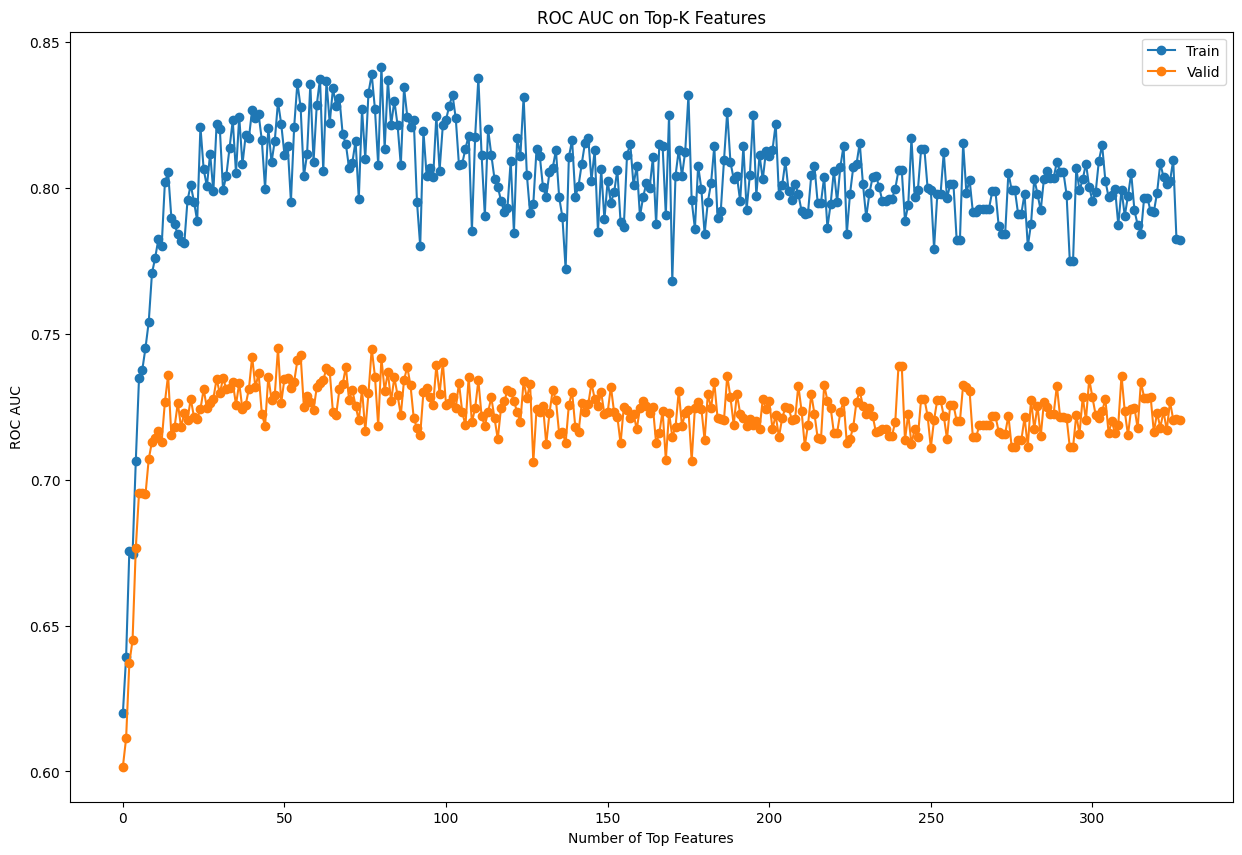

In [62]:
boosting.top_feats_selection()

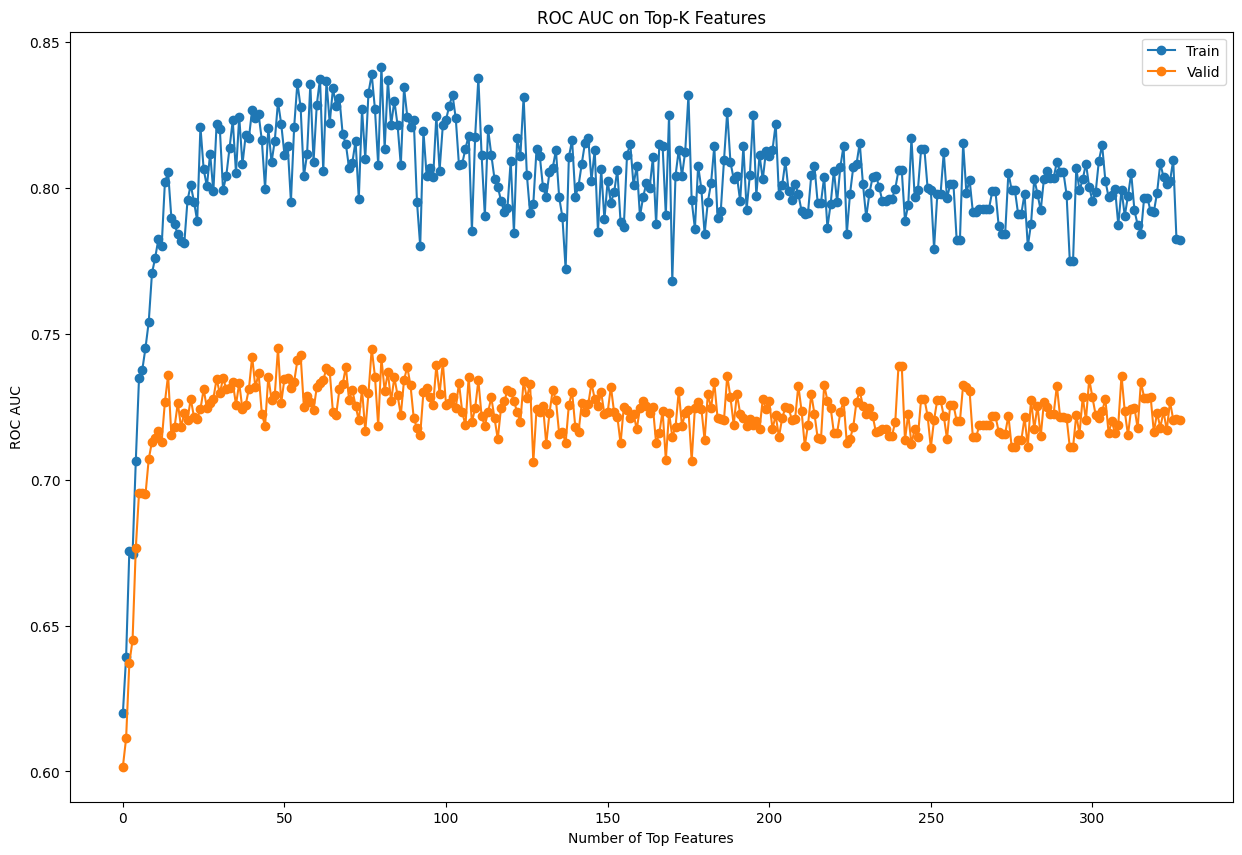

In [64]:
df = pd.read_excel("no_optuna_top_features.xlsx")

plt.figure(figsize=(15, 10))
plt.plot(range(len(boosting.top_features)), df["TRAIN"], marker="o", label="Train")
plt.plot(range(len(boosting.top_features)), df["VALID"], marker="o", label="Valid")
plt.xlabel("Number of Top Features")
plt.ylabel("ROC AUC")
plt.title("ROC AUC on Top-K Features")
plt.legend()
plt.show()

# Feature selection

In [65]:
#boosting.save_model("base_boosting.top_feats_selection()
df = pd.read_excel("no_optuna_top_features.xlsx")
df1 = pd.read_excel("feature_importance.xlsx")
df2 = pd.read_excel("no_optuna_one_factor_roc.xlsx")

In [66]:
df

,TRAIN,VALID
0,0.619895,0.601602
1,0.639095,0.611312
2,0.675520,0.637138
3,0.674389,0.644993
4,0.706443,0.676491
...,...,...
323,0.801280,0.716897
324,0.802284,0.726814
325,0.809590,0.720609
326,0.782525,0.720859


In [67]:
df1

,Feature,Importance
0,s6_sensor0_millimeter_step1,0.000000
1,s0_sensor34_kilonewton_step2,0.000000
2,s6_sensor22_kilonewton_step2,0.000000
3,s9_sensor27_coulomb_step1,0.000000
4,s10_sensor1_coulomb_step1,0.000000
...,...,...
323,s8_sensor48_ml_step1,3.267996
324,s7_sensor26_mikroohm_step1,3.855767
325,s8_sensor101_millimeter_step1,4.490326
326,s4_sensor16_minuten (zeit)_step1,5.061526


In [68]:
df2

,features,train,valid
0,s6_sensor0_millimeter_step1,0.537620,0.524218
1,s8_sensor0_millimeter_step1,0.573605,0.568448
2,s8_sensor1_millimeter_step1,0.611633,0.607371
3,s7_sensor0_newton_step1,0.601477,0.580213
4,s9_sensor0_kilonewton_step1,0.514788,0.511466
...,...,...,...
304,s7_sensor50_mikrometer_step1,0.550132,0.559086
305,s2_sensor25_millimeter_step1,0.540152,0.529307
306,s8_sensor121_binaer_step1,0.514811,0.511430
307,s8_sensor122_millimeter_step1,0.560316,0.542911


In [76]:
import pandas as pd

# Загрузка данных
df_importance = pd.read_excel("feature_importance.xlsx")
df_metrics = pd.read_excel("no_optuna_one_factor_roc.xlsx")

# Установка критериев
importance_threshold = 1
roc_auc_threshold = 0.55    # Минимальный порог ROC AUC

# Фильтрация данных
df_filtered = df_importance.merge(df_metrics, left_on='Feature', right_on='features')
df_selected = df_filtered[
    (df_filtered['Importance'] > importance_threshold) &
    (df_filtered['valid'] > roc_auc_threshold)
]

# Вывод отобранных фичей
selected_features = df_selected['Feature'].tolist()
print("Отобранные фичи:", selected_features)

# Сохранение результатов
df_selected.to_excel("selected_features.xlsx", index=False)


Отобранные фичи: ['s8_sensor62_dm_step1', 's7_sensor31_millisekunde_step1', 's7_sensor30_watt/sekunde_step1', 's8_sensor33_millimeter_step1', 's7_sensor2_mikroohm_step1', 's7_sensor23_cse_step1', 's8_sensor34_millimeter_step1', 's10_sensor0_minuten (zeit)_step1', 's7_sensor33_newton_step1', 's7_sensor32_cse_step1', 's7_sensor6_newton_step1', 's8_sensor100_millimeter_step1', 's7_sensor42_cse_step1', 's7_sensor0_newton_step1', 's7_sensor44_newton_step1', 's3_sensor0_km_step1', 's10_sensor2_gramm_step1', 's7_sensor7_cse_step1', 's8_sensor48_ml_step1', 's7_sensor26_mikroohm_step1', 's8_sensor101_millimeter_step1', 's4_sensor16_minuten (zeit)_step1', 's8_sensor32_millimeter_step1']


In [77]:
len(selected_features)

23

### Optuna

In [116]:
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')
y_train = X_train['label']
X_train = X_train.drop(columns='label')

In [117]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [118]:
X_train_opt = X_train[selected_features]
X_val_opt = X_val[selected_features]

In [97]:
opt_boosting = Boosting(X_train_opt, X_val_opt, y_train, y_val, cat_features = [])

Init...
Init Finished!


In [98]:
opt_boosting.optimize_hyperparams()

[I 2024-11-30 20:11:03,693] A new study created in memory with name: no-name-a52324a1-21d6-4ae3-bc35-243ec6ec46a9
[I 2024-11-30 20:11:19,543] Trial 0 finished with value: 0.6719788614253298 and parameters: {'objective': 'MultiClass', 'learning_rate': 0.0005132990274980601, 'l2_leaf_reg': 0.01886434152223284, 'colsample_bylevel': 0.022942979857243667, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 42, 'one_hot_max_size': 34, 'iterations': 950, 'bagging_temperature': 3.3380241170183975}. Best is trial 0 with value: 0.6719788614253298.
[I 2024-11-30 20:11:50,060] Trial 1 finished with value: 0.6734123791357308 and parameters: {'objective': 'MultiClass', 'learning_rate': 0.0005999721959935192, 'l2_leaf_reg': 0.9915109229249007, 'colsample_bylevel': 0.04052588102586731, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 34, 'one_hot_max_size': 26, 'iterations': 1794, 'subsample': 0.2832084003968188}. Best is 

Best params: {'objective': 'MultiClass', 'learning_rate': 0.013192495480758626, 'l2_leaf_reg': 0.011542455577774953, 'colsample_bylevel': 0.04907982018772355, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 14, 'one_hot_max_size': 30, 'iterations': 1890, 'bagging_temperature': 0.9584933076203361}


In [99]:
best_params = {
    'random_seed' : 42,
    'loss_function' : 'Logloss',
    'task_type' : 'CPU',
    'use_best_model' : True,
    'verbose' : 100,
    'thread_count' : -1,
    'early_stopping_rounds' : 100,
    'eval_metric' : 'AUC',
    'objective': 'Logloss',
    'learning_rate': 0.0003824466055684936,
    'l2_leaf_reg': 0.07666962814217754,
    'colsample_bylevel': 0.05172038016957357,
    'depth': 8,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bayesian',
    'min_data_in_leaf': 20,
    'one_hot_max_size': 3,
    'iterations': 2319,
    'bagging_temperature': 8.604739232088155
}

In [119]:
best_boosting = Boosting(X_train_opt, X_val_opt, y_train, y_val, cat_features = []) #, params = best_params

Init...
Init Finished!


In [120]:
best_boosting.train()

0:	test: 0.5000000	best: 0.5000000 (0)	total: 4.73ms	remaining: 4.72s
100:	test: 0.7431260	best: 0.7439502 (83)	total: 336ms	remaining: 2.99s
200:	test: 0.7431807	best: 0.7465045 (155)	total: 668ms	remaining: 2.65s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7465045322
bestIteration = 155

Shrink model to first 156 iterations.
ROC AUC на обучающей выборке: 0.7983189608181573
ROC AUC на валидационной выборке: 0.7465045321646739


In [121]:
best_boosting.save_model("best_boosting.pkl")

In [128]:
y_test_pred = best_boosting.model.predict(X_test[selected_features])
X_test['label'] = y_test_pred


In [129]:
ans = X_test[['physical_part_id', 'label']]
ans['ID'] = ans['physical_part_id']
del ans['physical_part_id']
ans.to_csv("answer.csv", index=False)